In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/polyp/

/content/drive/MyDrive/polyp


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import numpy as np
import matplotlib.pylab as plt

In [4]:
data_root = './polyp_removal_class_2'

In [ ]:
# pip install split-folders

In [ ]:
# import splitfolders

In [ ]:
# #Train, val, test
# splitfolders.ratio(data_root, output="cell_images2", 
#                    seed=42, ratio=(.6, .2, .2), 
#                    group_prefix=None) # default values

Copying files: 2000 files [10:03,  3.31 files/s]


In [5]:
train_dir = '/content/drive/MyDrive/polyp/cell_images2/train'
valid_dir = '/content/drive/MyDrive/polyp/cell_images2/val'
test_dir = '/content/drive/MyDrive/polyp/cell_images2/test'

In [6]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  str(train_dir),
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  str(valid_dir),
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  str(test_dir),
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
)

Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


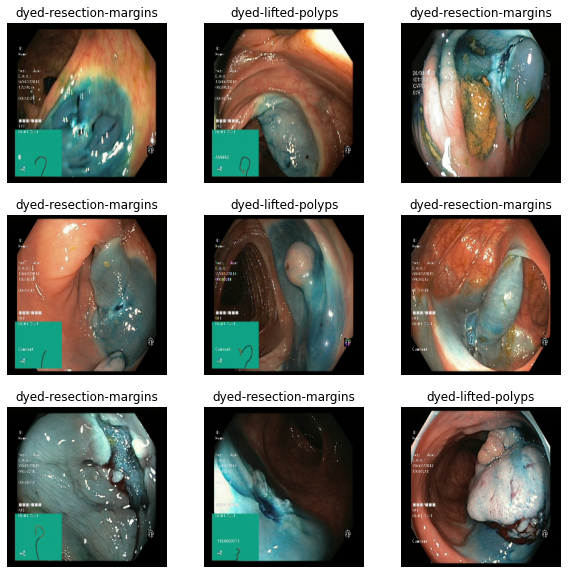

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomContrast(factor=0.2),
  preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Resource

In [10]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.rcParams['figure.dpi'] = 300
  plt.rcParams['savefig.dpi'] = 300
  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# Densenet

## Densenet121
model_1;
history_1;
val_result_1;
test_result_1;

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.DenseNet121(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss= tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

Epoch 1/20
19/19 [==============================] - 15s 435ms/step - loss: 0.7357 - accuracy: 0.5475 - val_loss: 0.6805 - val_accuracy: 0.5750
Epoch 2/20
19/19 [==============================] - 8s 383ms/step - loss: 0.6443 - accuracy: 0.6175 - val_loss: 0.6314 - val_accuracy: 0.6525
Epoch 3/20
19/19 [==============================] - 7s 313ms/step - loss: 0.5973 - accuracy: 0.6908 - val_loss: 0.5908 - val_accuracy: 0.6625
Epoch 4/20
19/19 [==============================] - 9s 421ms/step - loss: 0.5704 - accuracy: 0.7117 - val_loss: 0.5762 - val_accuracy: 0.6950
Epoch 5/20
19/19 [==============================] - 7s 314ms/step - loss: 0.5289 - accuracy: 0.7483 - val_loss: 0.5449 - val_accuracy: 0.7150
Epoch 6/20
19/19 [==============================] - 8s 373ms/step - loss: 0.5216 - accuracy: 0.7458 - val_loss: 0.5263 - val_accuracy: 0.7425
Epoch 7/20
19/19 [==============================] - 7s 339ms/step - loss: 0.4962 - accuracy: 0.7767 - val_loss: 0.5109 - val_accuracy: 0.7575
Epoch

In [ ]:
# Evaluate on the valid data
val_result_1 = model_1.evaluate(validation_dataset)
val_result_1

7/7 [==============================] - 2s 98ms/step - loss: 0.4276 - accuracy: 0.8125


[0.42759454250335693, 0.8125]

In [ ]:
# Evaluate on the test data
test_result_1 = model_1.evaluate(test_dataset)
test_result_1

7/7 [==============================] - 2s 97ms/step - loss: 0.3852 - accuracy: 0.8225


[0.38521602749824524, 0.8224999904632568]

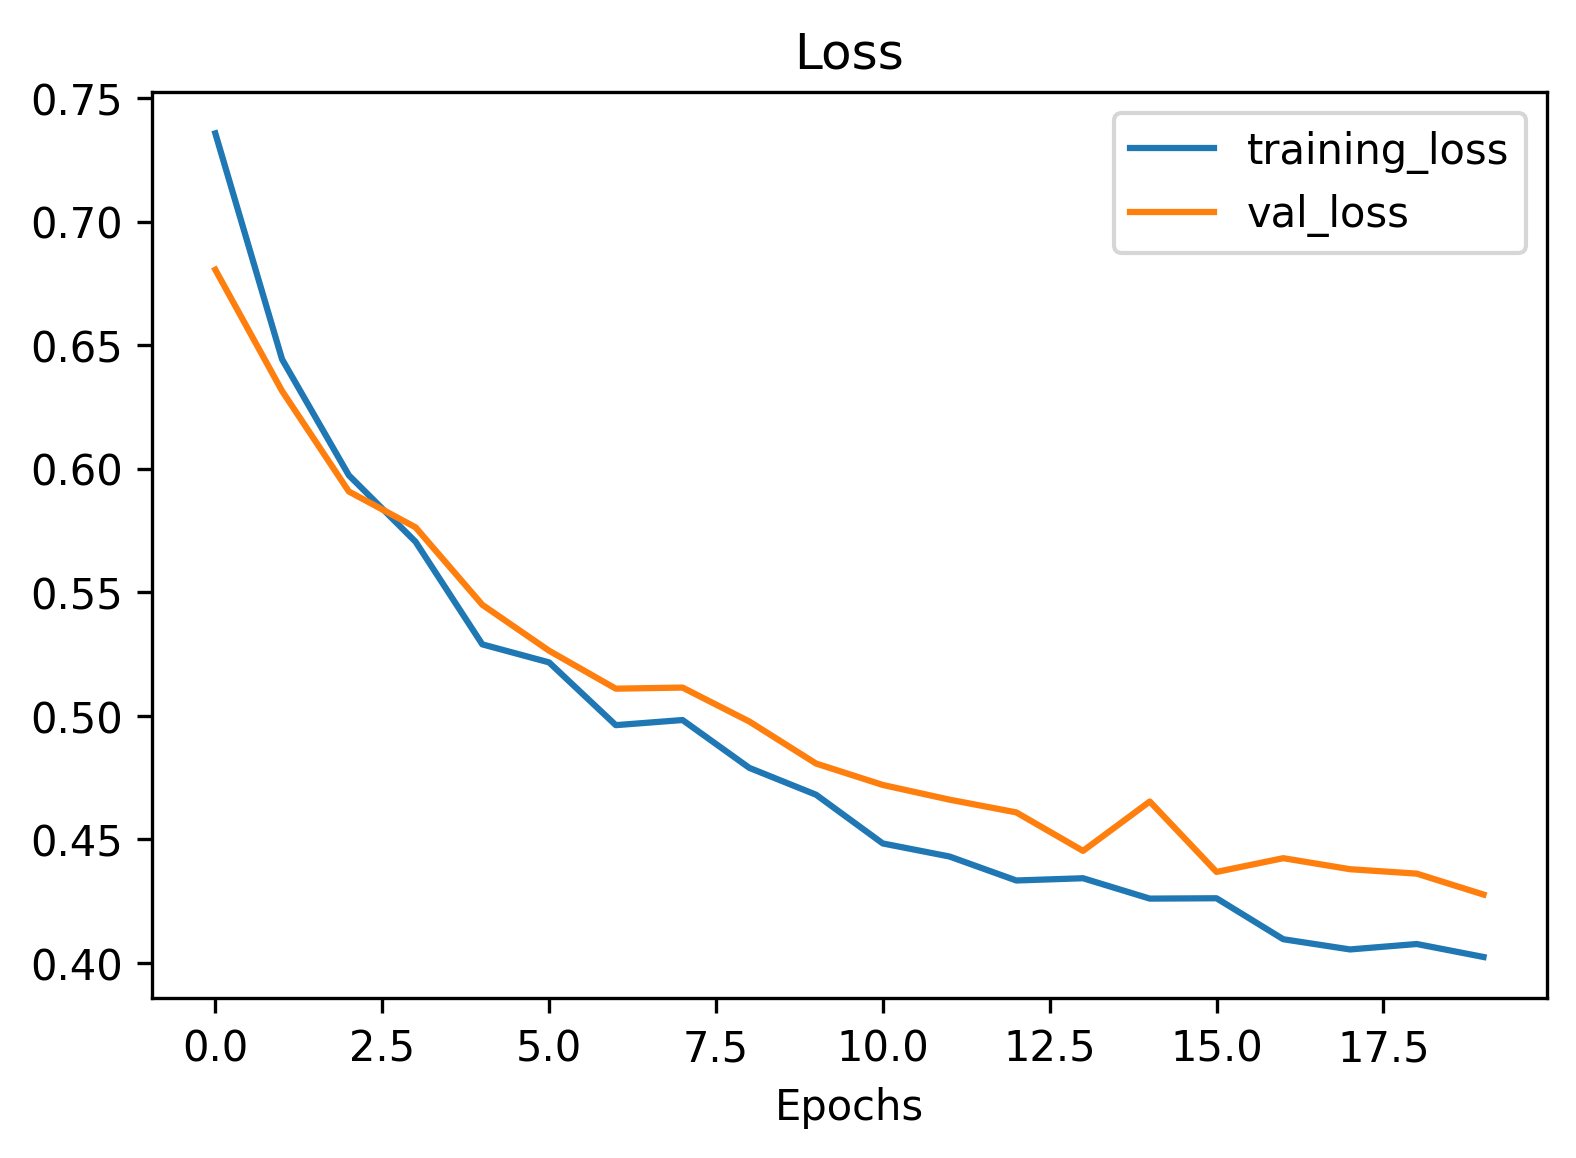

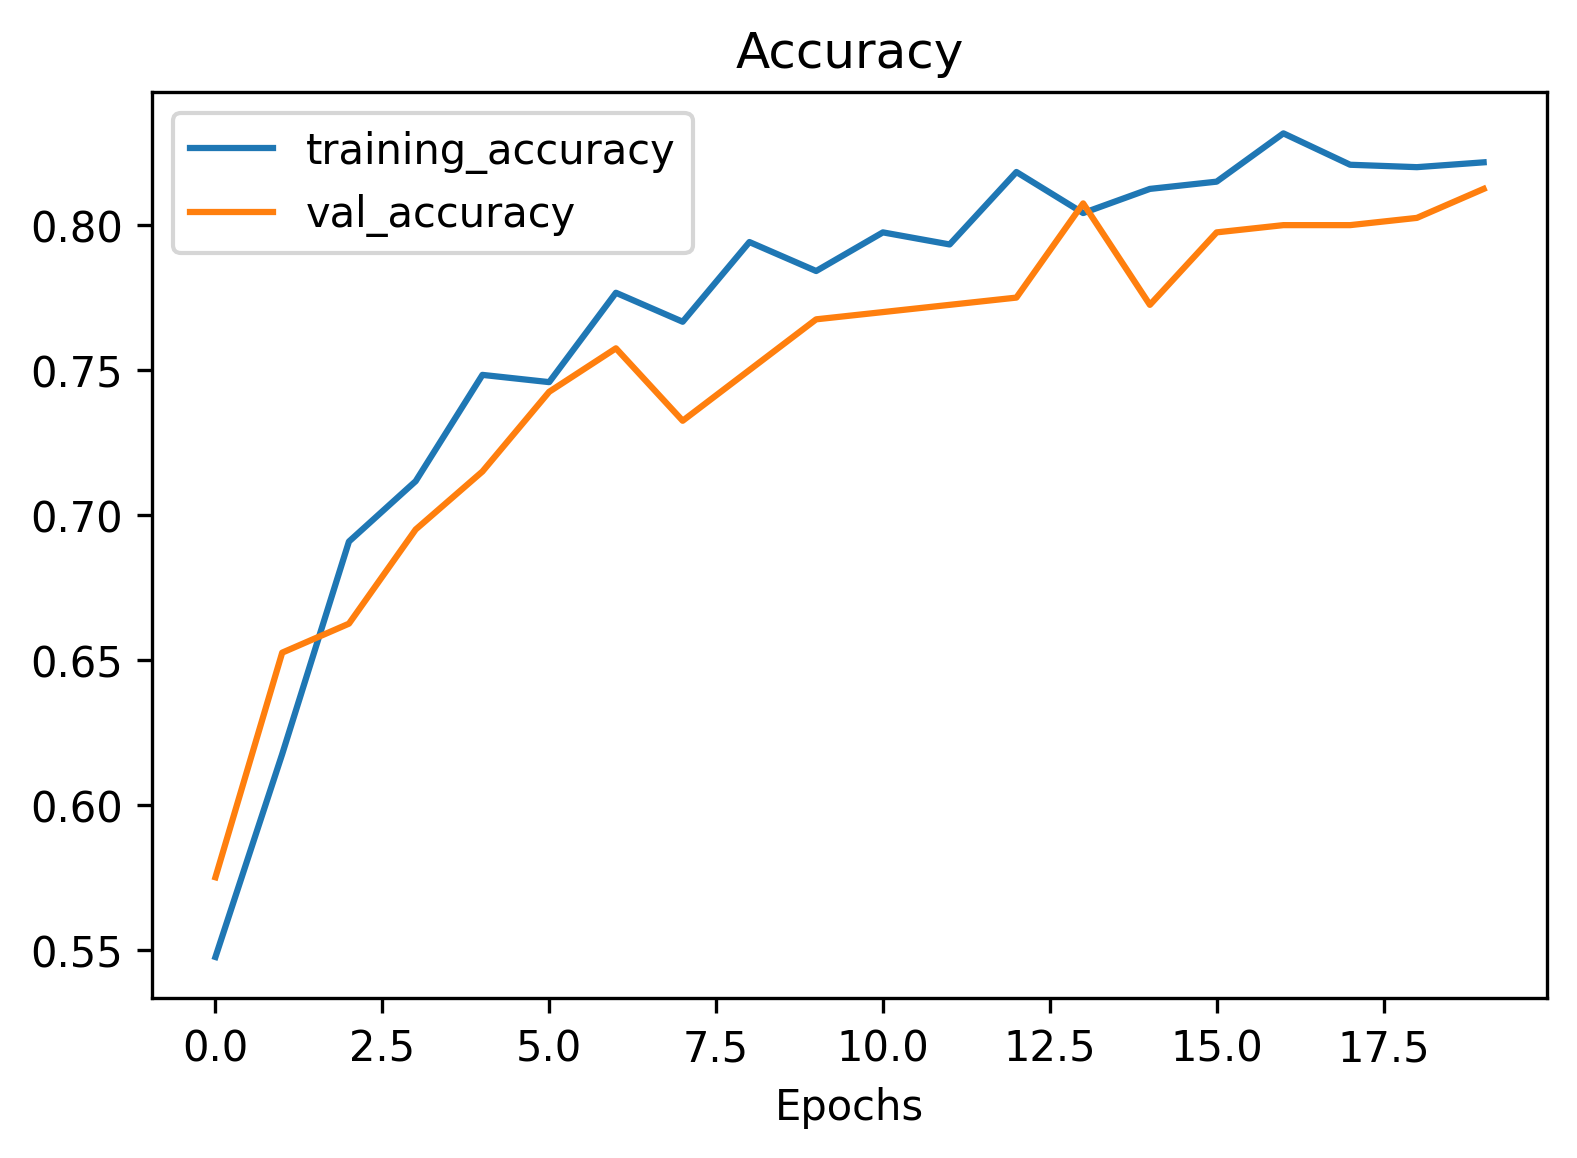

In [ ]:
plot_loss_curves(history_1)

### Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_1.predict(image_batch)
   # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
acc = accuracy_score(y_pred=predicted_labels, y_true=correct_labels)
acc

0.8225

In [ ]:
model_1.evaluate(test_dataset)

7/7 [==============================] - 2s 97ms/step - loss: 0.3852 - accuracy: 0.8225


[0.38521602749824524, 0.8224999904632568]

In [ ]:
confusion_matrix(y_pred=predicted_labels, y_true=correct_labels)

array([[178,  22],
       [ 49, 151]])

In [ ]:
test_dataset.class_names

['dyed-lifted-polyps', 'dyed-resection-margins']

In [ ]:
cm_1 = confusion_matrix(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])
print(cm_1)

[[151  49]
 [ 22 178]]


In [ ]:
print(classification_report(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.87      0.76      0.81       200
           0       0.78      0.89      0.83       200

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



In [ ]:
recall_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.755

In [ ]:
precision_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.8728323699421965

In [ ]:
f1_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.809651474530831

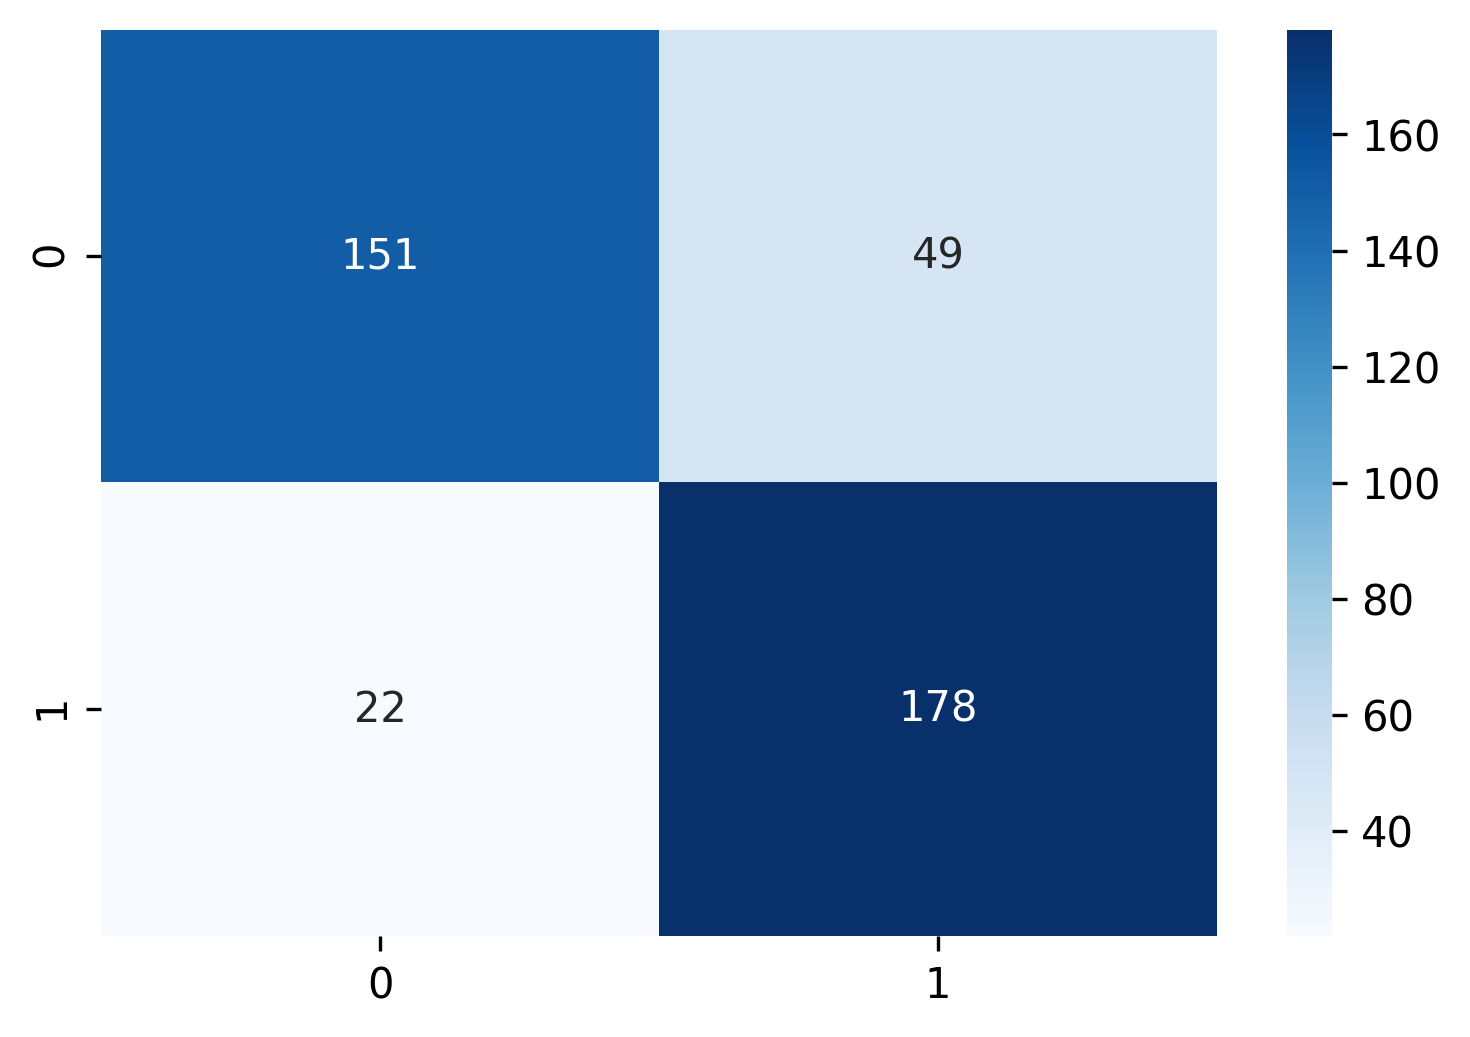

In [ ]:
import seaborn as sns
sns.heatmap(cm_1, annot=True,  fmt='', cmap='Blues', )

## Densenet169
model_2; history_2; val_result_2; test_result_2;

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.DenseNet169(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss= tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

51888128/51877672 [==============================] - 3s 0us/step
Epoch 1/20
19/19 [==============================] - 20s 622ms/step - loss: 0.6567 - accuracy: 0.6117 - val_loss: 0.6004 - val_accuracy: 0.6825
Epoch 2/20
19/19 [==============================] - 9s 438ms/step - loss: 0.5731 - accuracy: 0.7133 - val_loss: 0.5296 - val_accuracy: 0.7200
Epoch 3/20
19/19 [==============================] - 8s 362ms/step - loss: 0.5225 - accuracy: 0.7433 - val_loss: 0.5029 - val_accuracy: 0.7375
Epoch 4/20
19/19 [==============================] - 8s 358ms/step - loss: 0.4898 - accuracy: 0.7708 - val_loss: 0.4692 - val_accuracy: 0.7725
Epoch 5/20
19/19 [==============================] - 8s 343ms/step - loss: 0.4767 - accuracy: 0.7825 - val_loss: 0.4332 - val_accuracy: 0.7850
Epoch 6/20
19/19 [==============================] - 8s 355ms/step - loss: 0.4481 - accuracy: 0.8208 - val_loss: 0.4154 - val_accuracy: 0.8075
Epoch 7/20
19/19 [==============================] - 8s 333ms/step - loss: 0.4359 -

In [ ]:
# Evaluate on the valid data
model_2.evaluate(validation_dataset)

7/7 [==============================] - 2s 116ms/step - loss: 0.3426 - accuracy: 0.8425


[0.3425833582878113, 0.8424999713897705]

In [ ]:
# Evaluate on the test data
model_2.evaluate(test_dataset)

7/7 [==============================] - 2s 116ms/step - loss: 0.3360 - accuracy: 0.8375


[0.33599522709846497, 0.8374999761581421]

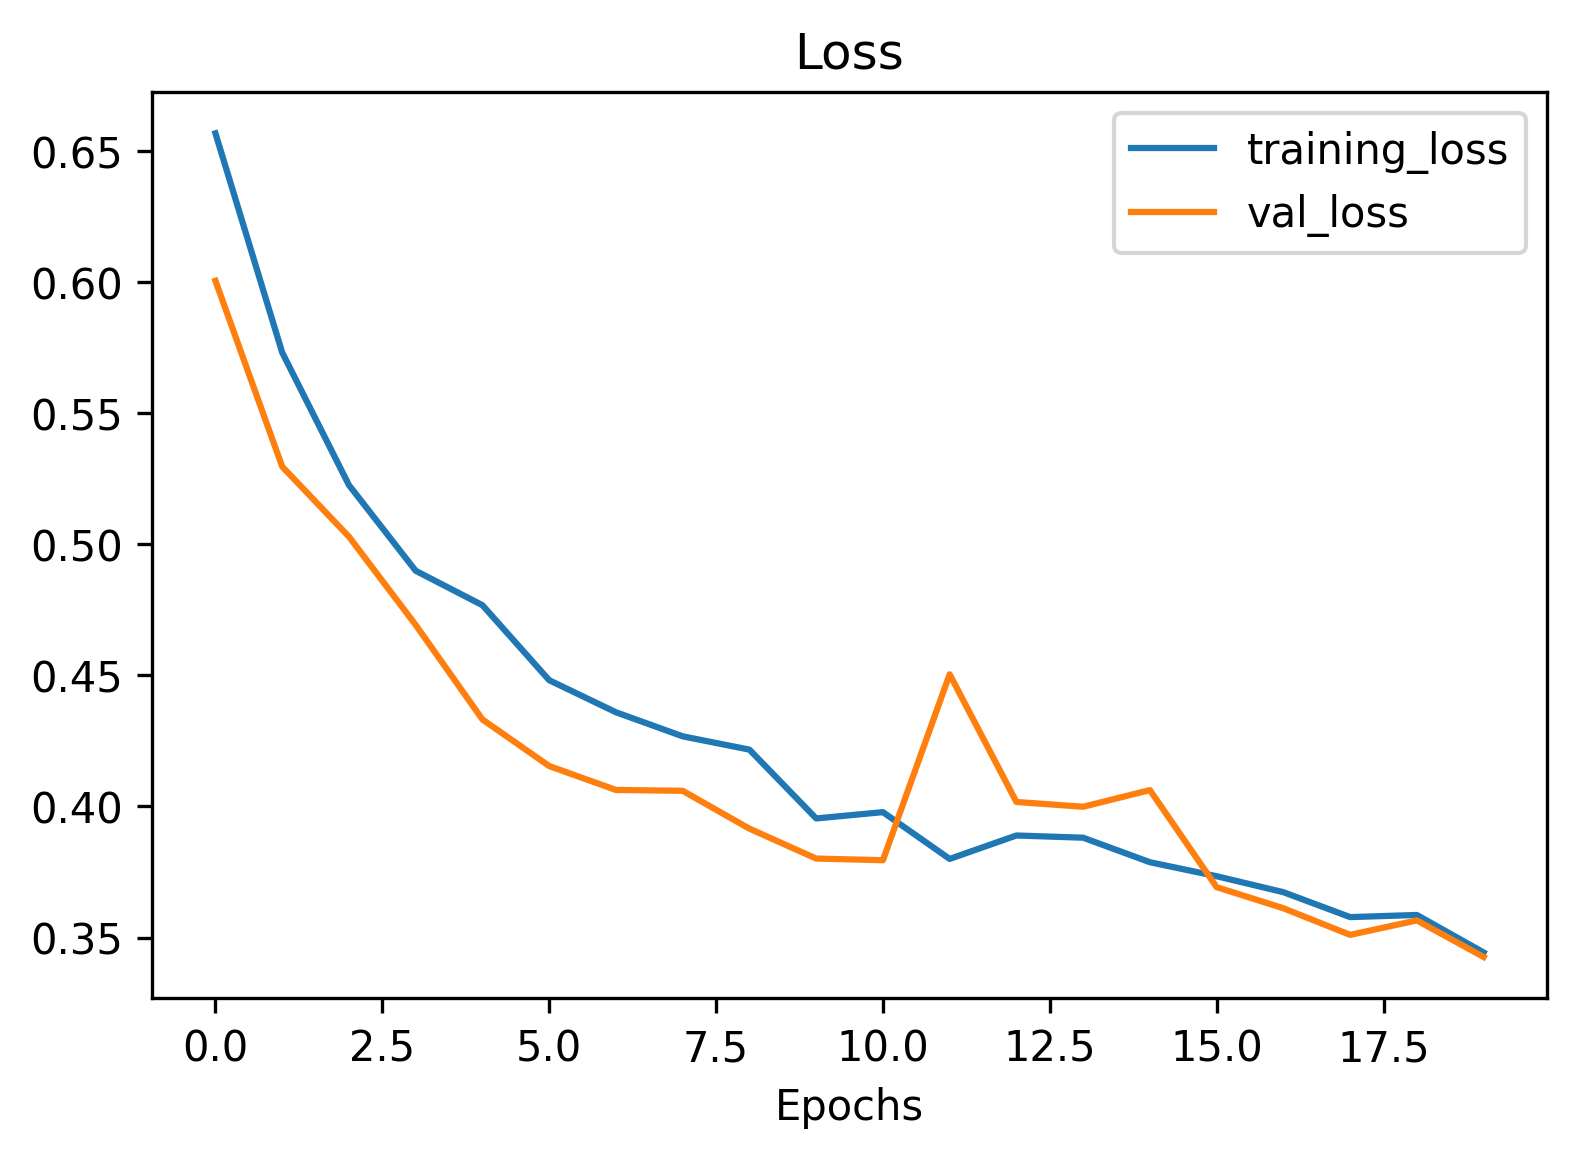

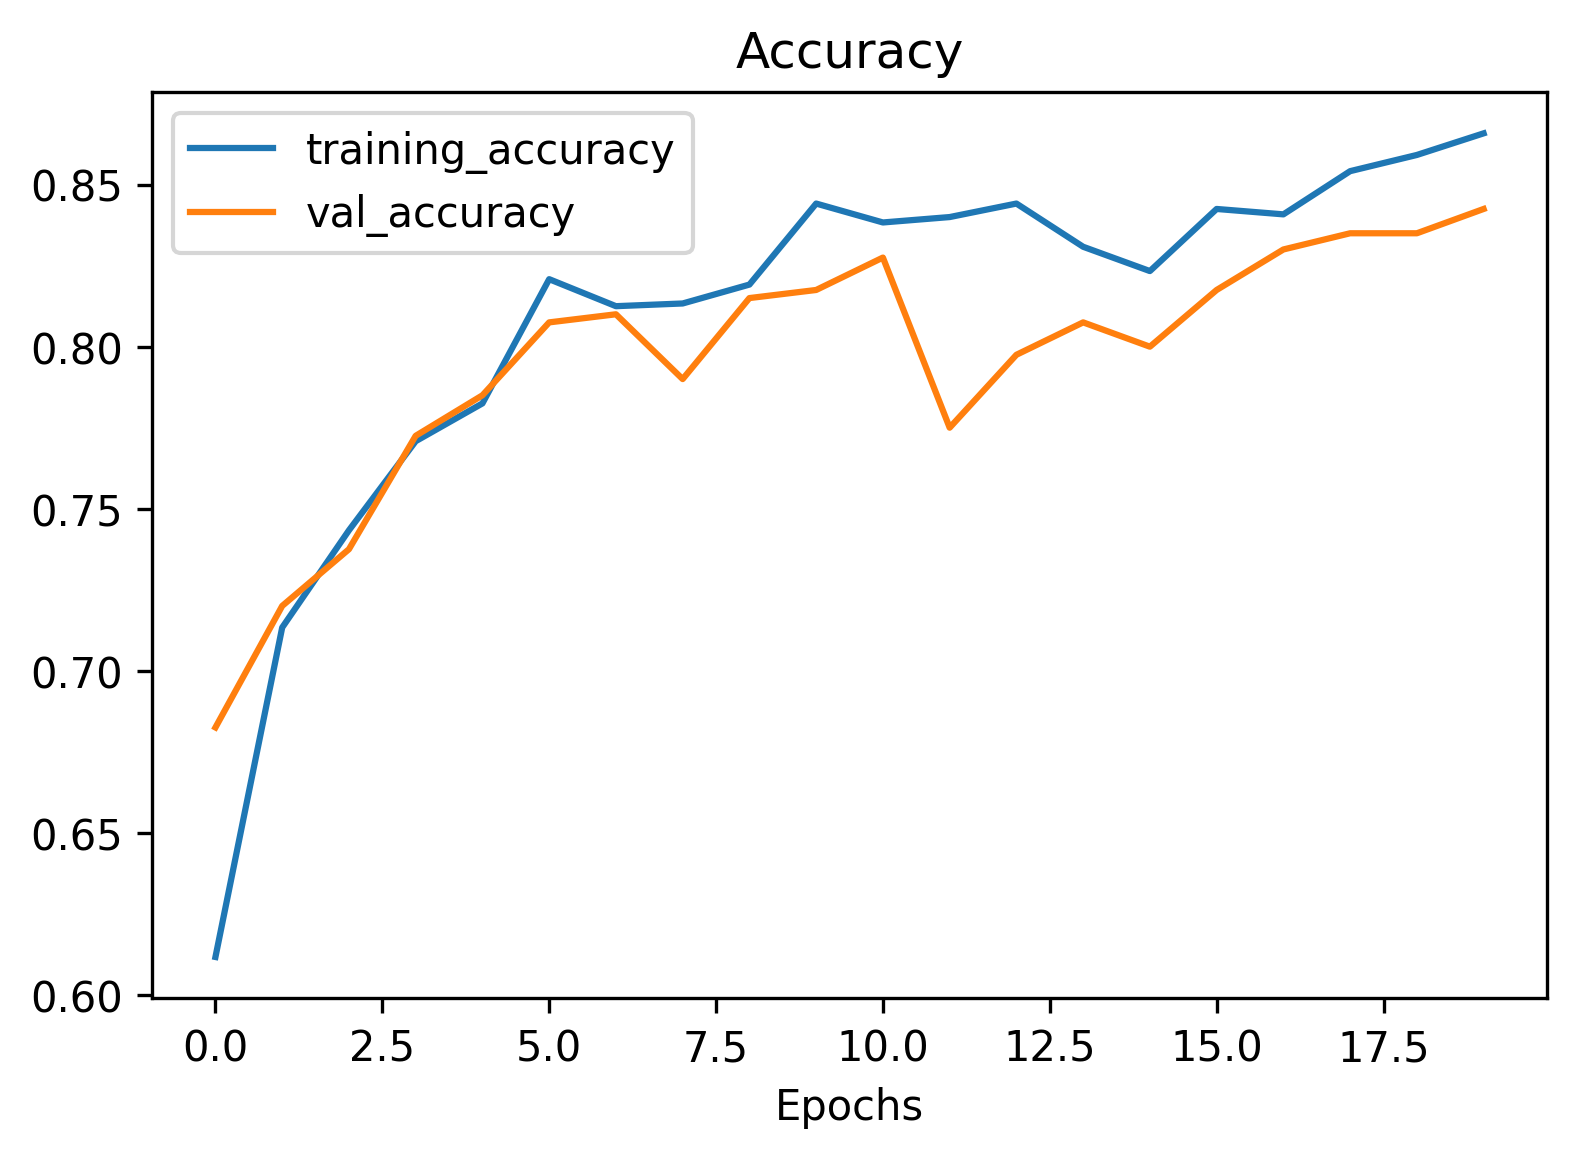

In [ ]:
plot_loss_curves(history_2)

### Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_2.predict(image_batch)
   # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
acc = accuracy_score(y_pred=predicted_labels, y_true=correct_labels)
acc

0.8375

In [ ]:
model_2.evaluate(test_dataset)

7/7 [==============================] - 2s 116ms/step - loss: 0.3360 - accuracy: 0.8375


[0.33599525690078735, 0.8374999761581421]

In [ ]:
confusion_matrix(y_pred=predicted_labels, y_true=correct_labels)

array([[160,  40],
       [ 25, 175]])

In [ ]:
test_dataset.class_names

['dyed-lifted-polyps', 'dyed-resection-margins']

In [ ]:
cm_2 = confusion_matrix(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])
print(cm_2)

[[175  25]
 [ 40 160]]


In [ ]:
print(classification_report(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.81      0.88      0.84       200
           0       0.86      0.80      0.83       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



In [ ]:
recall_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.875

In [ ]:
precision_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.813953488372093

In [ ]:
f1_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.8433734939759036

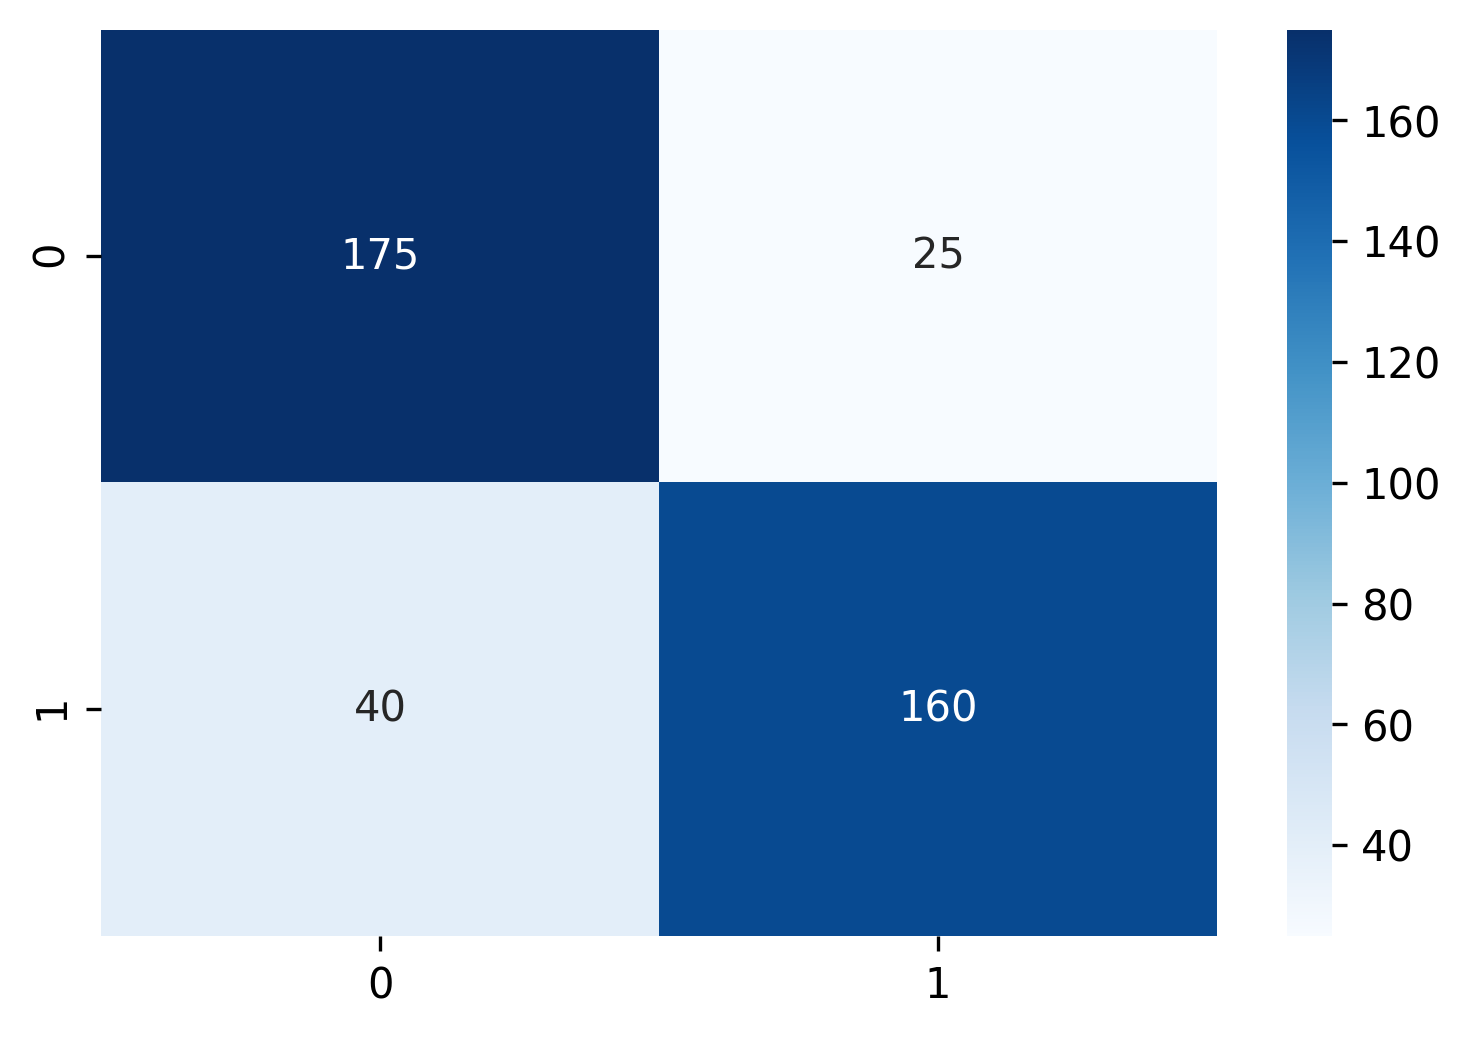

In [ ]:
import seaborn as sns
sns.heatmap(cm_2, annot=True,  fmt='', cmap='Blues', )

## Densenet201
model_3;

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.DenseNet201(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs #4
model_3 = keras.Model(inputs, outputs)

# Compile the model
model_3.compile(loss= tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

74850304/74836368 [==============================] - 2s 0us/step
Epoch 1/20
19/19 [==============================] - 24s 732ms/step - loss: 0.6896 - accuracy: 0.5758 - val_loss: 0.7244 - val_accuracy: 0.5375
Epoch 2/20
19/19 [==============================] - 11s 520ms/step - loss: 0.6013 - accuracy: 0.6775 - val_loss: 0.6674 - val_accuracy: 0.6100
Epoch 3/20
19/19 [==============================] - 9s 391ms/step - loss: 0.5537 - accuracy: 0.7375 - val_loss: 0.5936 - val_accuracy: 0.6750
Epoch 4/20
19/19 [==============================] - 9s 401ms/step - loss: 0.5110 - accuracy: 0.7625 - val_loss: 0.5429 - val_accuracy: 0.7375
Epoch 5/20
19/19 [==============================] - 8s 374ms/step - loss: 0.4747 - accuracy: 0.7858 - val_loss: 0.5171 - val_accuracy: 0.7575
Epoch 6/20
19/19 [==============================] - 8s 366ms/step - loss: 0.4745 - accuracy: 0.7883 - val_loss: 0.5077 - val_accuracy: 0.7625
Epoch 7/20
19/19 [==============================] - 8s 364ms/step - loss: 0.4538 

In [ ]:
# Evaluate on the valid data
model_3.evaluate(validation_dataset)

7/7 [==============================] - 2s 144ms/step - loss: 0.4117 - accuracy: 0.8125


[0.4117406904697418, 0.8125]

In [ ]:
# Evaluate on the test data
model_3.evaluate(test_dataset)

7/7 [==============================] - 2s 143ms/step - loss: 0.3648 - accuracy: 0.8475


[0.3648056089878082, 0.8475000262260437]

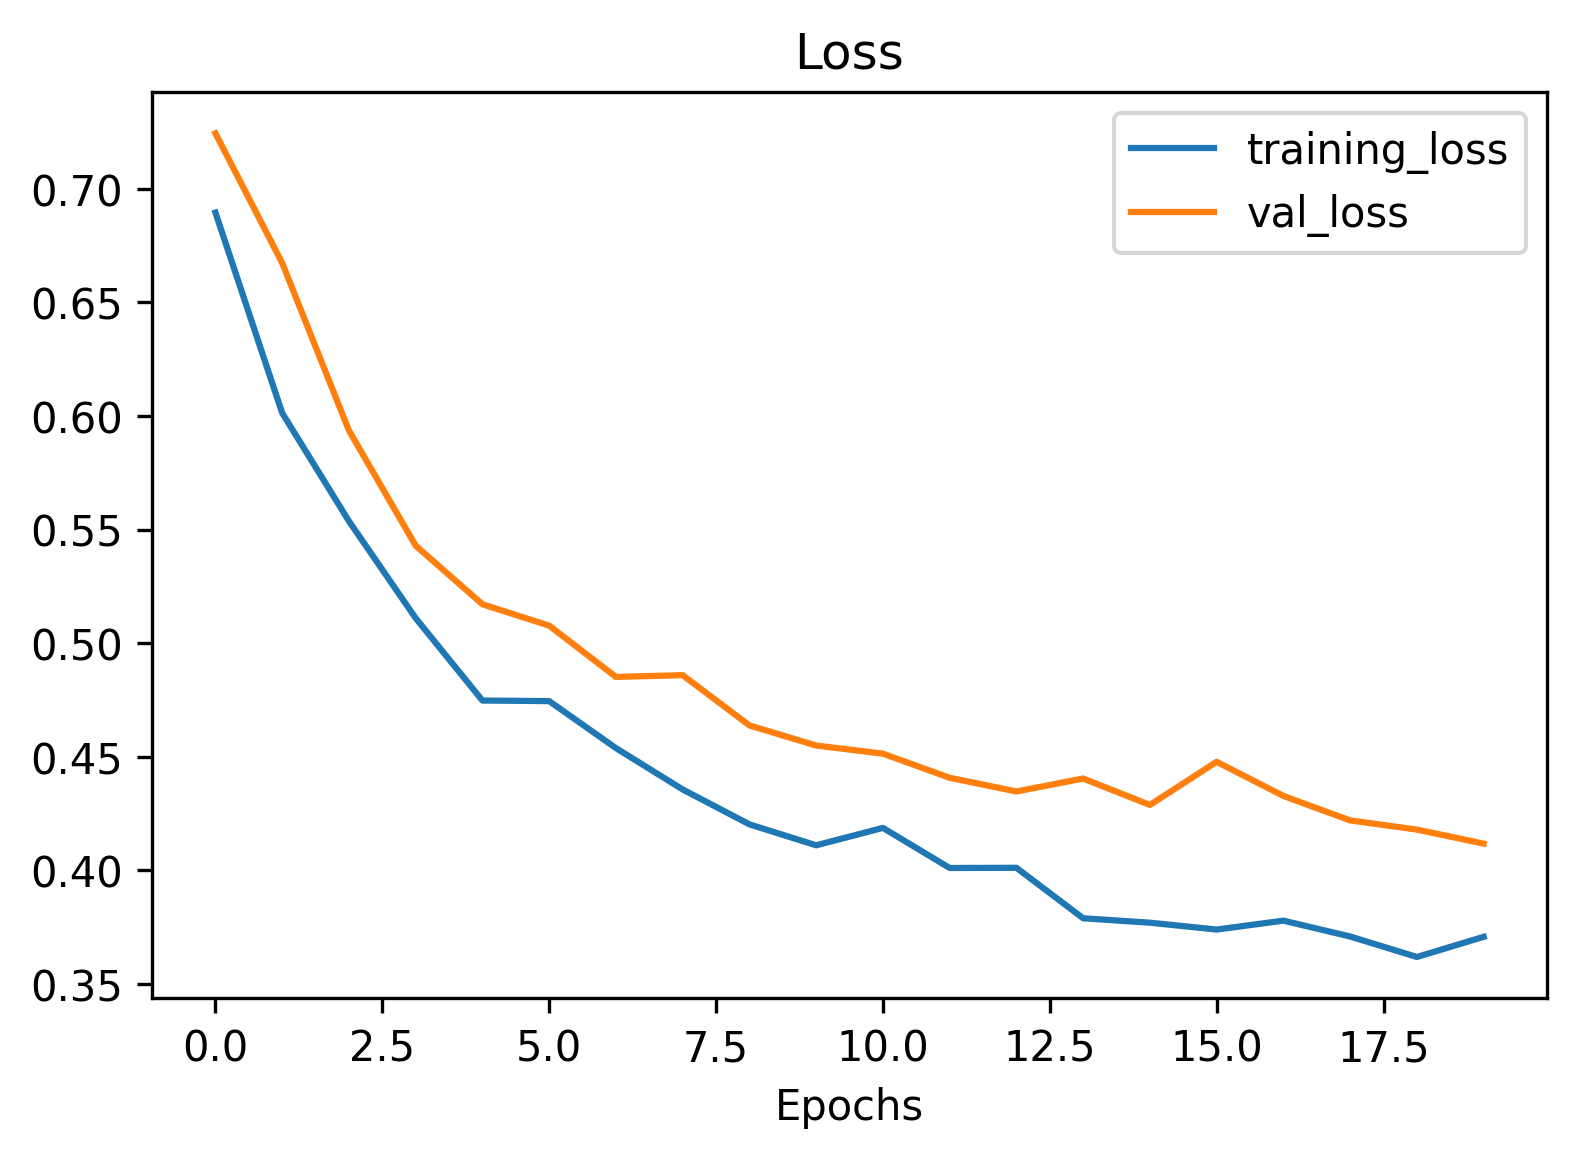

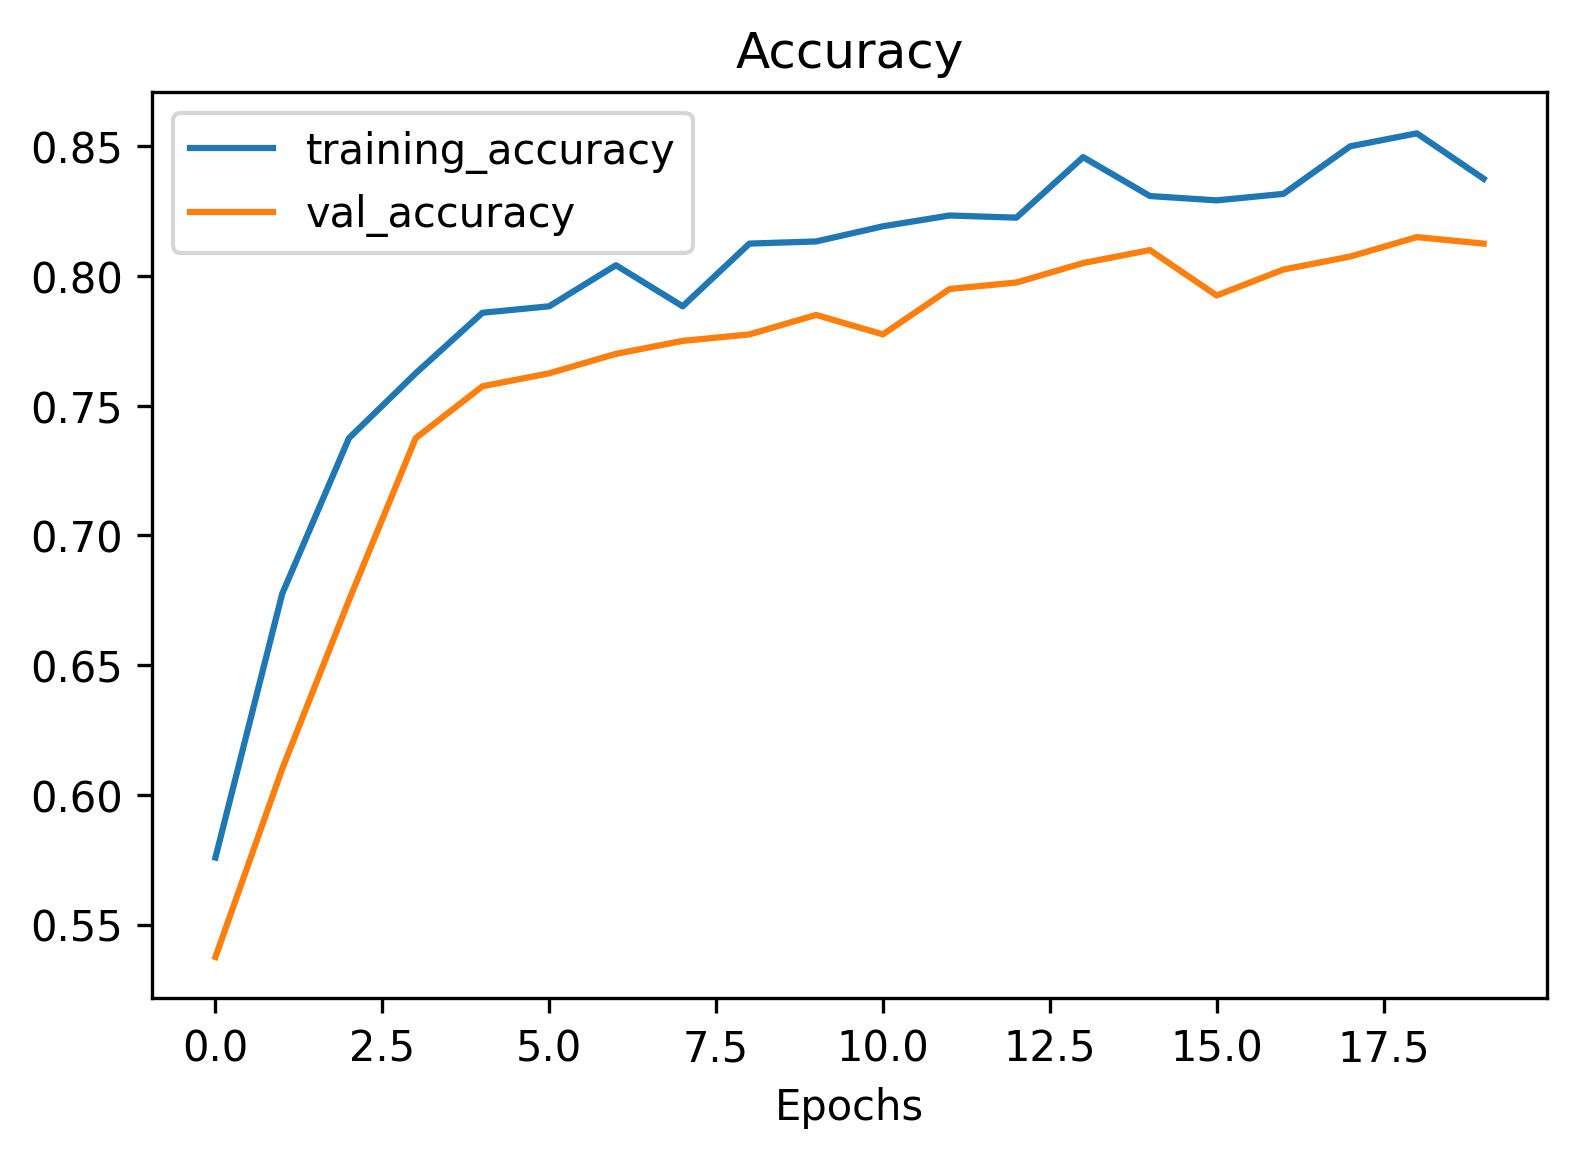

In [ ]:
plot_loss_curves(history_3)

### Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_3.predict(image_batch)
   # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
acc = accuracy_score(y_pred=predicted_labels, y_true=correct_labels)
acc

0.8475

In [ ]:
model_3.evaluate(test_dataset)

7/7 [==============================] - 2s 144ms/step - loss: 0.3648 - accuracy: 0.8475


[0.3648056089878082, 0.8475000262260437]

In [ ]:
confusion_matrix(y_pred=predicted_labels, y_true=correct_labels)

array([[168,  32],
       [ 29, 171]])

In [ ]:
test_dataset.class_names

['dyed-lifted-polyps', 'dyed-resection-margins']

In [ ]:
cm_2 = confusion_matrix(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])
print(cm_2)

[[171  29]
 [ 32 168]]


In [ ]:
print(classification_report(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.84      0.85      0.85       200
           0       0.85      0.84      0.85       200

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



In [ ]:
recall_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.855

In [ ]:
precision_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.8423645320197044

In [ ]:
f1_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.8486352357320099

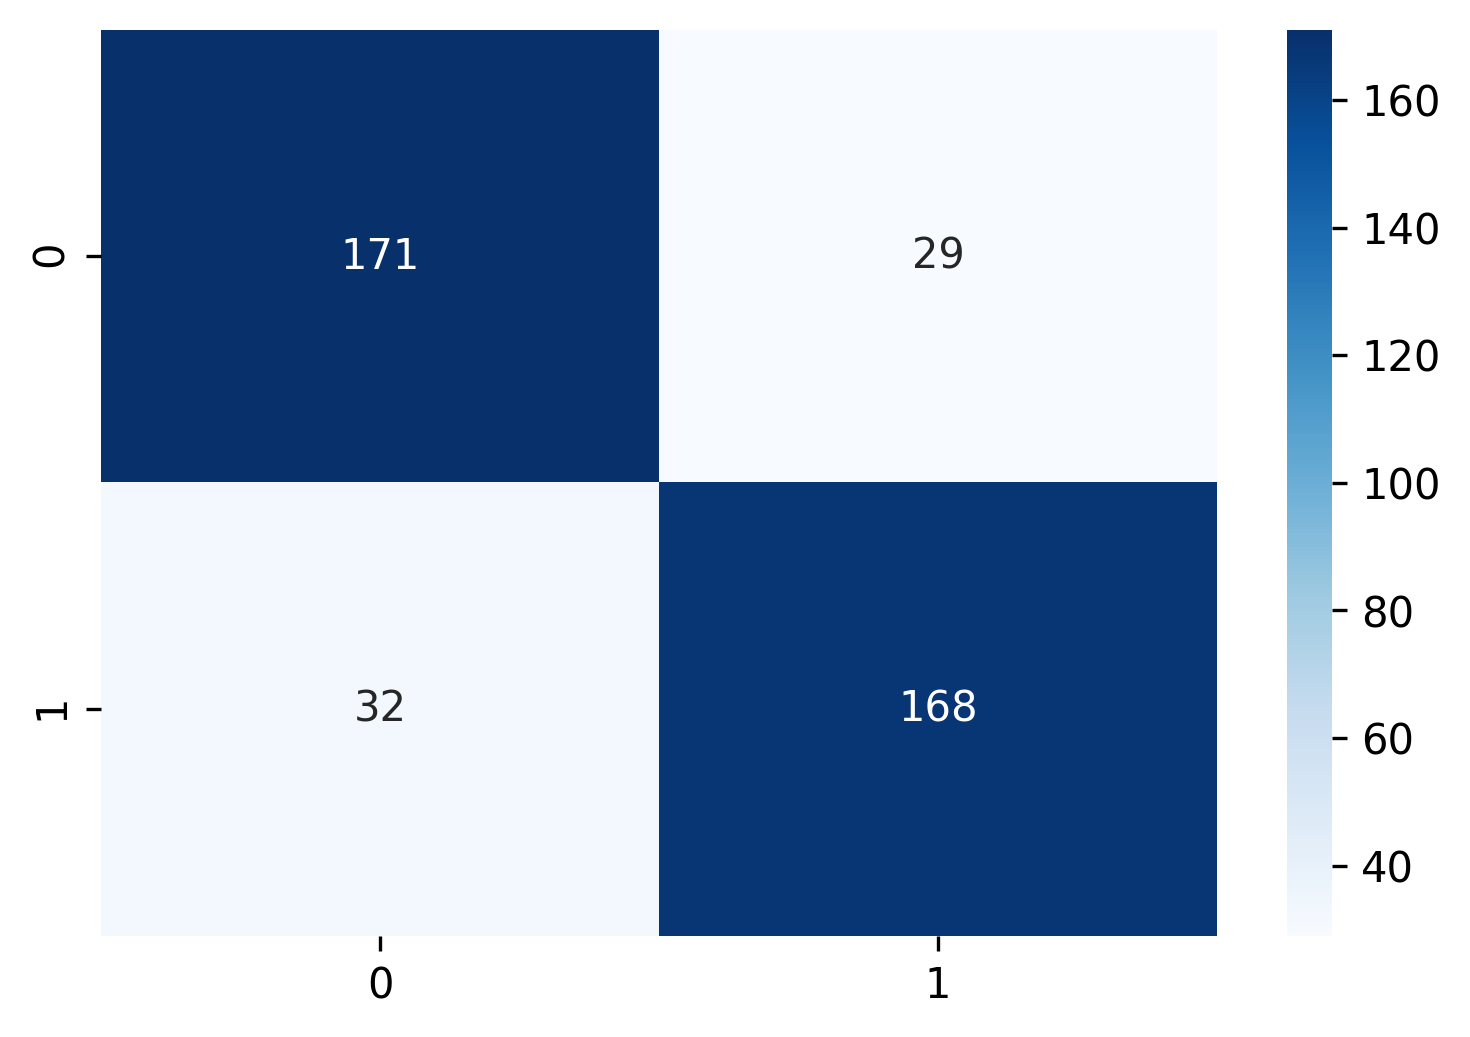

In [ ]:
import seaborn as sns
sns.heatmap(cm_2, annot=True,  fmt='', cmap='Blues', )

# Resnet

## Resnet50 Model 4
model_4;

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet50(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs #4
model_4 = keras.Model(inputs, outputs)

# Compile the model
model_4.compile(loss= tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_4 = model_4.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/20
19/19 [==============================] - 15s 590ms/step - loss: 0.7245 - accuracy: 0.4867 - val_loss: 0.7200 - val_accuracy: 0.5000
Epoch 2/20
19/19 [==============================] - 9s 397ms/step - loss: 0.7066 - accuracy: 0.5117 - val_loss: 0.6955 - val_accuracy: 0.5025
Epoch 3/20
19/19 [==============================] - 9s 426ms/step - loss: 0.7084 - accuracy: 0.5042 - val_loss: 0.6949 - val_accuracy: 0.5075
Epoch 4/20
19/19 [==============================] - 9s 403ms/step - loss: 0.7026 - accuracy: 0.5175 - val_loss: 0.7051 - val_accuracy: 0.5000
Epoch 5/20
19/19 [==============================] - 9s 399ms/step - loss: 0.7001 - accuracy: 0.4983 - val_loss: 0.6927 - val_accuracy: 0.5200
Epoch 6/20
19/19 [==============================] - 8s 376ms/step - loss: 0.6966 - accuracy: 0.4925 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 7/20
19/19 [==============================] - 8s 355ms/step - loss: 0.6964 -

In [ ]:
# Evaluate on the valid data
model_4.evaluate(validation_dataset)

7/7 [==============================] - 1s 99ms/step - loss: 0.6900 - accuracy: 0.5425


[0.6899591684341431, 0.5425000190734863]

In [ ]:
# Evaluate on the test data
model_4.evaluate(test_dataset)

7/7 [==============================] - 2s 99ms/step - loss: 0.6896 - accuracy: 0.5250


[0.6895958185195923, 0.5249999761581421]

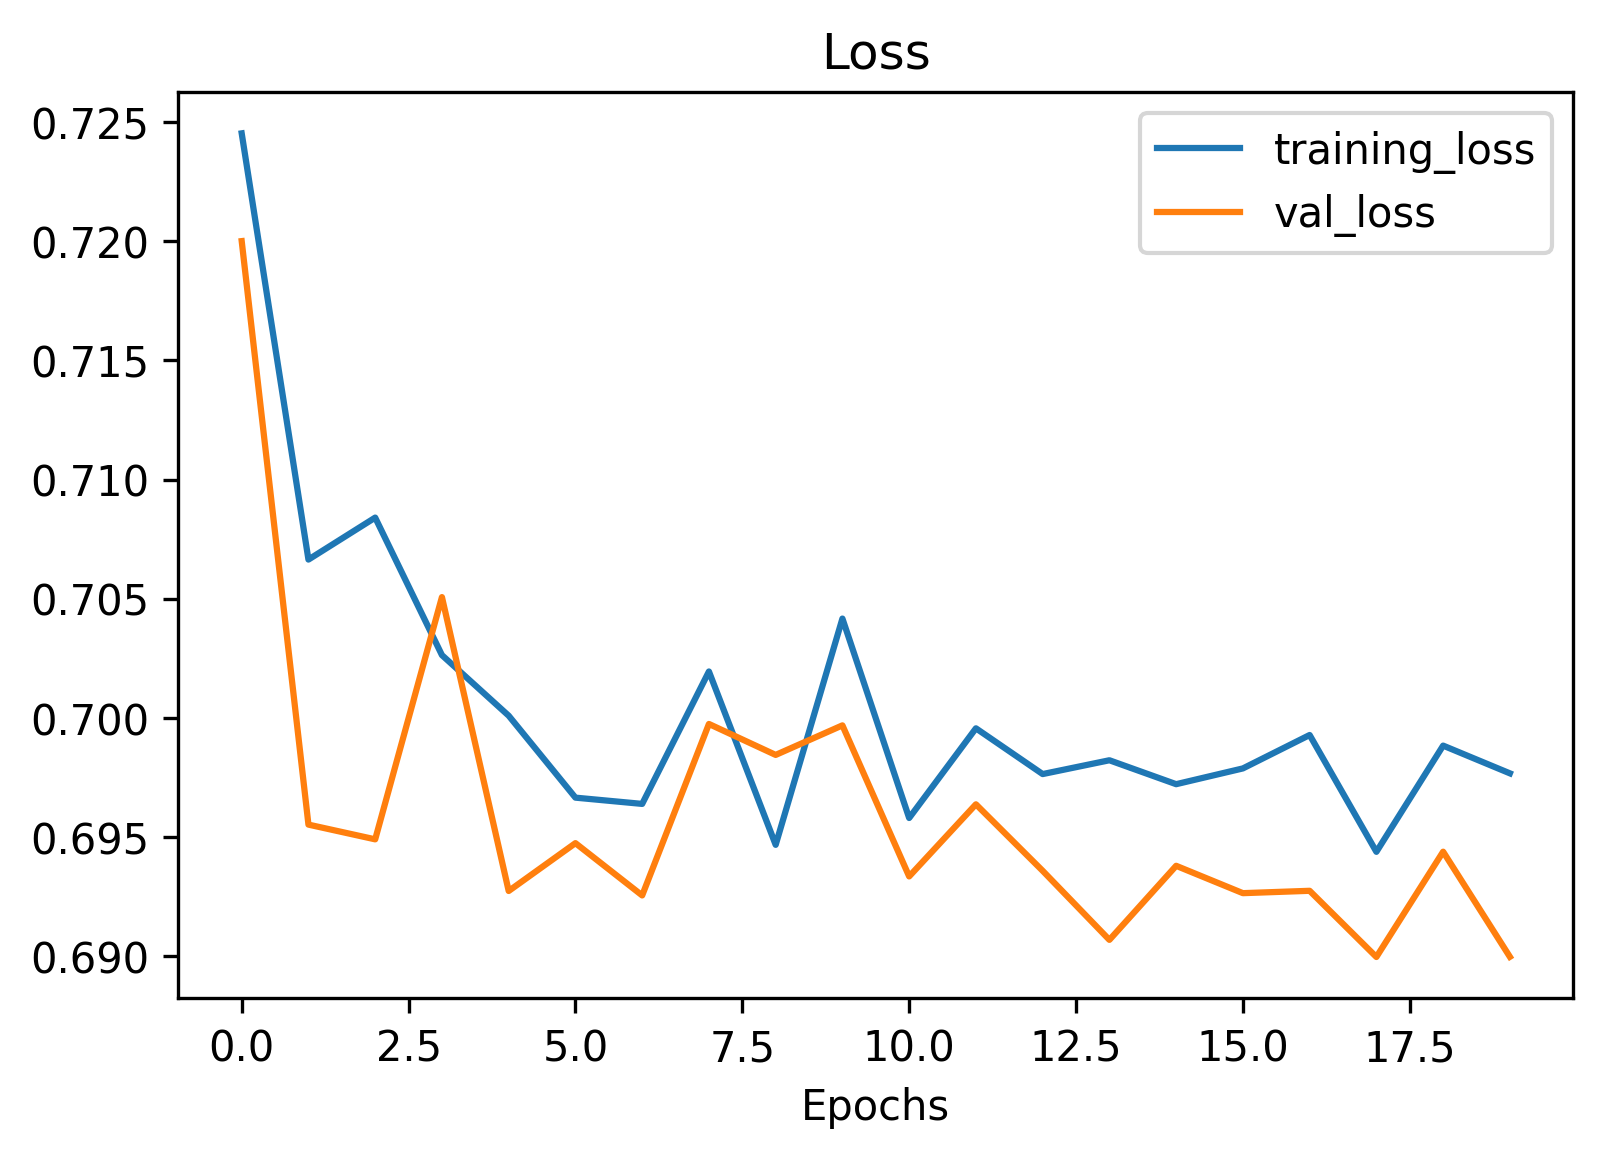

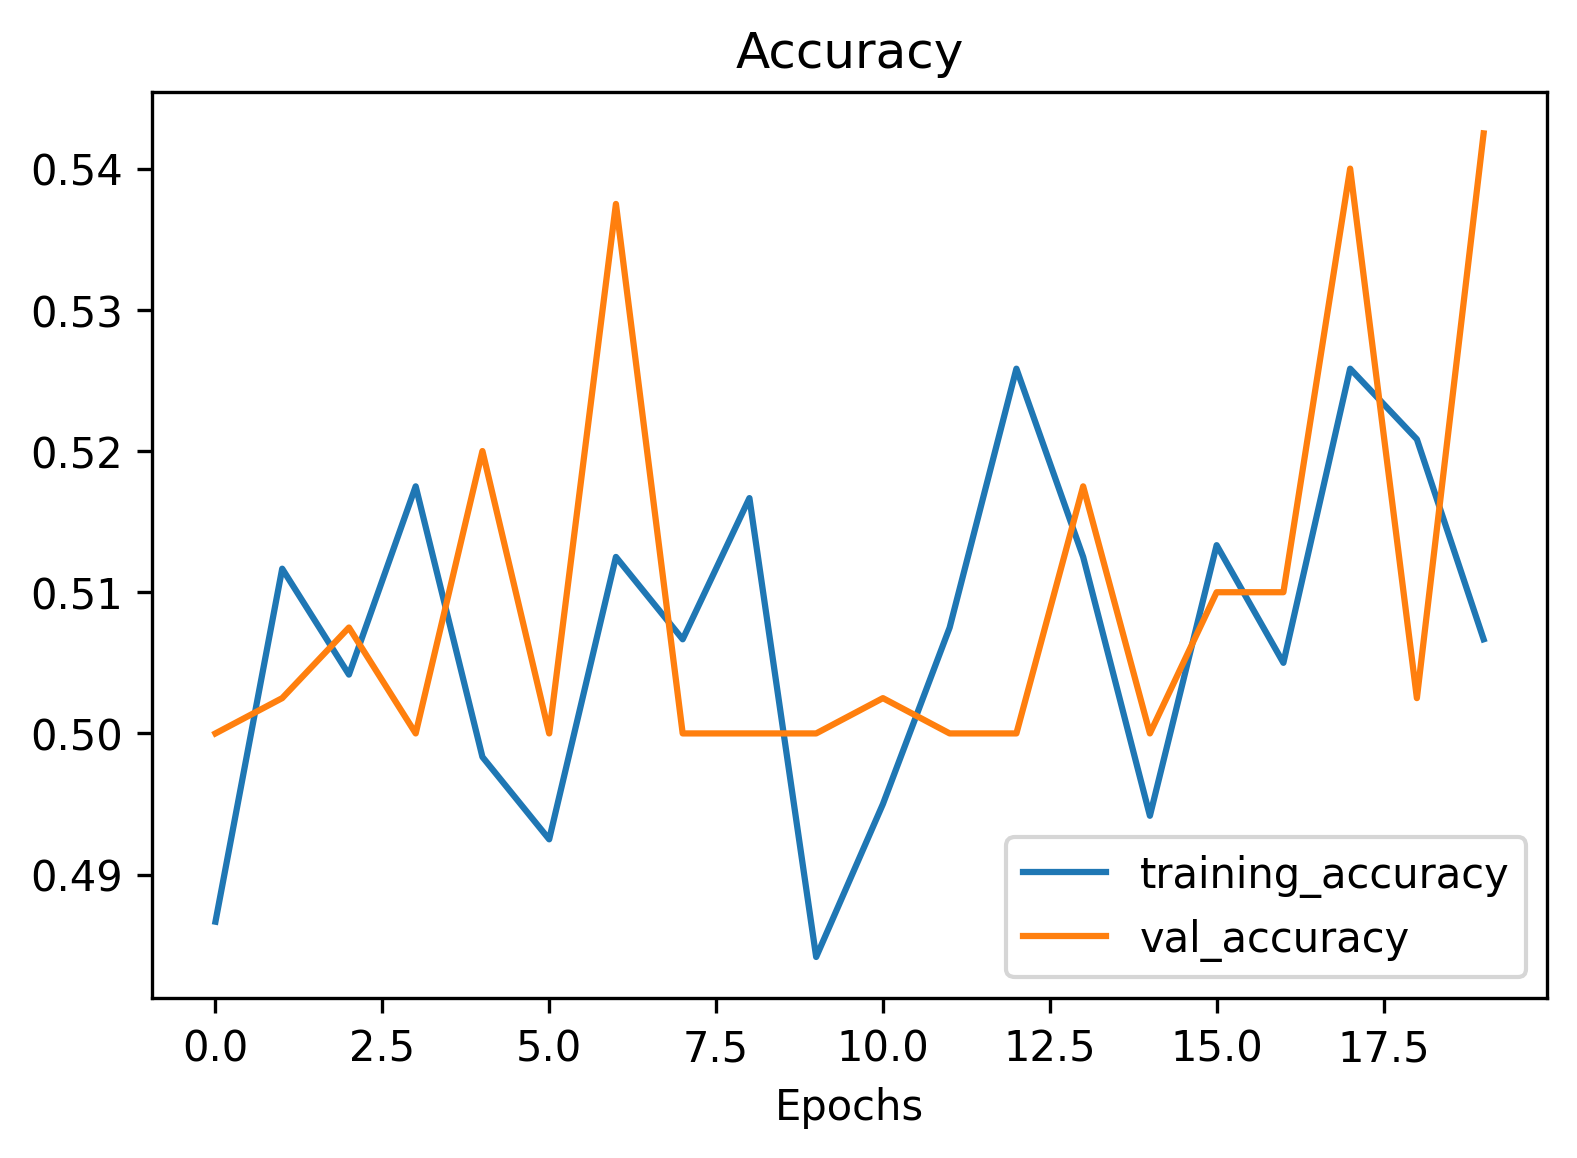

In [ ]:
plot_loss_curves(history_4)

### Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_4.predict(image_batch)
   # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
acc = accuracy_score(y_pred=predicted_labels, y_true=correct_labels)
acc

0.525

In [ ]:
model_4.evaluate(test_dataset)

7/7 [==============================] - 2s 99ms/step - loss: 0.6896 - accuracy: 0.5250


[0.6895958781242371, 0.5249999761581421]

In [ ]:
confusion_matrix(y_pred=predicted_labels, y_true=correct_labels)

array([[185,  15],
       [175,  25]])

In [ ]:
test_dataset.class_names

['dyed-lifted-polyps', 'dyed-resection-margins']

In [ ]:
cm_4 = confusion_matrix(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])
print(cm_4)

[[ 25 175]
 [ 15 185]]


In [ ]:
print(classification_report(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.62      0.12      0.21       200
           0       0.51      0.93      0.66       200

    accuracy                           0.53       400
   macro avg       0.57      0.53      0.43       400
weighted avg       0.57      0.53      0.43       400



In [ ]:
recall_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.125

In [ ]:
precision_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.625

In [ ]:
f1_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.20833333333333334

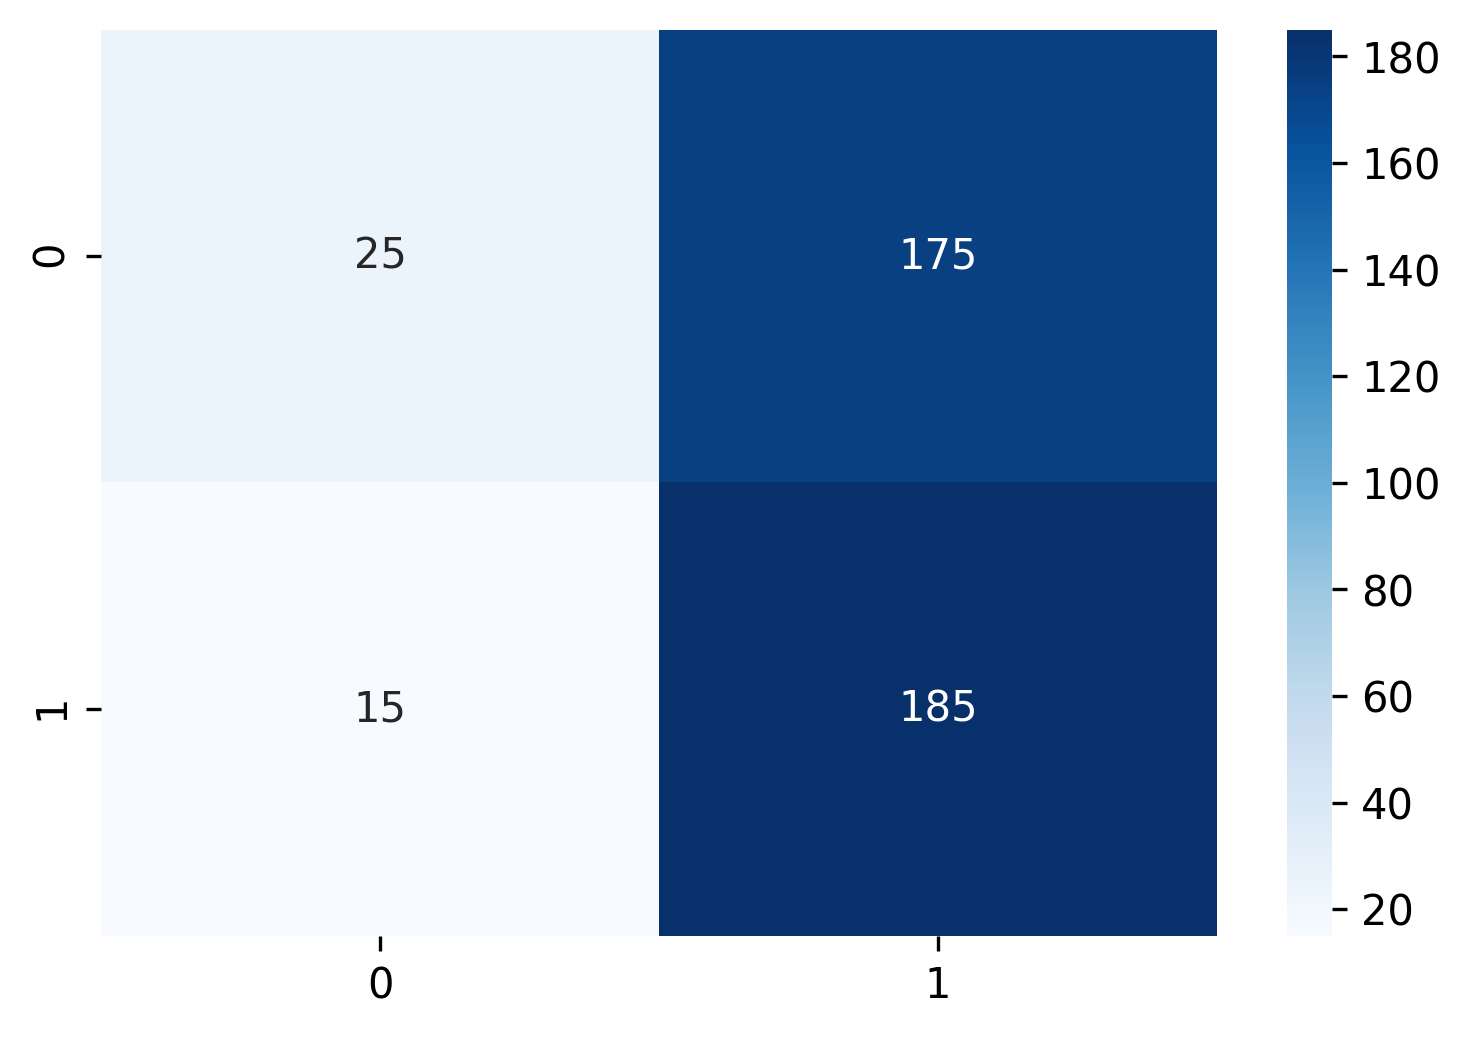

In [ ]:
import seaborn as sns
sns.heatmap(cm_4, annot=True,  fmt='', cmap='Blues', )

## Resnet50V2 Model 5

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs #4
model_5 = keras.Model(inputs, outputs)

# Compile the model
model_5.compile(loss= tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_5 = model_5.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

In [ ]:
# Evaluate on the test data
model_5.evaluate(test_dataset)

In [ ]:
plot_loss_curves(history_5)

### Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_5.predict(image_batch)
   # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
acc = accuracy_score(y_pred=predicted_labels, y_true=correct_labels)
acc

In [ ]:
model_5.evaluate(test_dataset)

In [ ]:
confusion_matrix(y_pred=predicted_labels, y_true=correct_labels)

In [ ]:
test_dataset.class_names

In [ ]:
cm_5 = confusion_matrix(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])
print(cm_5)

In [ ]:
print(classification_report(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0]))

In [ ]:
recall_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

In [ ]:
precision_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

In [ ]:
f1_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

In [ ]:
import seaborn as sns
sns.heatmap(cm_5, annot=True,  fmt='', cmap='Blues', )

## Resnet101 Model 6

In [29]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet101(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs #4
model_6 = keras.Model(inputs, outputs)

# Compile the model
model_6.compile(loss= tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_6 = model_6.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

KeyboardInterrupt: ignored

In [ ]:
# Evaluate on the test data
model_6.evaluate(test_dataset)

In [ ]:
plot_loss_curves(history_6)

### Evaluation

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_6.predict(image_batch)
   # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
acc = accuracy_score(y_pred=predicted_labels, y_true=correct_labels)
acc

In [ ]:
model_6.evaluate(test_dataset)

In [ ]:
confusion_matrix(y_pred=predicted_labels, y_true=correct_labels)

In [ ]:
test_dataset.class_names

In [ ]:
cm_6 = confusion_matrix(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])
print(cm_6)

In [ ]:
print(classification_report(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0]))

In [ ]:
recall_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

In [ ]:
precision_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

In [ ]:
f1_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

In [ ]:
import seaborn as sns
sns.heatmap(cm_6, annot=True,  fmt='', cmap='Blues', )

## Resnet101V2 Model 7

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet101V2(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs #4
model_7 = keras.Model(inputs, outputs)

# Compile the model
model_7.compile(loss= tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_7 = model_7.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

Epoch 1/20
19/19 [==============================] - 14s 421ms/step - loss: 0.7311 - accuracy: 0.5825 - val_loss: 0.6273 - val_accuracy: 0.6575
Epoch 2/20
19/19 [==============================] - 8s 369ms/step - loss: 0.5913 - accuracy: 0.6925 - val_loss: 0.5636 - val_accuracy: 0.6900
Epoch 3/20
19/19 [==============================] - 8s 348ms/step - loss: 0.5037 - accuracy: 0.7533 - val_loss: 0.5119 - val_accuracy: 0.7100
Epoch 4/20
19/19 [==============================] - 8s 368ms/step - loss: 0.4569 - accuracy: 0.7883 - val_loss: 0.4698 - val_accuracy: 0.7475
Epoch 5/20
19/19 [==============================] - 8s 341ms/step - loss: 0.4433 - accuracy: 0.8050 - val_loss: 0.4630 - val_accuracy: 0.7625
Epoch 6/20
19/19 [==============================] - 7s 336ms/step - loss: 0.4137 - accuracy: 0.8258 - val_loss: 0.4375 - val_accuracy: 0.7850
Epoch 7/20
19/19 [==============================] - 8s 361ms/step - loss: 0.4020 - accuracy: 0.8167 - val_loss: 0.4240 - val_accuracy: 0.7850
Epoch

KeyboardInterrupt: ignored

In [ ]:
# Evaluate on the test data
model_7.evaluate(test_dataset)

In [ ]:
plot_loss_curves(history_7)

### Evaluation

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_7.predict(image_batch)
   # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
acc = accuracy_score(y_pred=predicted_labels, y_true=correct_labels)
acc

In [ ]:
model_7.evaluate(test_dataset)

In [ ]:
confusion_matrix(y_pred=predicted_labels, y_true=correct_labels)

In [ ]:
test_dataset.class_names

In [ ]:
cm_7 = confusion_matrix(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])
print(cm_7)

In [ ]:
print(classification_report(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0]))

In [ ]:
recall_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

In [ ]:
precision_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

In [ ]:
f1_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

In [ ]:
import seaborn as sns
sns.heatmap(cm_7, annot=True,  fmt='', cmap='Blues', )

## ResNet152 Model 8

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet152(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs #4
model_8 = keras.Model(inputs, outputs)

# Compile the model
model_8.compile(loss= tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_8 = model_8.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

234708992/234698864 [==============================] - 10s 0us/step
Epoch 1/20
19/19 [==============================] - 19s 560ms/step - loss: 0.7459 - accuracy: 0.4900 - val_loss: 0.7415 - val_accuracy: 0.5000
Epoch 2/20
19/19 [==============================] - 10s 460ms/step - loss: 0.7024 - accuracy: 0.5117 - val_loss: 0.7025 - val_accuracy: 0.5000
Epoch 3/20
19/19 [==============================] - 10s 462ms/step - loss: 0.7067 - accuracy: 0.5075 - val_loss: 0.7048 - val_accuracy: 0.5000
Epoch 4/20
19/19 [==============================] - 10s 493ms/step - loss: 0.7319 - accuracy: 0.4658 - val_loss: 0.6900 - val_accuracy: 0.5025
Epoch 5/20
19/19 [==============================] - 10s 470ms/step - loss: 0.7331 - accuracy: 0.5050 - val_loss: 0.6901 - val_accuracy: 0.5000
Epoch 6/20
19/19 [==============================] - 10s 465ms/step - loss: 0.7109 - accuracy: 0.4992 - val_loss: 0.6933 - val_accuracy: 0.4975
Epoch 7/20
19/19 [==============================] - 10s 467ms/step - loss:

In [ ]:
# Evaluate on the test data
model_8.evaluate(test_dataset)

7/7 [==============================] - 2s 215ms/step - loss: 0.6915 - accuracy: 0.5125


[0.6914576888084412, 0.512499988079071]

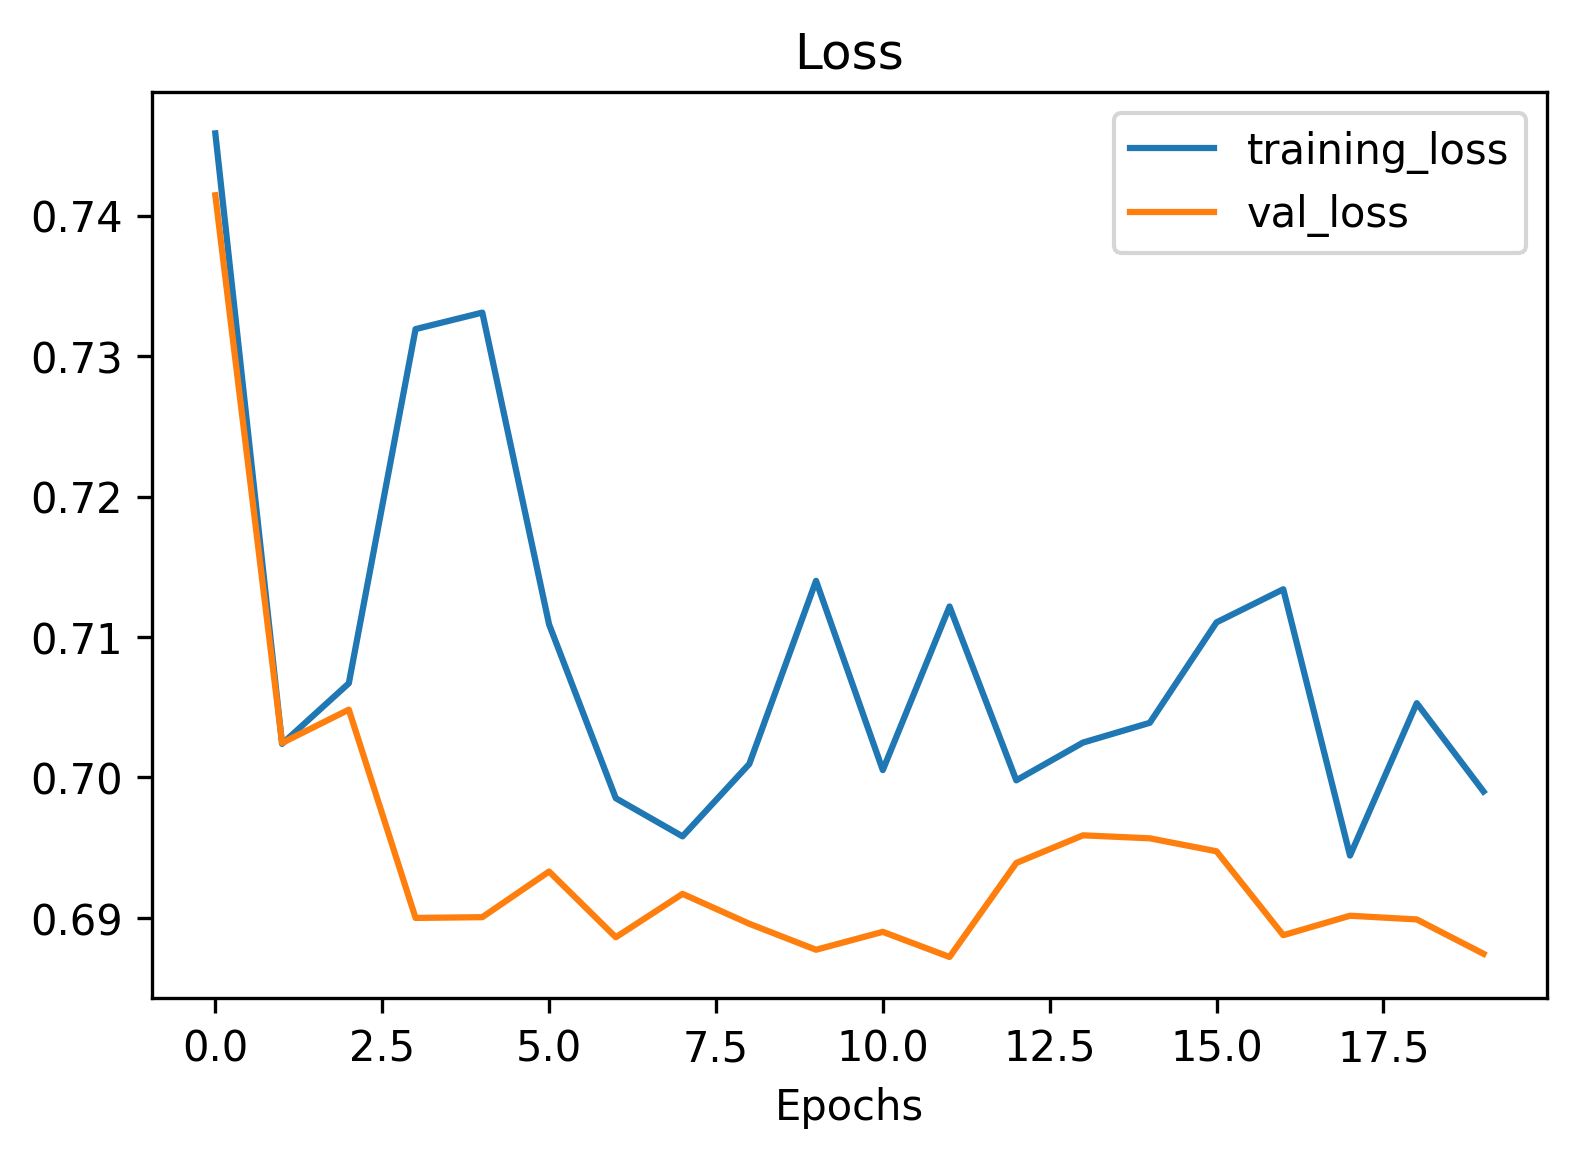

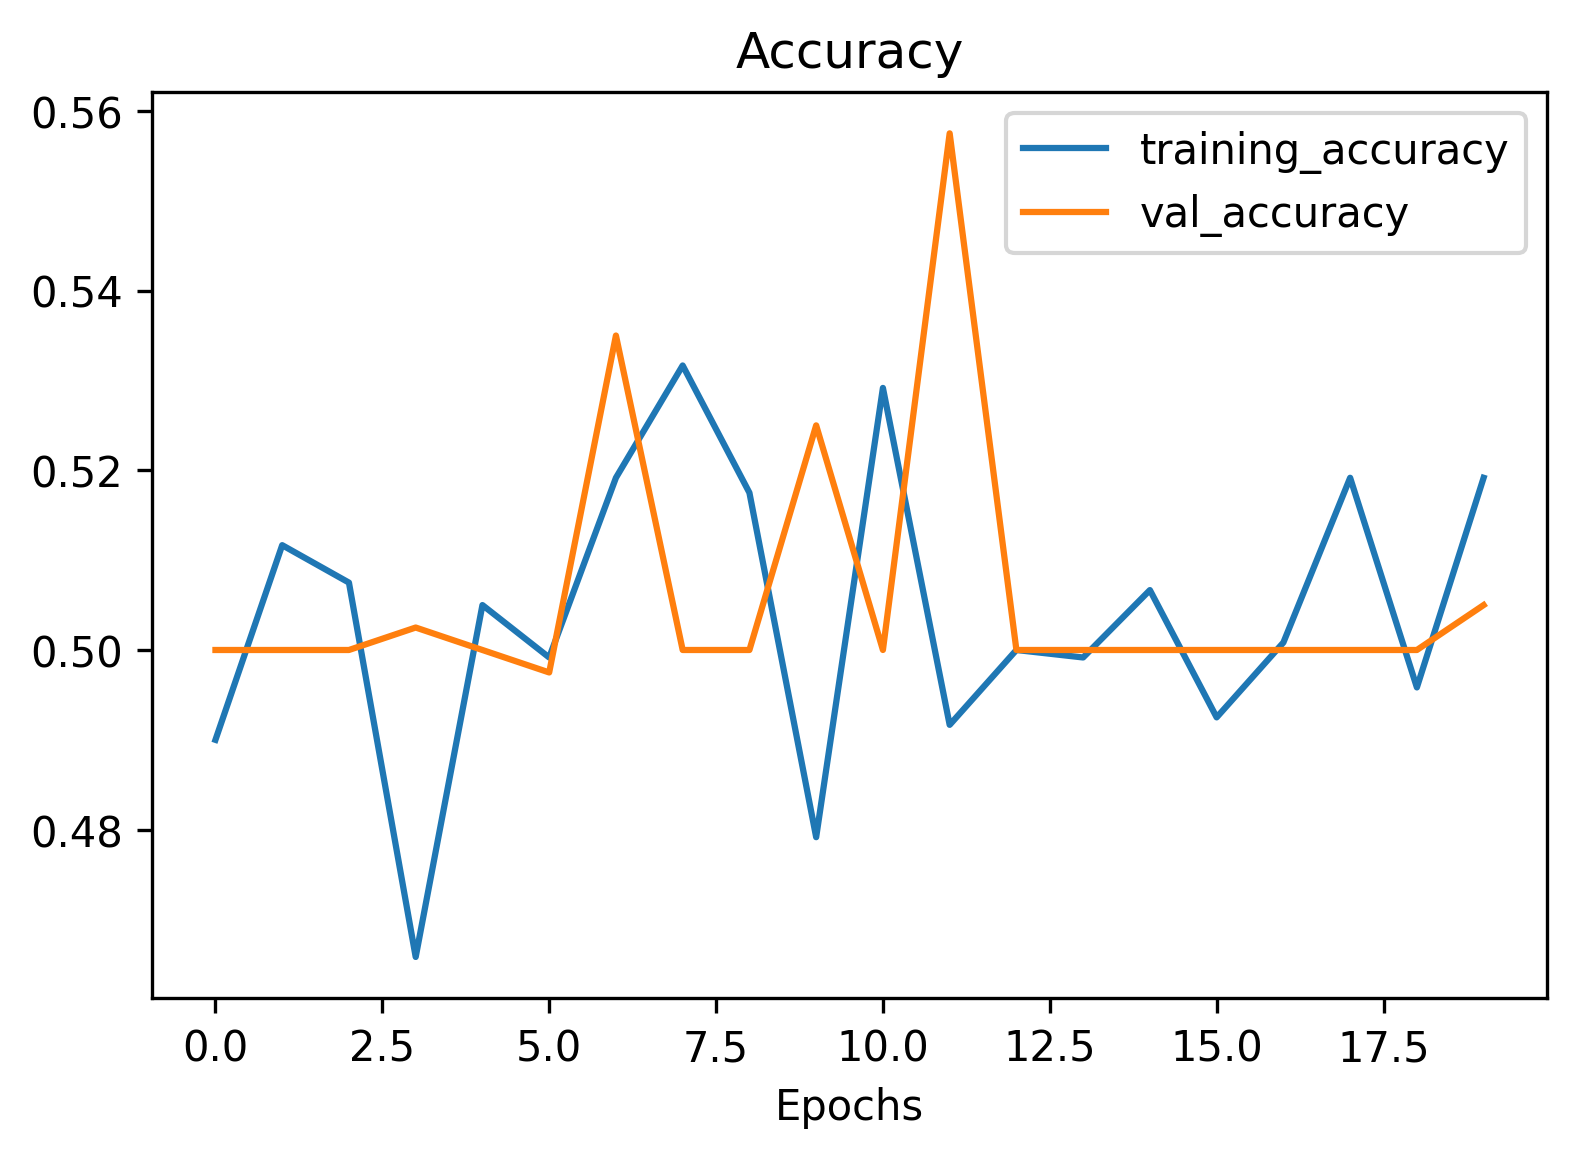

In [ ]:
plot_loss_curves(history_8)

### Evaluation

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_8.predict(image_batch)
   # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
acc = accuracy_score(y_pred=predicted_labels, y_true=correct_labels)
acc

0.5125

In [ ]:
model_8.evaluate(test_dataset)

7/7 [==============================] - 2s 214ms/step - loss: 0.6915 - accuracy: 0.5125


[0.6914576888084412, 0.512499988079071]

In [ ]:
confusion_matrix(y_pred=predicted_labels, y_true=correct_labels)

array([[  6, 194],
       [  1, 199]])

In [ ]:
test_dataset.class_names

['dyed-lifted-polyps', 'dyed-resection-margins']

In [ ]:
cm_8 = confusion_matrix(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])
print(cm_8)

[[199   1]
 [194   6]]


In [ ]:
print(classification_report(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.51      0.99      0.67       200
           0       0.86      0.03      0.06       200

    accuracy                           0.51       400
   macro avg       0.68      0.51      0.36       400
weighted avg       0.68      0.51      0.36       400



In [ ]:
recall_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.995

In [ ]:
precision_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.5063613231552163

In [ ]:
f1_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.6711635750421585

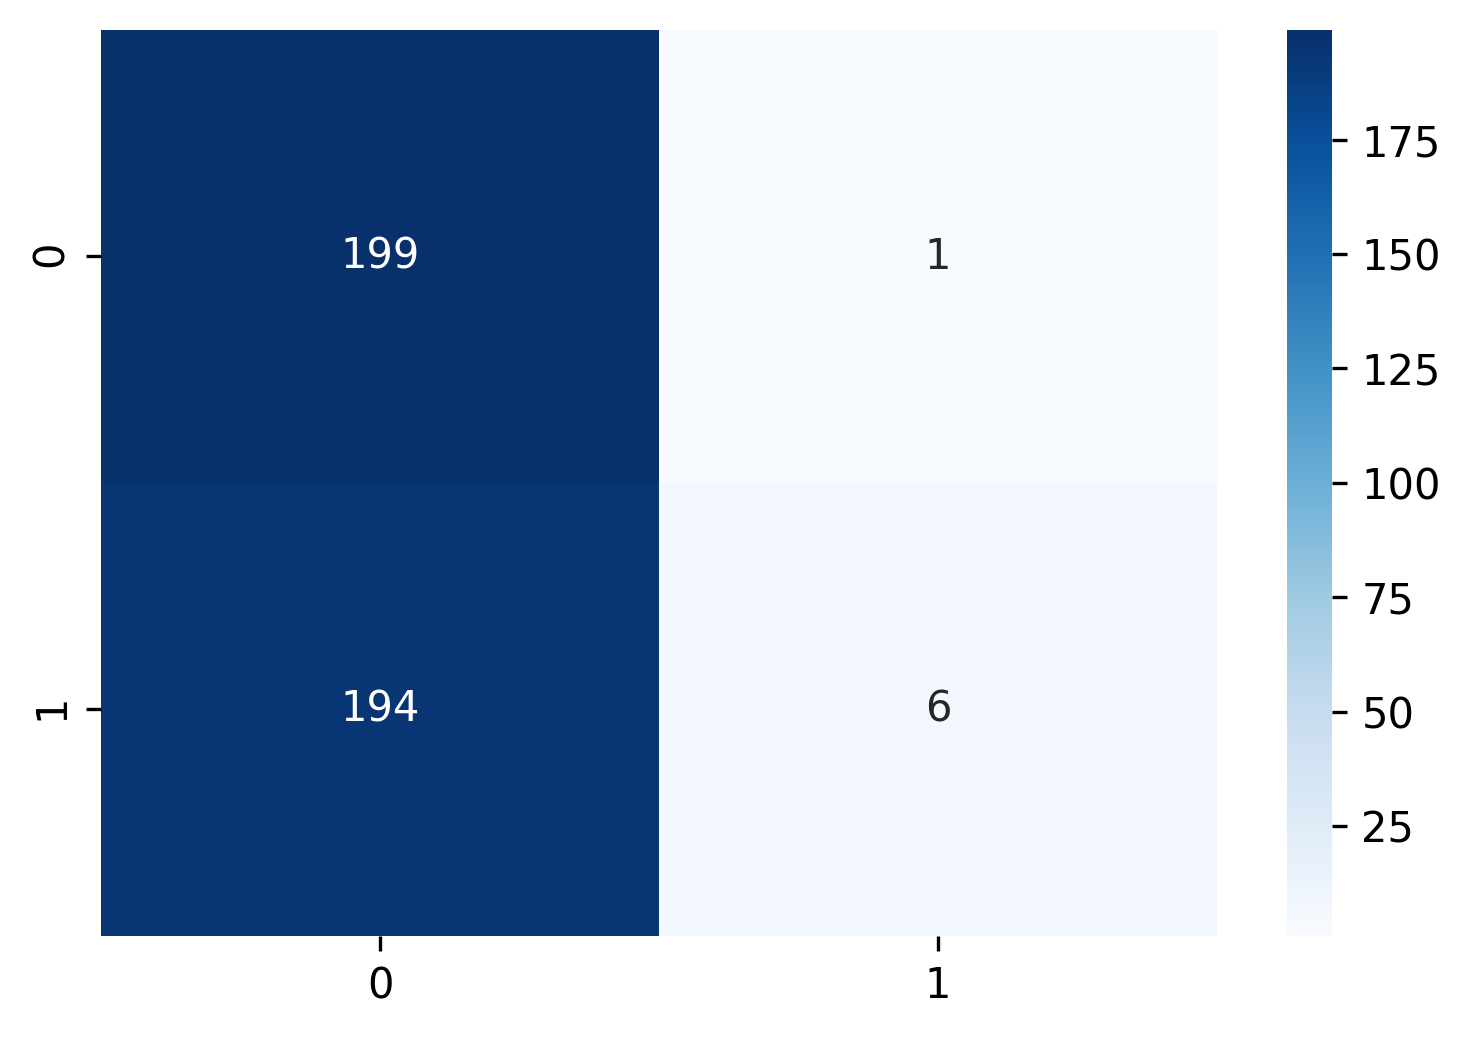

In [ ]:
import seaborn as sns
sns.heatmap(cm_8, annot=True,  fmt='', cmap='Blues', )

## Resnet152V2 Model 9

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet152V2(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs #4
model_9 = keras.Model(inputs, outputs)

# Compile the model
model_9.compile(loss= tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_9 = model_9.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

234561536/234545216 [==============================] - 11s 0us/step
Epoch 1/20
19/19 [==============================] - 18s 534ms/step - loss: 0.6256 - accuracy: 0.6558 - val_loss: 0.5420 - val_accuracy: 0.7275
Epoch 2/20
19/19 [==============================] - 9s 440ms/step - loss: 0.5129 - accuracy: 0.7433 - val_loss: 0.4541 - val_accuracy: 0.7650
Epoch 3/20
19/19 [==============================] - 9s 427ms/step - loss: 0.4587 - accuracy: 0.7808 - val_loss: 0.4353 - val_accuracy: 0.7850
Epoch 4/20
19/19 [==============================] - 9s 438ms/step - loss: 0.4489 - accuracy: 0.7842 - val_loss: 0.4082 - val_accuracy: 0.8075
Epoch 5/20
19/19 [==============================] - 10s 458ms/step - loss: 0.4330 - accuracy: 0.7983 - val_loss: 0.3965 - val_accuracy: 0.8100
Epoch 6/20
19/19 [==============================] - 10s 445ms/step - loss: 0.4279 - accuracy: 0.8067 - val_loss: 0.3895 - val_accuracy: 0.8050
Epoch 7/20
19/19 [==============================] - 9s 419ms/step - loss: 0.4

In [ ]:
# Evaluate on the test data
model_9.evaluate(test_dataset)

7/7 [==============================] - 2s 155ms/step - loss: 0.6857 - accuracy: 0.5425


[0.6856676340103149, 0.5425000190734863]

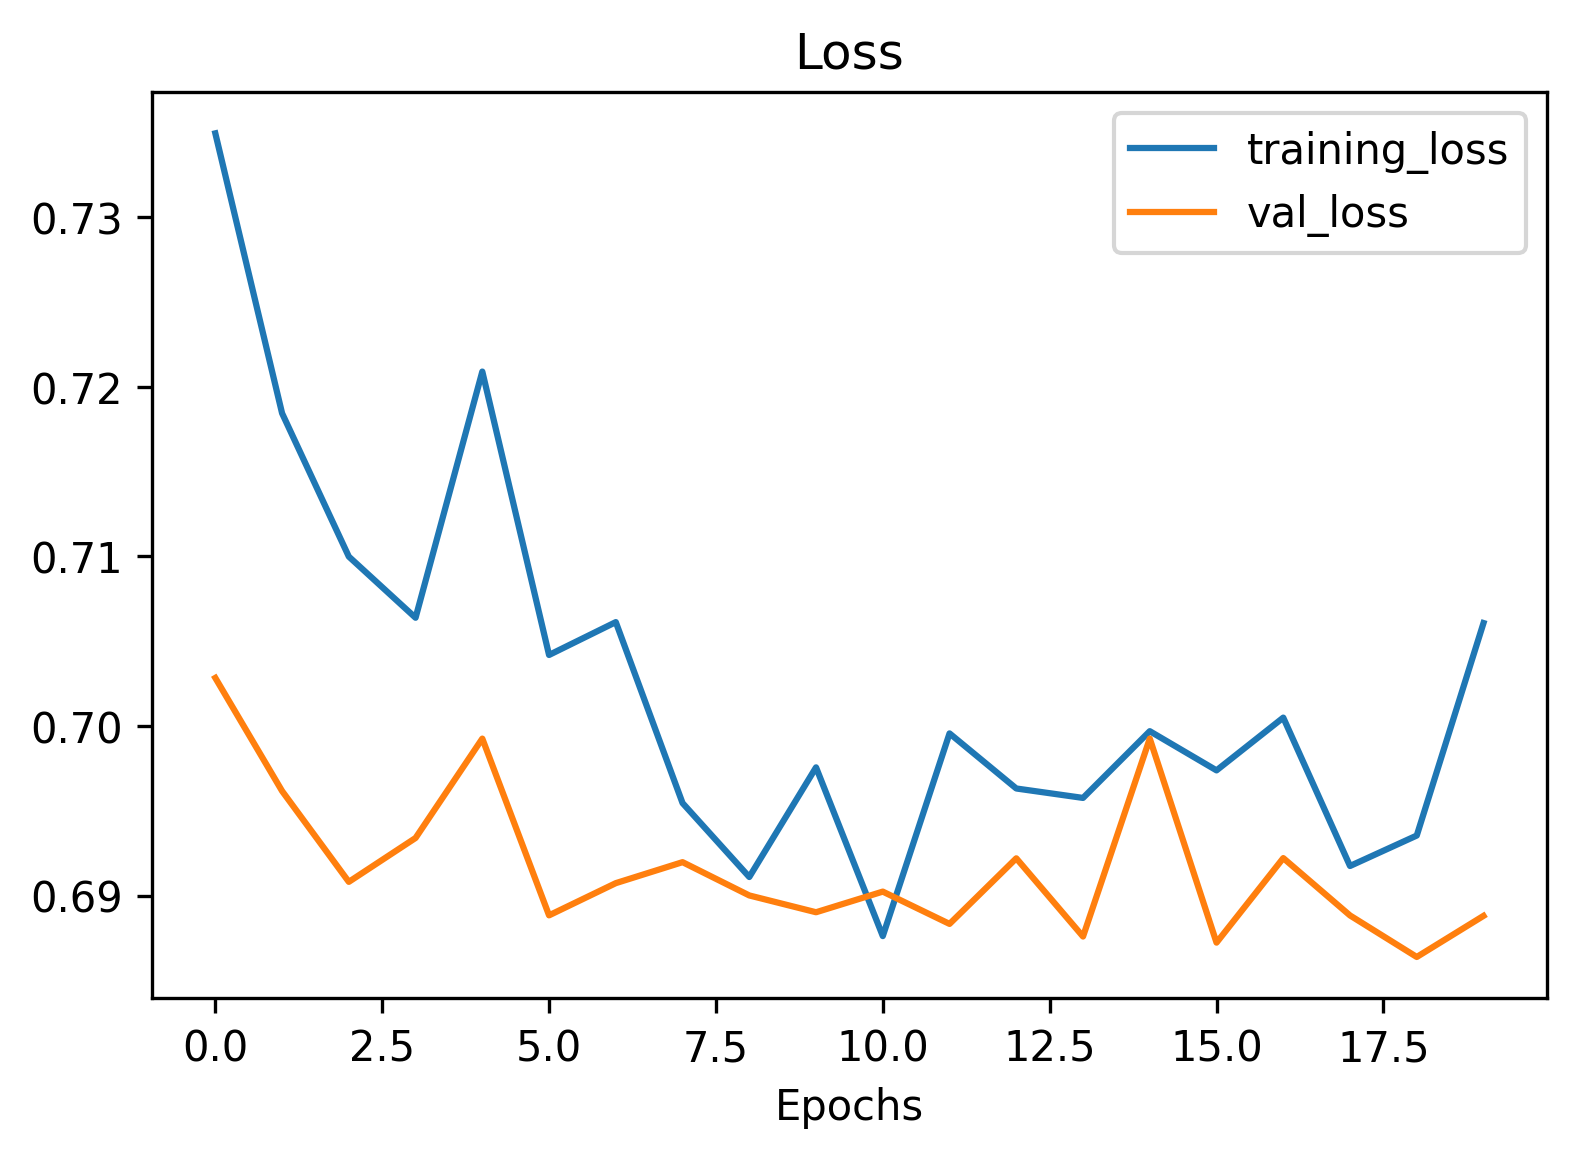

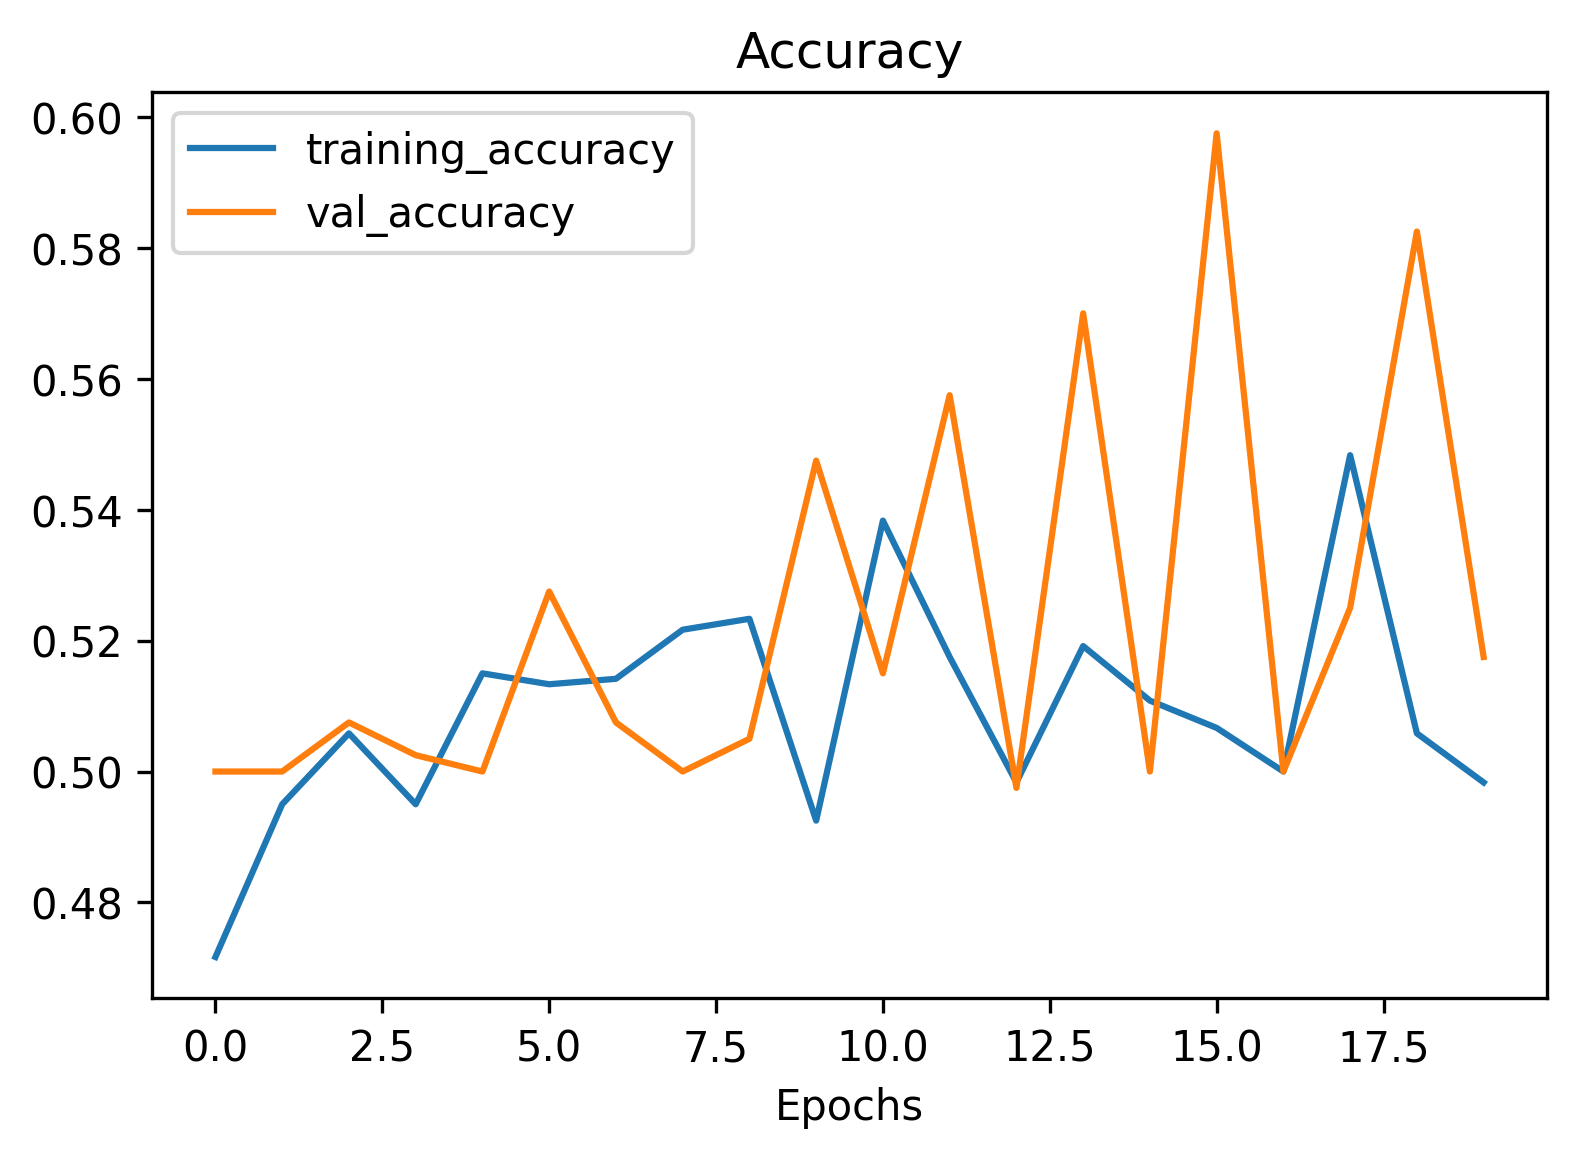

In [ ]:
plot_loss_curves(history_9)

### Evaluation

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_9.predict(image_batch)
   # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
acc = accuracy_score(y_pred=predicted_labels, y_true=correct_labels)
acc

0.825

In [ ]:
model_9.evaluate(test_dataset)

7/7 [==============================] - 2s 215ms/step - loss: 0.3881 - accuracy: 0.8250


[0.38810592889785767, 0.824999988079071]

In [ ]:
confusion_matrix(y_pred=predicted_labels, y_true=correct_labels)

array([[170,  30],
       [ 40, 160]])

In [ ]:
test_dataset.class_names

['dyed-lifted-polyps', 'dyed-resection-margins']

In [ ]:
cm_9 = confusion_matrix(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])
print(cm_9)

[[160  40]
 [ 30 170]]


In [ ]:
print(classification_report(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.84      0.80      0.82       200
           0       0.81      0.85      0.83       200

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



In [ ]:
recall_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.8

In [ ]:
precision_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.8421052631578947

In [ ]:
f1_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.8205128205128205

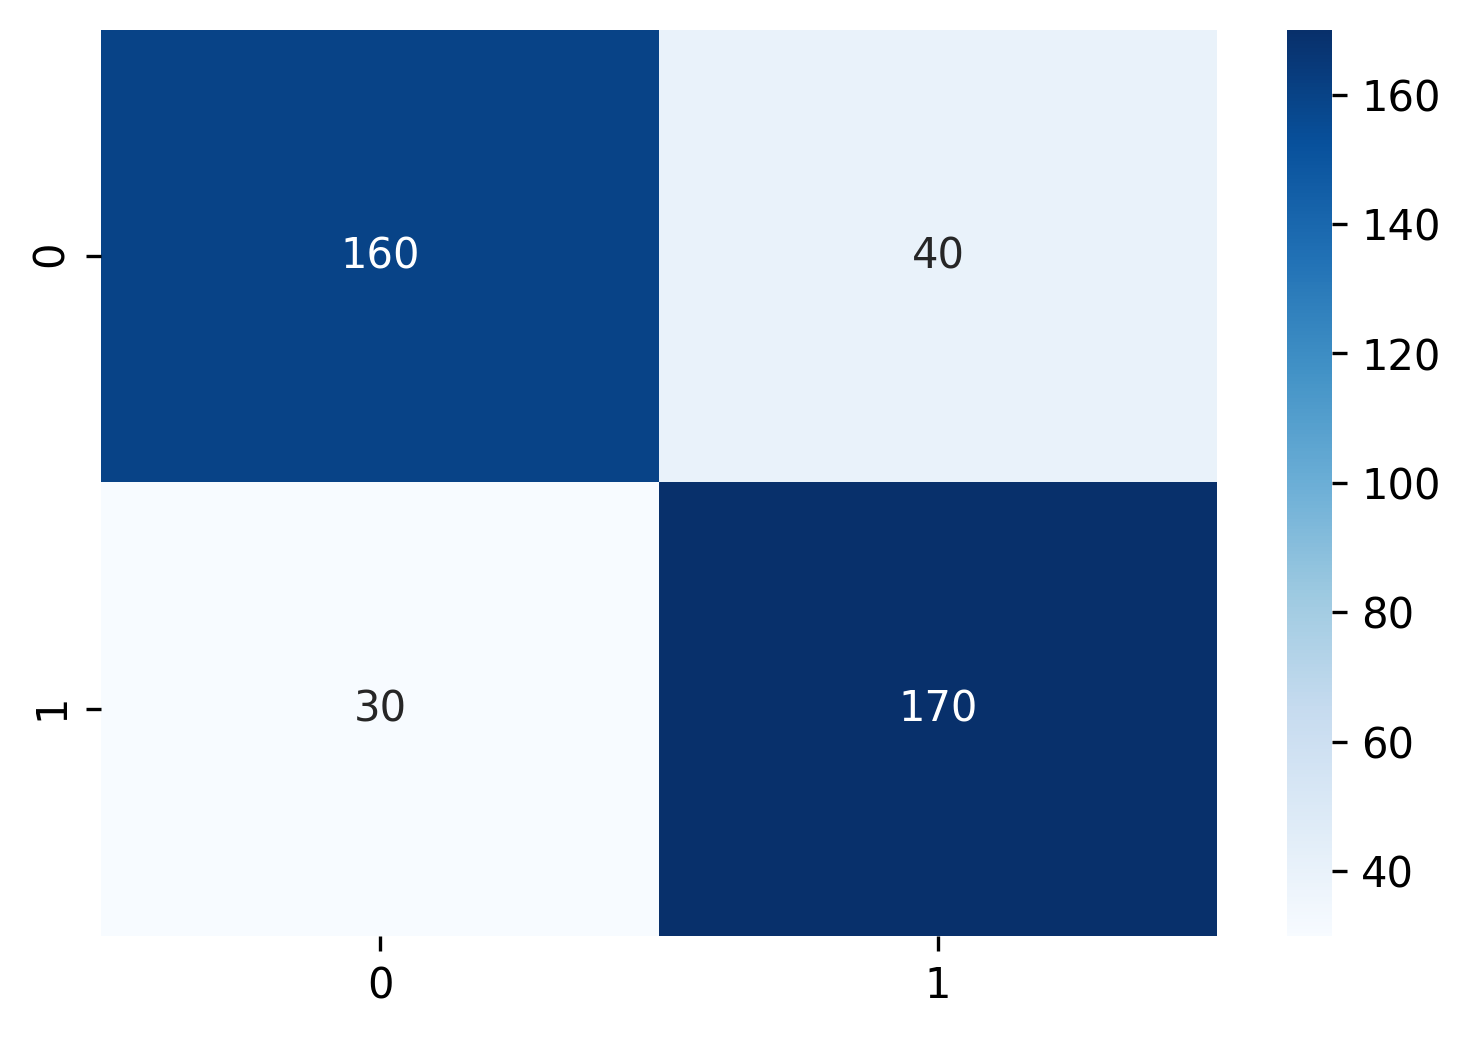

In [ ]:
import seaborn as sns
sns.heatmap(cm_9, annot=True,  fmt='', cmap='Blues', )

# VGG

## VGG16 Model 10

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.VGG16(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs #4
model_10 = keras.Model(inputs, outputs)

# Compile the model
model_10.compile(loss= tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_10 = model_10.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

58900480/58889256 [==============================] - 2s 0us/step
Epoch 1/20
19/19 [==============================] - 93s 5s/step - loss: 0.6967 - accuracy: 0.5075 - val_loss: 0.6864 - val_accuracy: 0.5275
Epoch 2/20
19/19 [==============================] - 82s 4s/step - loss: 0.6867 - accuracy: 0.5600 - val_loss: 0.6770 - val_accuracy: 0.6025
Epoch 3/20
19/19 [==============================] - 83s 4s/step - loss: 0.6733 - accuracy: 0.6408 - val_loss: 0.6678 - val_accuracy: 0.6875
Epoch 4/20
19/19 [==============================] - 80s 4s/step - loss: 0.6627 - accuracy: 0.6683 - val_loss: 0.6594 - val_accuracy: 0.7100
Epoch 5/20
19/19 [==============================] - 79s 4s/step - loss: 0.6543 - accuracy: 0.6975 - val_loss: 0.6516 - val_accuracy: 0.7225
Epoch 6/20
19/19 [==============================] - 60s 3s/step - loss: 0.6473 - accuracy: 0.7208 - val_loss: 0.6445 - val_accuracy: 0.7400
Epoch 7/20
19/19 [==============================] - 61s 3s/step - loss: 0.6417 - accuracy: 0.68

In [ ]:
# Evaluate on the test data
model_10.evaluate(test_dataset)

7/7 [==============================] - 2s 112ms/step - loss: 0.5924 - accuracy: 0.7600


[0.5923778414726257, 0.7599999904632568]

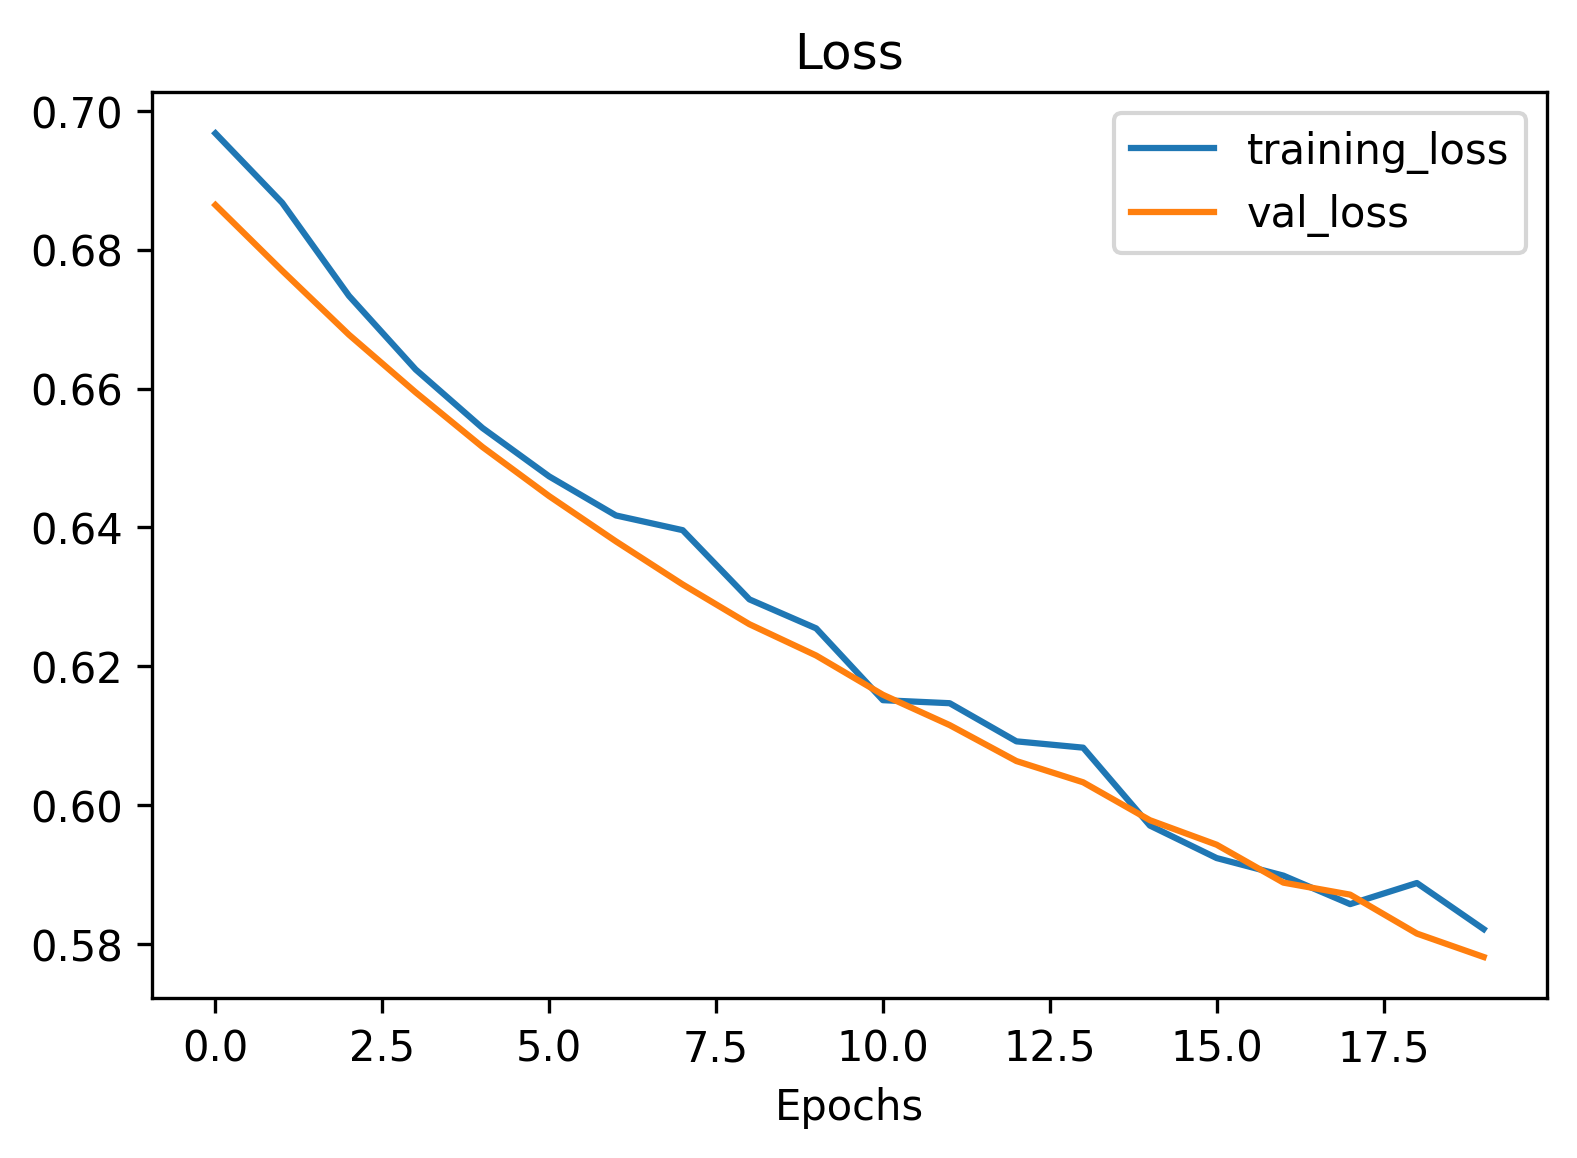

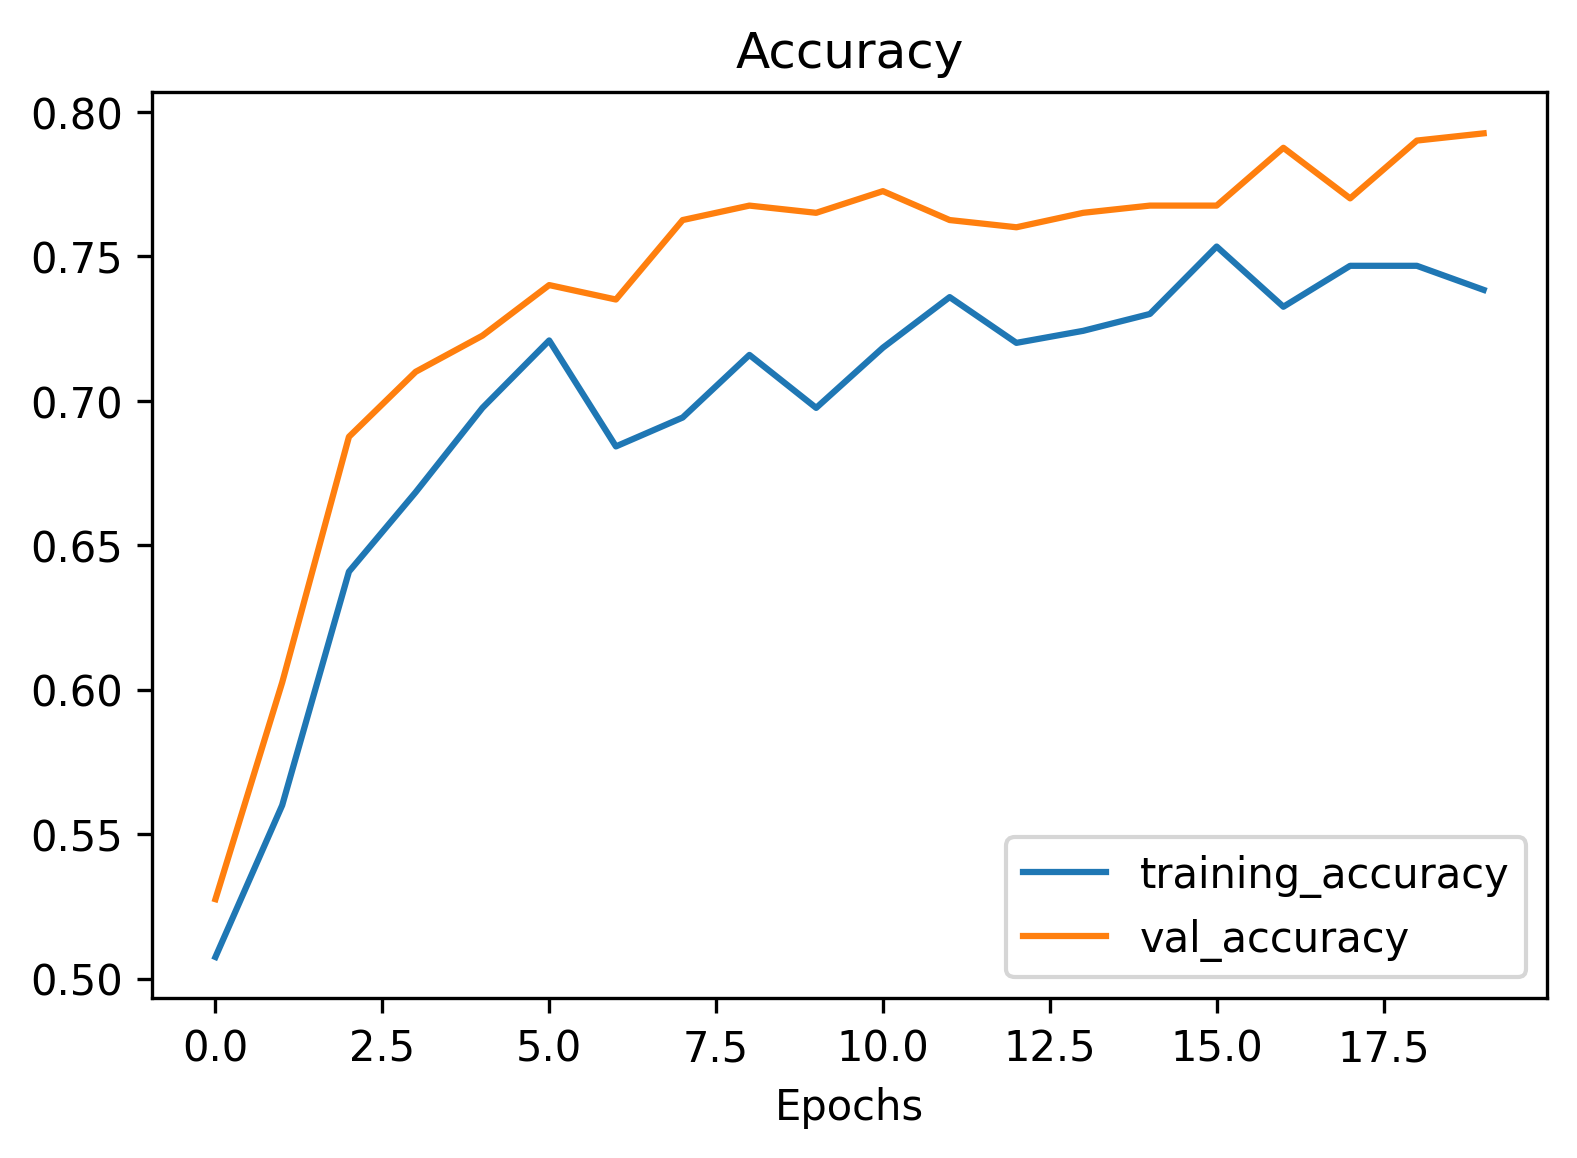

In [ ]:
plot_loss_curves(history_10)

### Evaluation

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_10.predict(image_batch)
   # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
acc = accuracy_score(y_pred=predicted_labels, y_true=correct_labels)
acc

0.76

In [ ]:
model_10.evaluate(test_dataset)

7/7 [==============================] - 2s 110ms/step - loss: 0.5924 - accuracy: 0.7600


[0.5923778414726257, 0.7599999904632568]

In [ ]:
confusion_matrix(y_pred=predicted_labels, y_true=correct_labels)

array([[155,  45],
       [ 51, 149]])

In [ ]:
test_dataset.class_names

['dyed-lifted-polyps', 'dyed-resection-margins']

In [ ]:
cm_10 = confusion_matrix(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])
print(cm_10)

[[149  51]
 [ 45 155]]


In [ ]:
print(classification_report(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.77      0.74      0.76       200
           0       0.75      0.78      0.76       200

    accuracy                           0.76       400
   macro avg       0.76      0.76      0.76       400
weighted avg       0.76      0.76      0.76       400



In [ ]:
recall_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.745

In [ ]:
precision_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.7680412371134021

In [ ]:
f1_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.7563451776649747

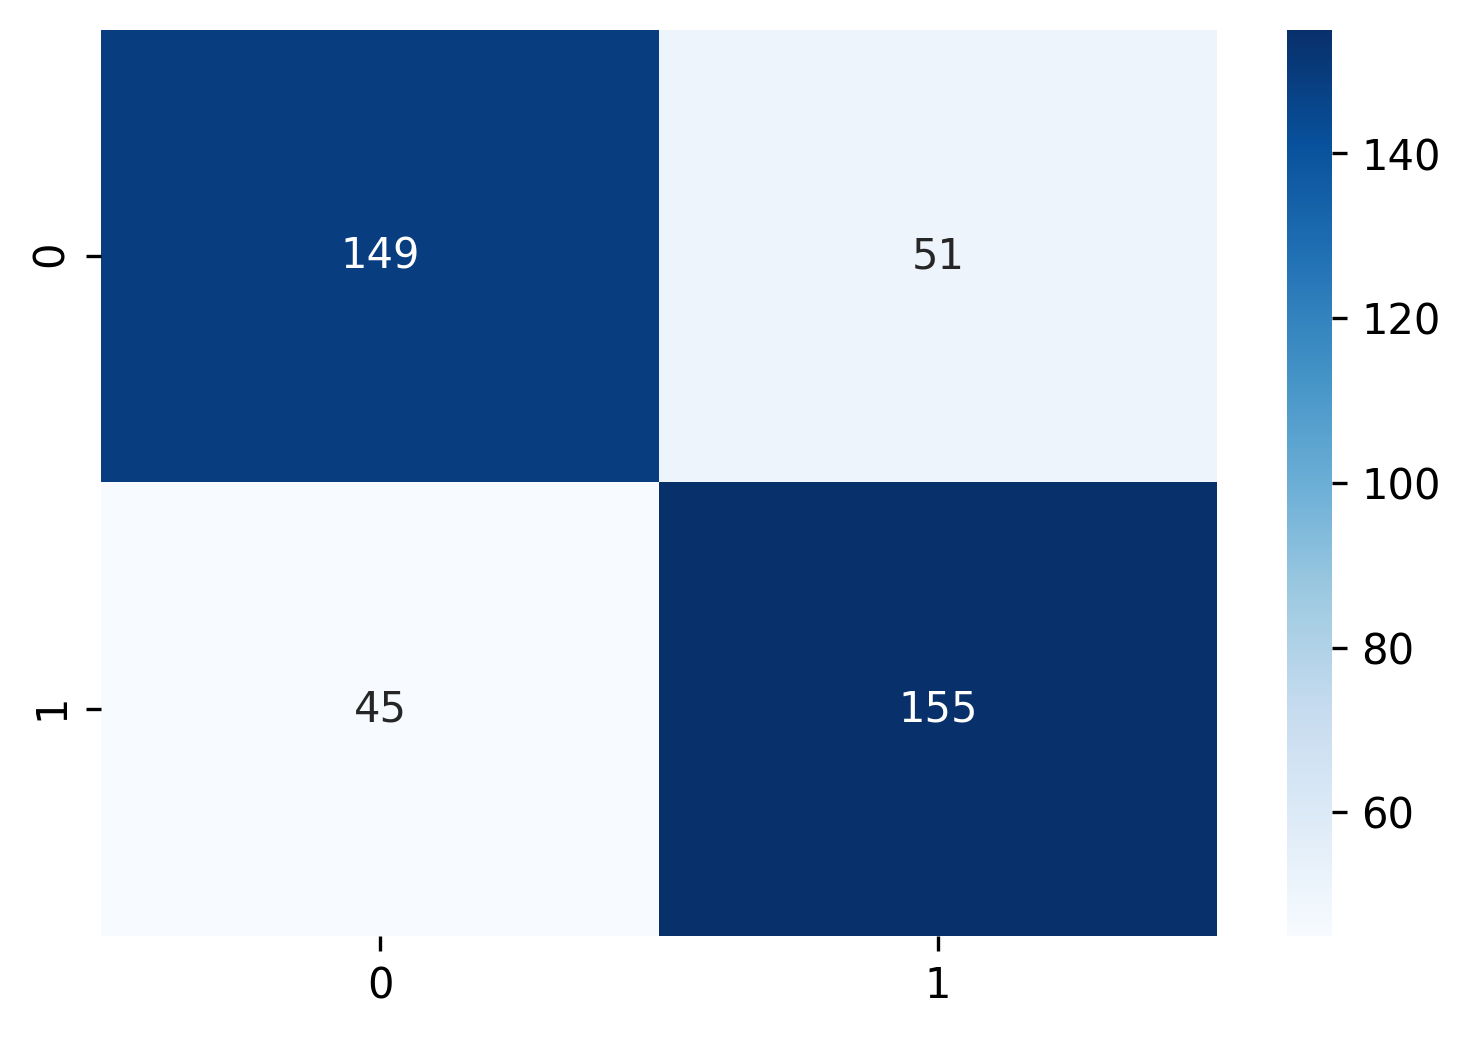

In [ ]:
import seaborn as sns
sns.heatmap(cm_10, annot=True,  fmt='', cmap='Blues', )

## VGG19 Model 11

In [13]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.VGG19(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs #4
model_11 = keras.Model(inputs, outputs)

# Compile the model
model_11.compile(loss= tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_11 = model_11.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

Epoch 1/20
19/19 [==============================] - 132s 7s/step - loss: 0.6849 - accuracy: 0.5383 - val_loss: 0.6777 - val_accuracy: 0.6000
Epoch 2/20
19/19 [==============================] - 82s 4s/step - loss: 0.6766 - accuracy: 0.5825 - val_loss: 0.6713 - val_accuracy: 0.6300
Epoch 3/20
19/19 [==============================] - 87s 5s/step - loss: 0.6730 - accuracy: 0.5867 - val_loss: 0.6665 - val_accuracy: 0.6125
Epoch 4/20
19/19 [==============================] - 81s 4s/step - loss: 0.6633 - accuracy: 0.6233 - val_loss: 0.6611 - val_accuracy: 0.6275
Epoch 5/20
19/19 [==============================] - 70s 4s/step - loss: 0.6555 - accuracy: 0.6450 - val_loss: 0.6583 - val_accuracy: 0.6425
Epoch 6/20
19/19 [==============================] - 74s 4s/step - loss: 0.6539 - accuracy: 0.6267 - val_loss: 0.6511 - val_accuracy: 0.6525
Epoch 7/20
19/19 [==============================] - 68s 4s/step - loss: 0.6471 - accuracy: 0.6592 - val_loss: 0.6485 - val_accuracy: 0.6525
Epoch 8/20
19/19 [=

In [14]:
# Evaluate on the test data
model_11.evaluate(test_dataset)

7/7 [==============================] - 24s 130ms/step - loss: 0.6028 - accuracy: 0.7125


[0.6028104424476624, 0.7124999761581421]

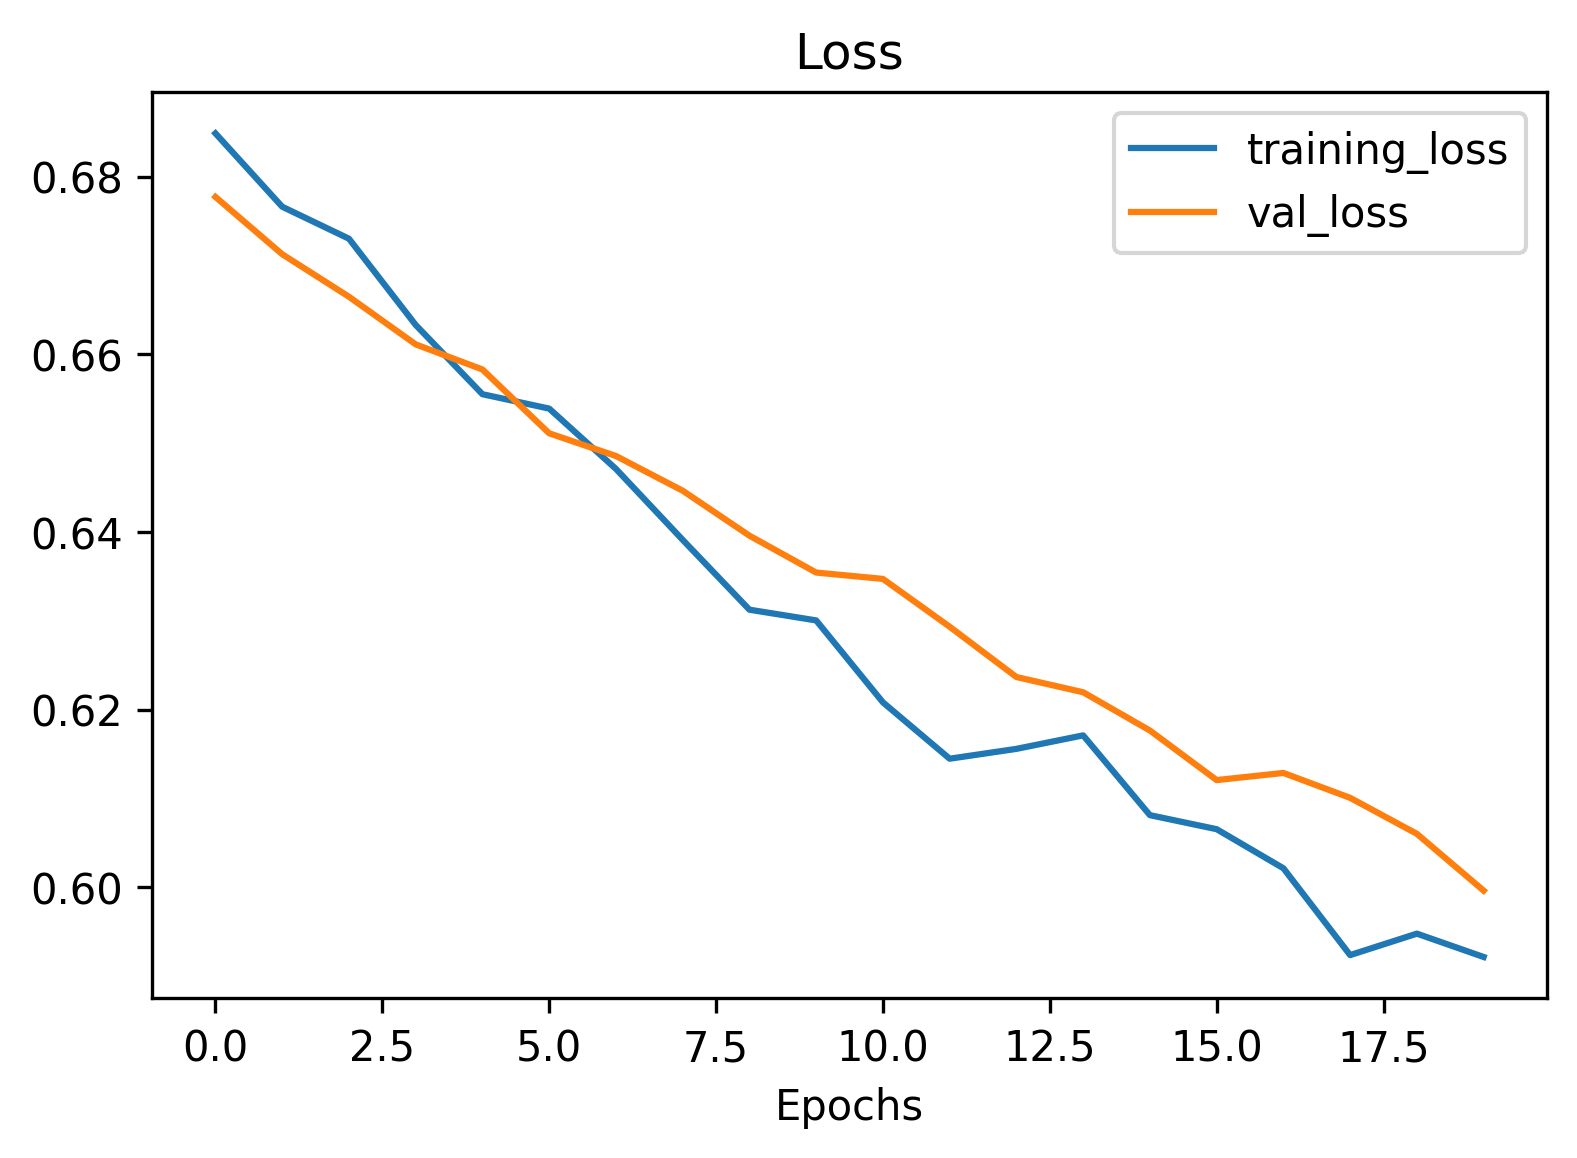

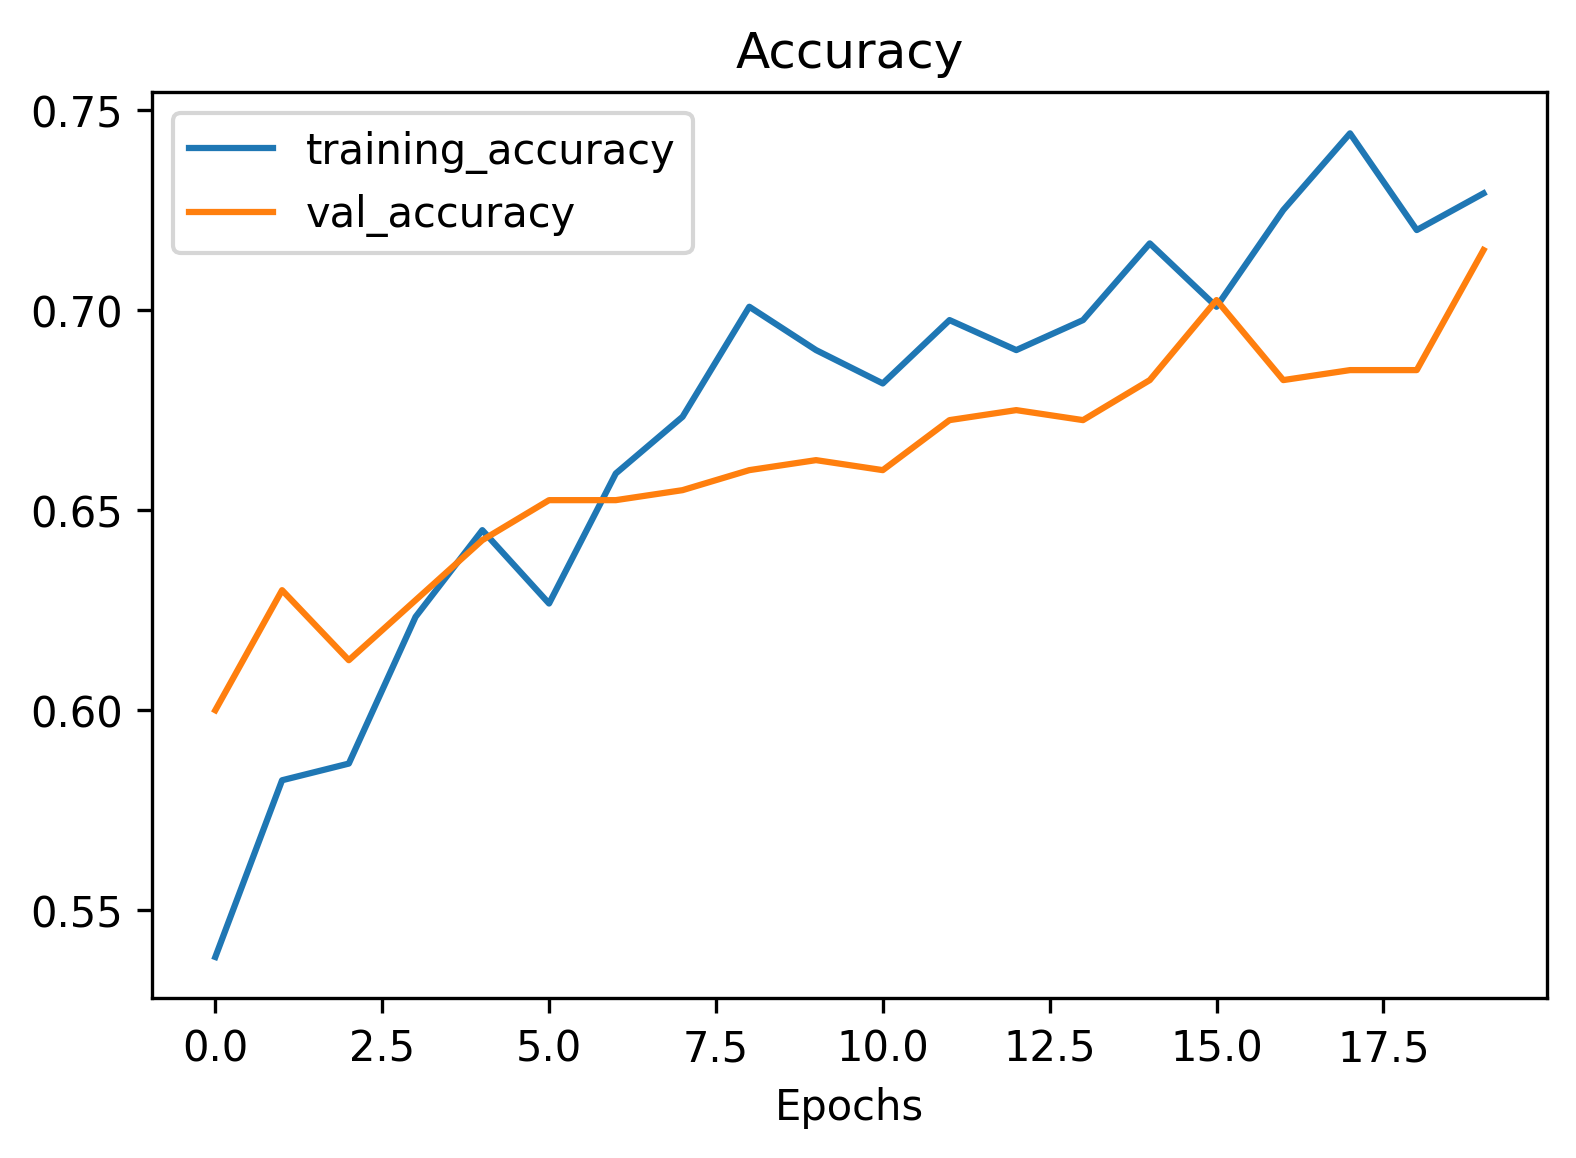

In [46]:
plot_loss_curves(history_11)

### Evaluation

In [16]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [17]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_11.predict(image_batch)
   # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [18]:
acc = accuracy_score(y_pred=predicted_labels, y_true=correct_labels)
acc

0.7125

In [19]:
model_11.evaluate(test_dataset)

7/7 [==============================] - 2s 131ms/step - loss: 0.6028 - accuracy: 0.7125


[0.6028103828430176, 0.7124999761581421]

In [20]:
confusion_matrix(y_pred=predicted_labels, y_true=correct_labels)

array([[117,  83],
       [ 32, 168]])

In [21]:
test_dataset.class_names

['dyed-lifted-polyps', 'dyed-resection-margins']

In [22]:
cm_11 = confusion_matrix(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])
print(cm_11)

[[168  32]
 [ 83 117]]


In [23]:
print(classification_report(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.67      0.84      0.75       200
           0       0.79      0.58      0.67       200

    accuracy                           0.71       400
   macro avg       0.73      0.71      0.71       400
weighted avg       0.73      0.71      0.71       400



In [24]:
recall_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.84

In [25]:
precision_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.6693227091633466

In [26]:
f1_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.7450110864745011

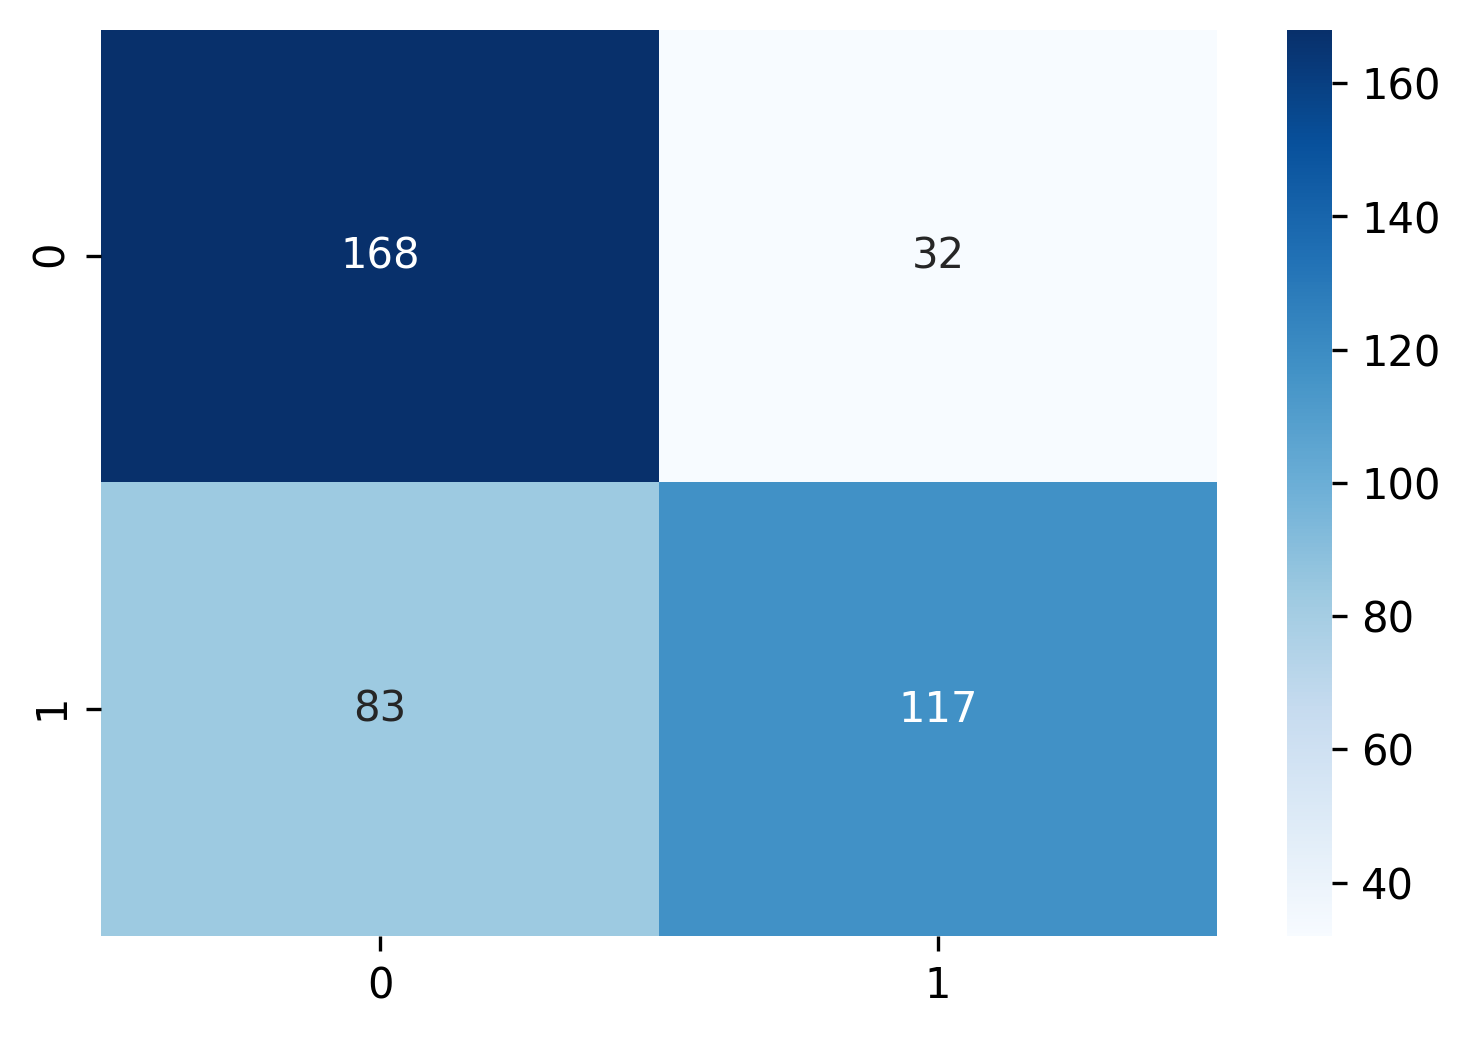

In [27]:
import seaborn as sns
sns.heatmap(cm_11, annot=True,  fmt='', cmap='Blues', )

# MobileNetV2 Model 12

In [32]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(include_top=False)
base_model.trainable = False
# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs #4
model_12 = keras.Model(inputs, outputs)

# Compile the model
model_12.compile(loss= tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_12 = model_12.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/20
19/19 [==============================] - 10s 352ms/step - loss: 0.7026 - accuracy: 0.5842 - val_loss: 0.6175 - val_accuracy: 0.6575
Epoch 2/20
19/19 [==============================] - 7s 287ms/step - loss: 0.5711 - accuracy: 0.7000 - val_loss: 0.5369 - val_accuracy: 0.7175
Epoch 3/20
19/19 [==============================] - 6s 264ms/step - loss: 0.4930 - accuracy: 0.7658 - val_loss: 0.5127 - val_accuracy: 0.7350
Epoch 4/20
19/19 [==============================] - 6s 263ms/step - loss: 0.4547 - accuracy: 0.7825 - val_loss: 0.4709 - val_accuracy: 0.7775
Epoch 5/20
19/19 [==============================] - 6s 258ms/step - loss: 0.4485 - accuracy: 0.7950 - val_loss: 0.4567 - val_accuracy: 0.7925
Epoch 6/20
19/19 [==============================] - 6s 251ms/step - loss: 0.4143 - accuracy: 0.8233 - val_loss: 0.4458 - val_accuracy: 0.7900
Epoch 7/20
19/19 [==============================] - 6s 248ms/step - loss: 0.4153 - a

In [33]:
# Evaluate on the test data
model_12.evaluate(test_dataset)

7/7 [==============================] - 1s 56ms/step - loss: 0.4029 - accuracy: 0.8025


[0.4028956890106201, 0.8025000095367432]

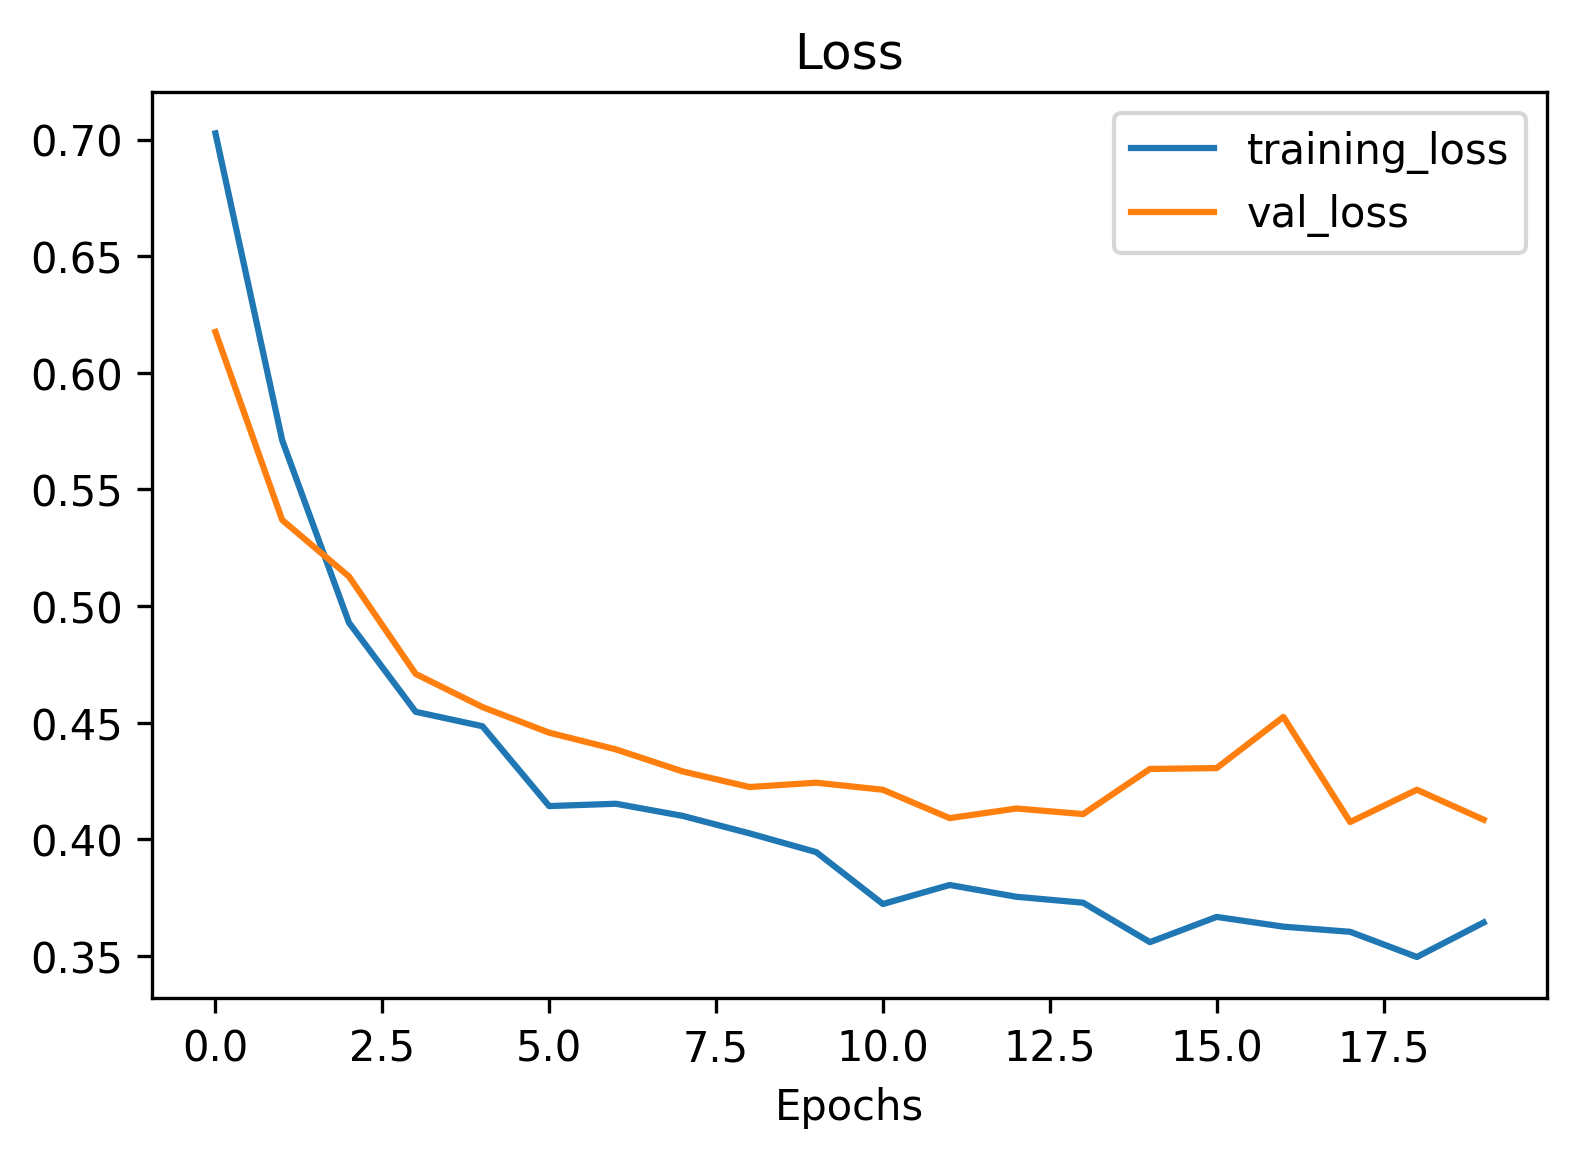

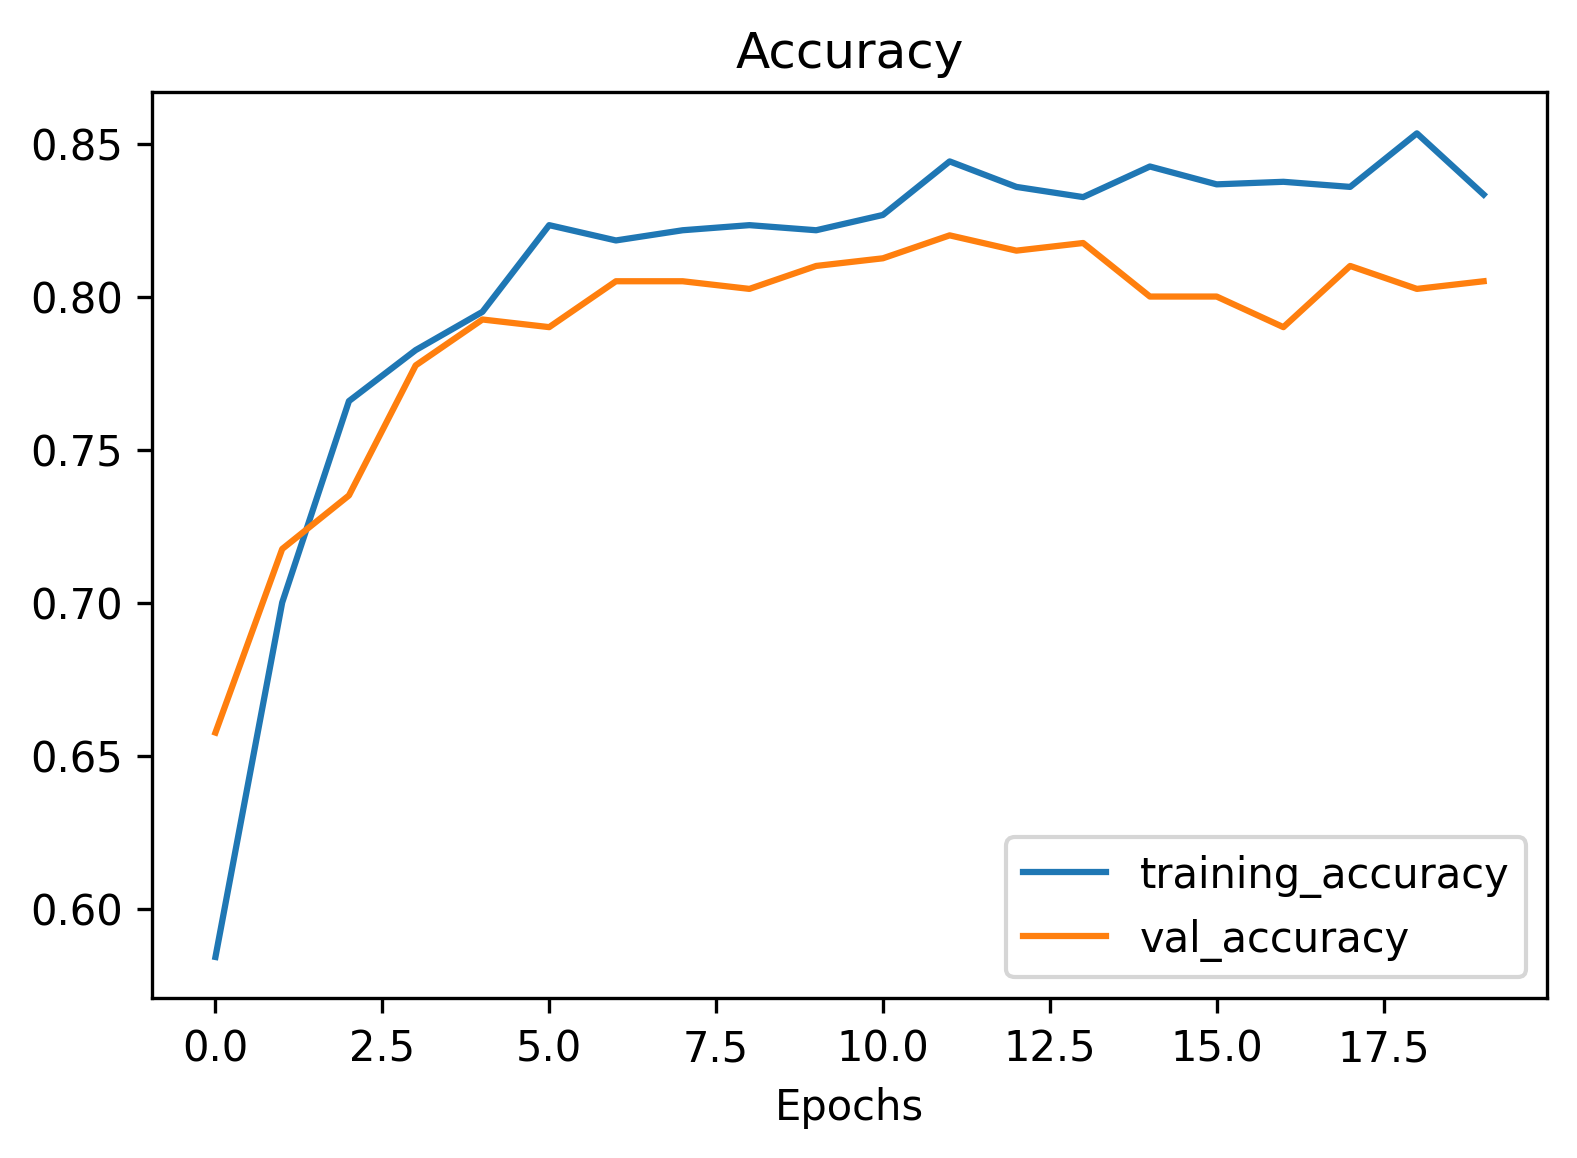

In [34]:
plot_loss_curves(history_12)

### Evaluation

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [35]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_12.predict(image_batch)
   # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [36]:
acc = accuracy_score(y_pred=predicted_labels, y_true=correct_labels)
acc

0.8025

In [37]:
model_12.evaluate(test_dataset)

7/7 [==============================] - 1s 56ms/step - loss: 0.4029 - accuracy: 0.8025


[0.4028956890106201, 0.8025000095367432]

In [38]:
confusion_matrix(y_pred=predicted_labels, y_true=correct_labels)

array([[180,  20],
       [ 59, 141]])

In [39]:
test_dataset.class_names

['dyed-lifted-polyps', 'dyed-resection-margins']

In [40]:
cm_12 = confusion_matrix(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])
print(cm_12)

[[141  59]
 [ 20 180]]


In [41]:
print(classification_report(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.88      0.70      0.78       200
           0       0.75      0.90      0.82       200

    accuracy                           0.80       400
   macro avg       0.81      0.80      0.80       400
weighted avg       0.81      0.80      0.80       400



In [42]:
recall_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.705

In [43]:
precision_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.8757763975155279

In [44]:
f1_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.7811634349030472

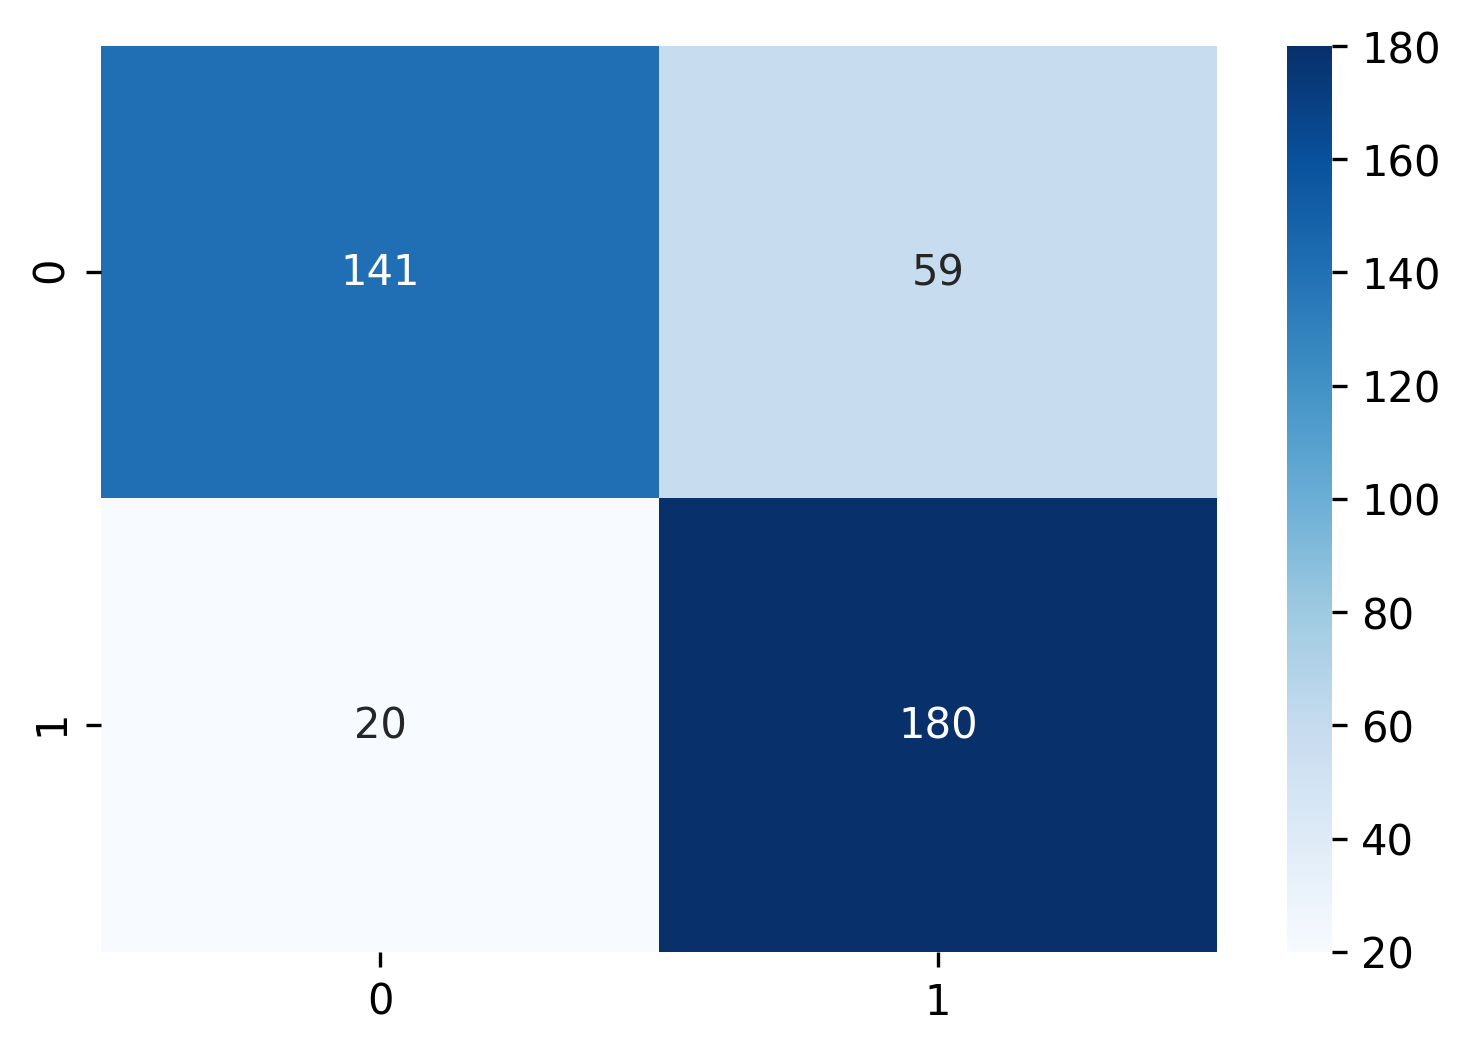

In [45]:
import seaborn as sns
sns.heatmap(cm_12, annot=True,  fmt='', cmap='Blues', )

# MobileNet Model 13

In [47]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.MobileNet(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs #4
model_13 = keras.Model(inputs, outputs)

# Compile the model
model_13.compile(loss= tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_13 = model_13.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/20
19/19 [==============================] - 8s 291ms/step - loss: 0.6320 - accuracy: 0.6450 - val_loss: 0.5717 - val_accuracy: 0.7225
Epoch 2/20
19/19 [==============================] - 6s 271ms/step - loss: 0.5157 - accuracy: 0.7417 - val_loss: 0.5120 - val_accuracy: 0.7725
Epoch 3/20
19/19 [==============================] - 6s 238ms/step - loss: 0.4516 - accuracy: 0.7967 - val_loss: 0.4798 - val_accuracy: 0.7725
Epoch 4/20
19/19 [==============================] - 6s 263ms/step - loss: 0.4481 - accuracy: 0.7975 - val_loss: 0.4668 - val_accuracy: 0.7975
Epoch 5/20
19/19 [==============================] - 6s 245ms/step - loss: 0.4114 - accuracy: 0.8192 - val_loss: 0.4401 - val_accuracy: 0.7900
Epoch 6/20
19/19 [==============================] - 6s 253ms/step - loss: 0.3963 - accuracy: 0.8283 - val_loss: 0.4457 - val_accuracy: 0.7650
Epoch 7/20
19/19 [==============================] - 6s 244ms/step - loss: 0.3891 - 

In [48]:
# Evaluate on the test data
model_13.evaluate(test_dataset)

7/7 [==============================] - 1s 51ms/step - loss: 0.3502 - accuracy: 0.8150


[0.35018759965896606, 0.8149999976158142]

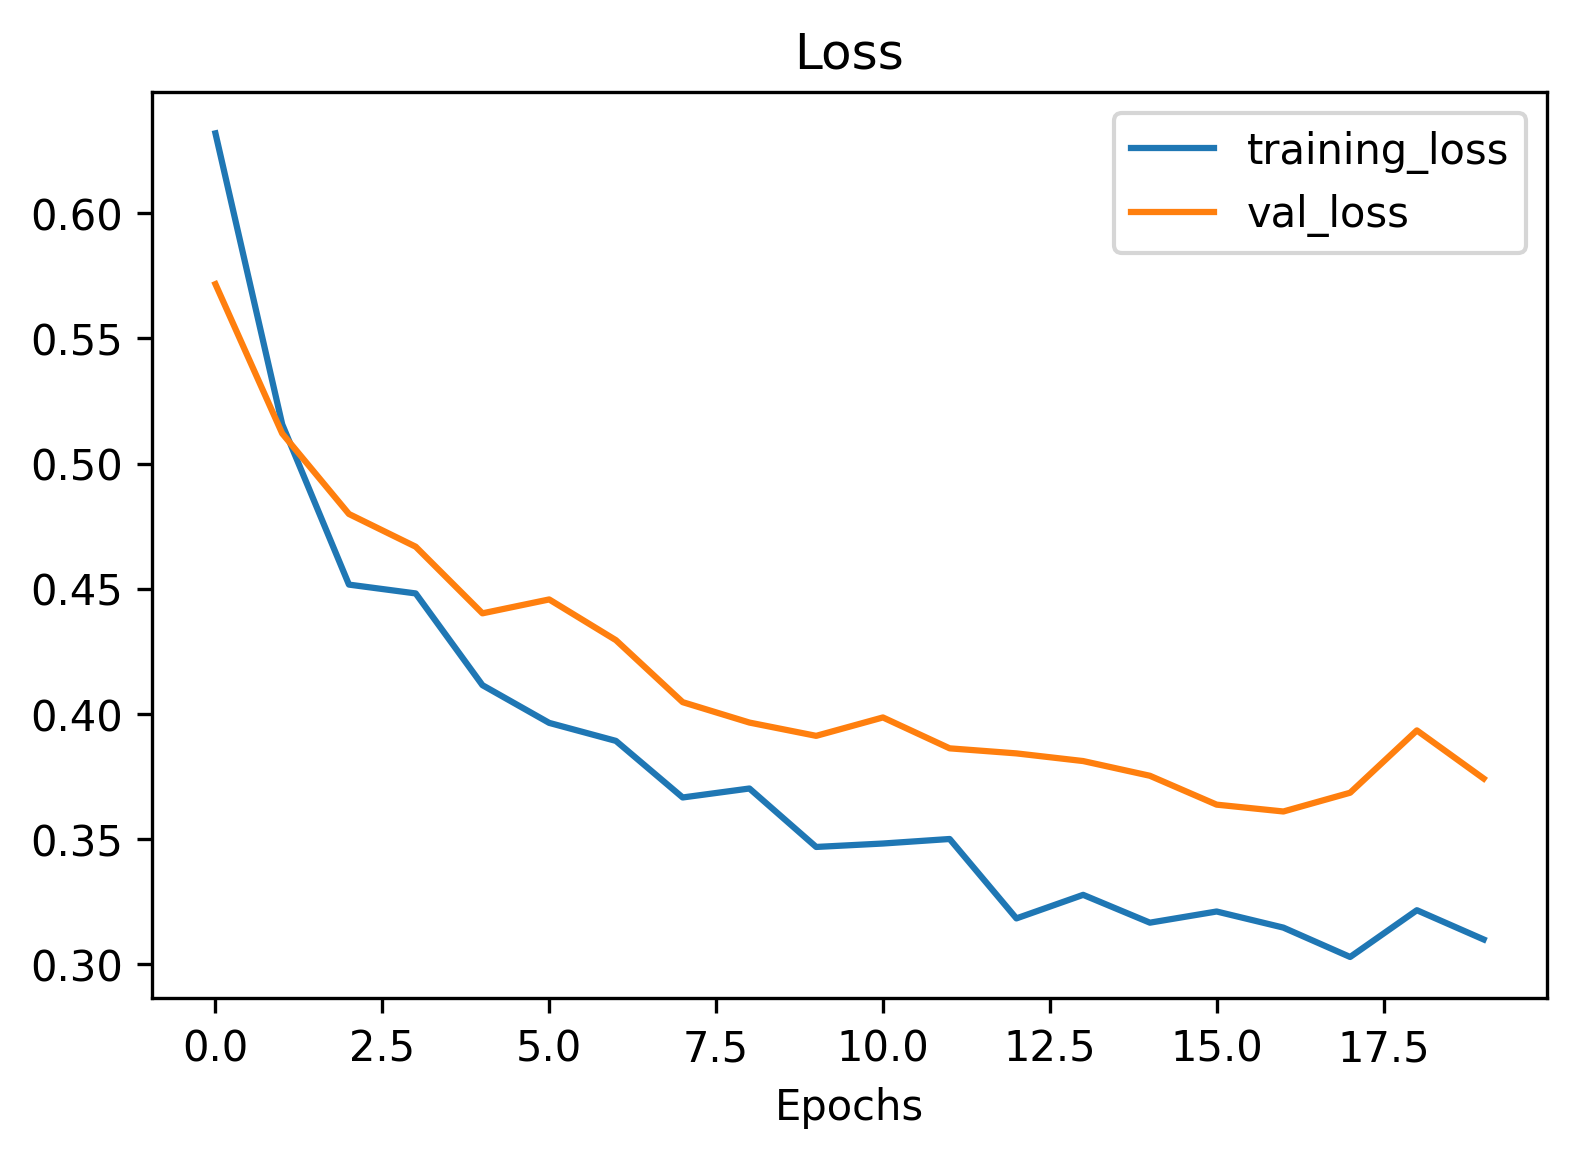

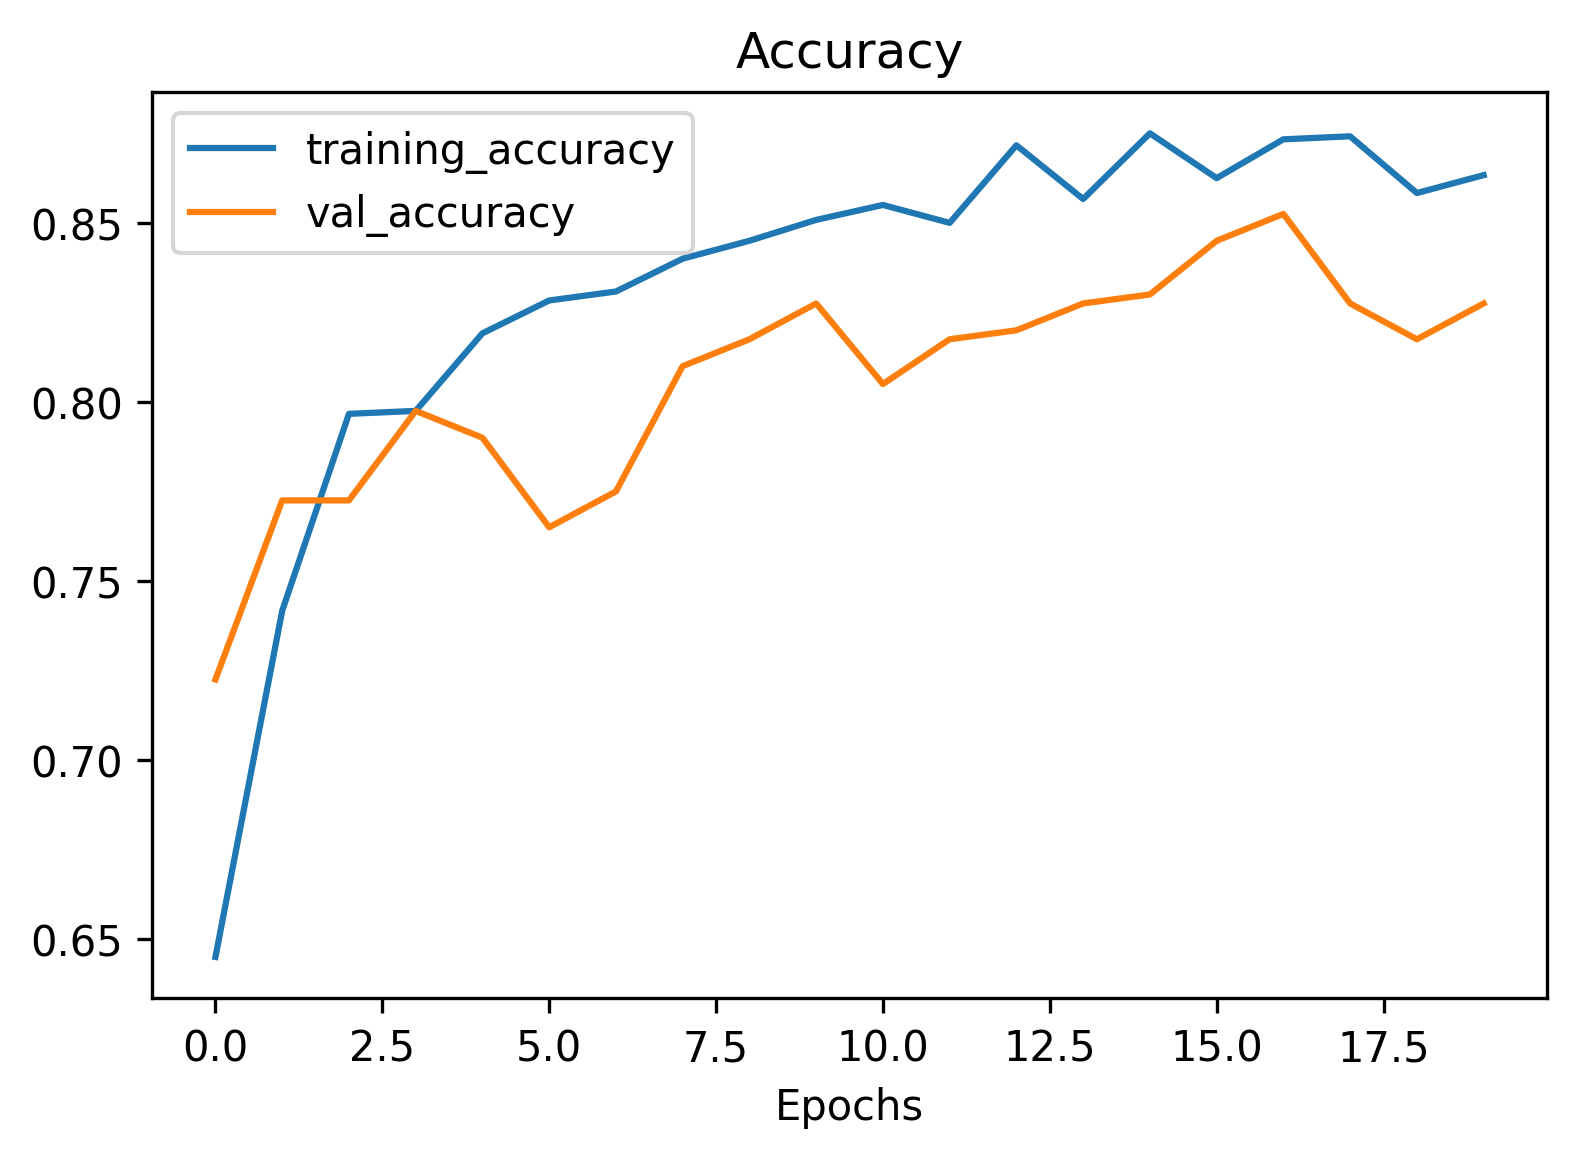

In [49]:
plot_loss_curves(history_13)

### Evaluation

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [50]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_13.predict(image_batch)
   # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [51]:
acc = accuracy_score(y_pred=predicted_labels, y_true=correct_labels)
acc

0.815

In [52]:
model_13.evaluate(test_dataset)

7/7 [==============================] - 1s 52ms/step - loss: 0.3502 - accuracy: 0.8150


[0.35018759965896606, 0.8149999976158142]

In [53]:
confusion_matrix(y_pred=predicted_labels, y_true=correct_labels)

array([[180,  20],
       [ 54, 146]])

In [54]:
test_dataset.class_names

['dyed-lifted-polyps', 'dyed-resection-margins']

In [55]:
cm_13 = confusion_matrix(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])
print(cm_13)

[[146  54]
 [ 20 180]]


In [56]:
print(classification_report(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.88      0.73      0.80       200
           0       0.77      0.90      0.83       200

    accuracy                           0.81       400
   macro avg       0.82      0.81      0.81       400
weighted avg       0.82      0.81      0.81       400



In [57]:
recall_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.73

In [58]:
precision_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.8795180722891566

In [59]:
f1_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.7978142076502732

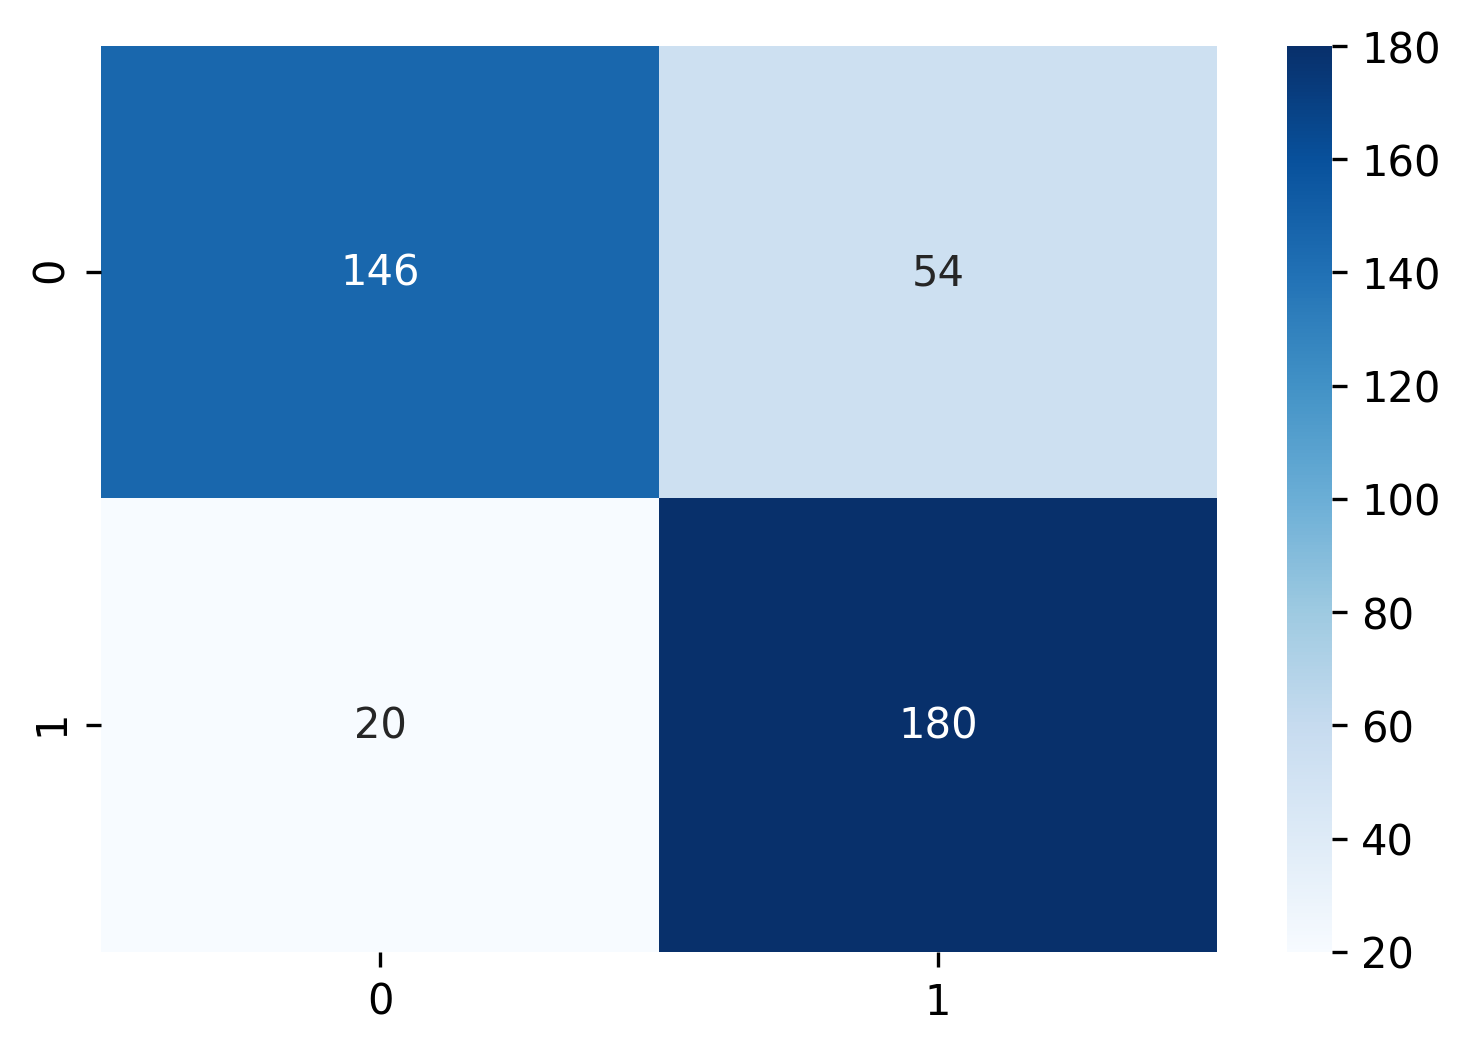

In [60]:
import seaborn as sns
sns.heatmap(cm_13, annot=True,  fmt='', cmap='Blues', )

# For 299x299 image size

In [61]:
BATCH_SIZE = 64
IMG_SIZE = (299, 299)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  str(train_dir),
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  str(valid_dir),
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  str(test_dir),
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
)

Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [62]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

In [63]:
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomContrast(factor=0.2),
  preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


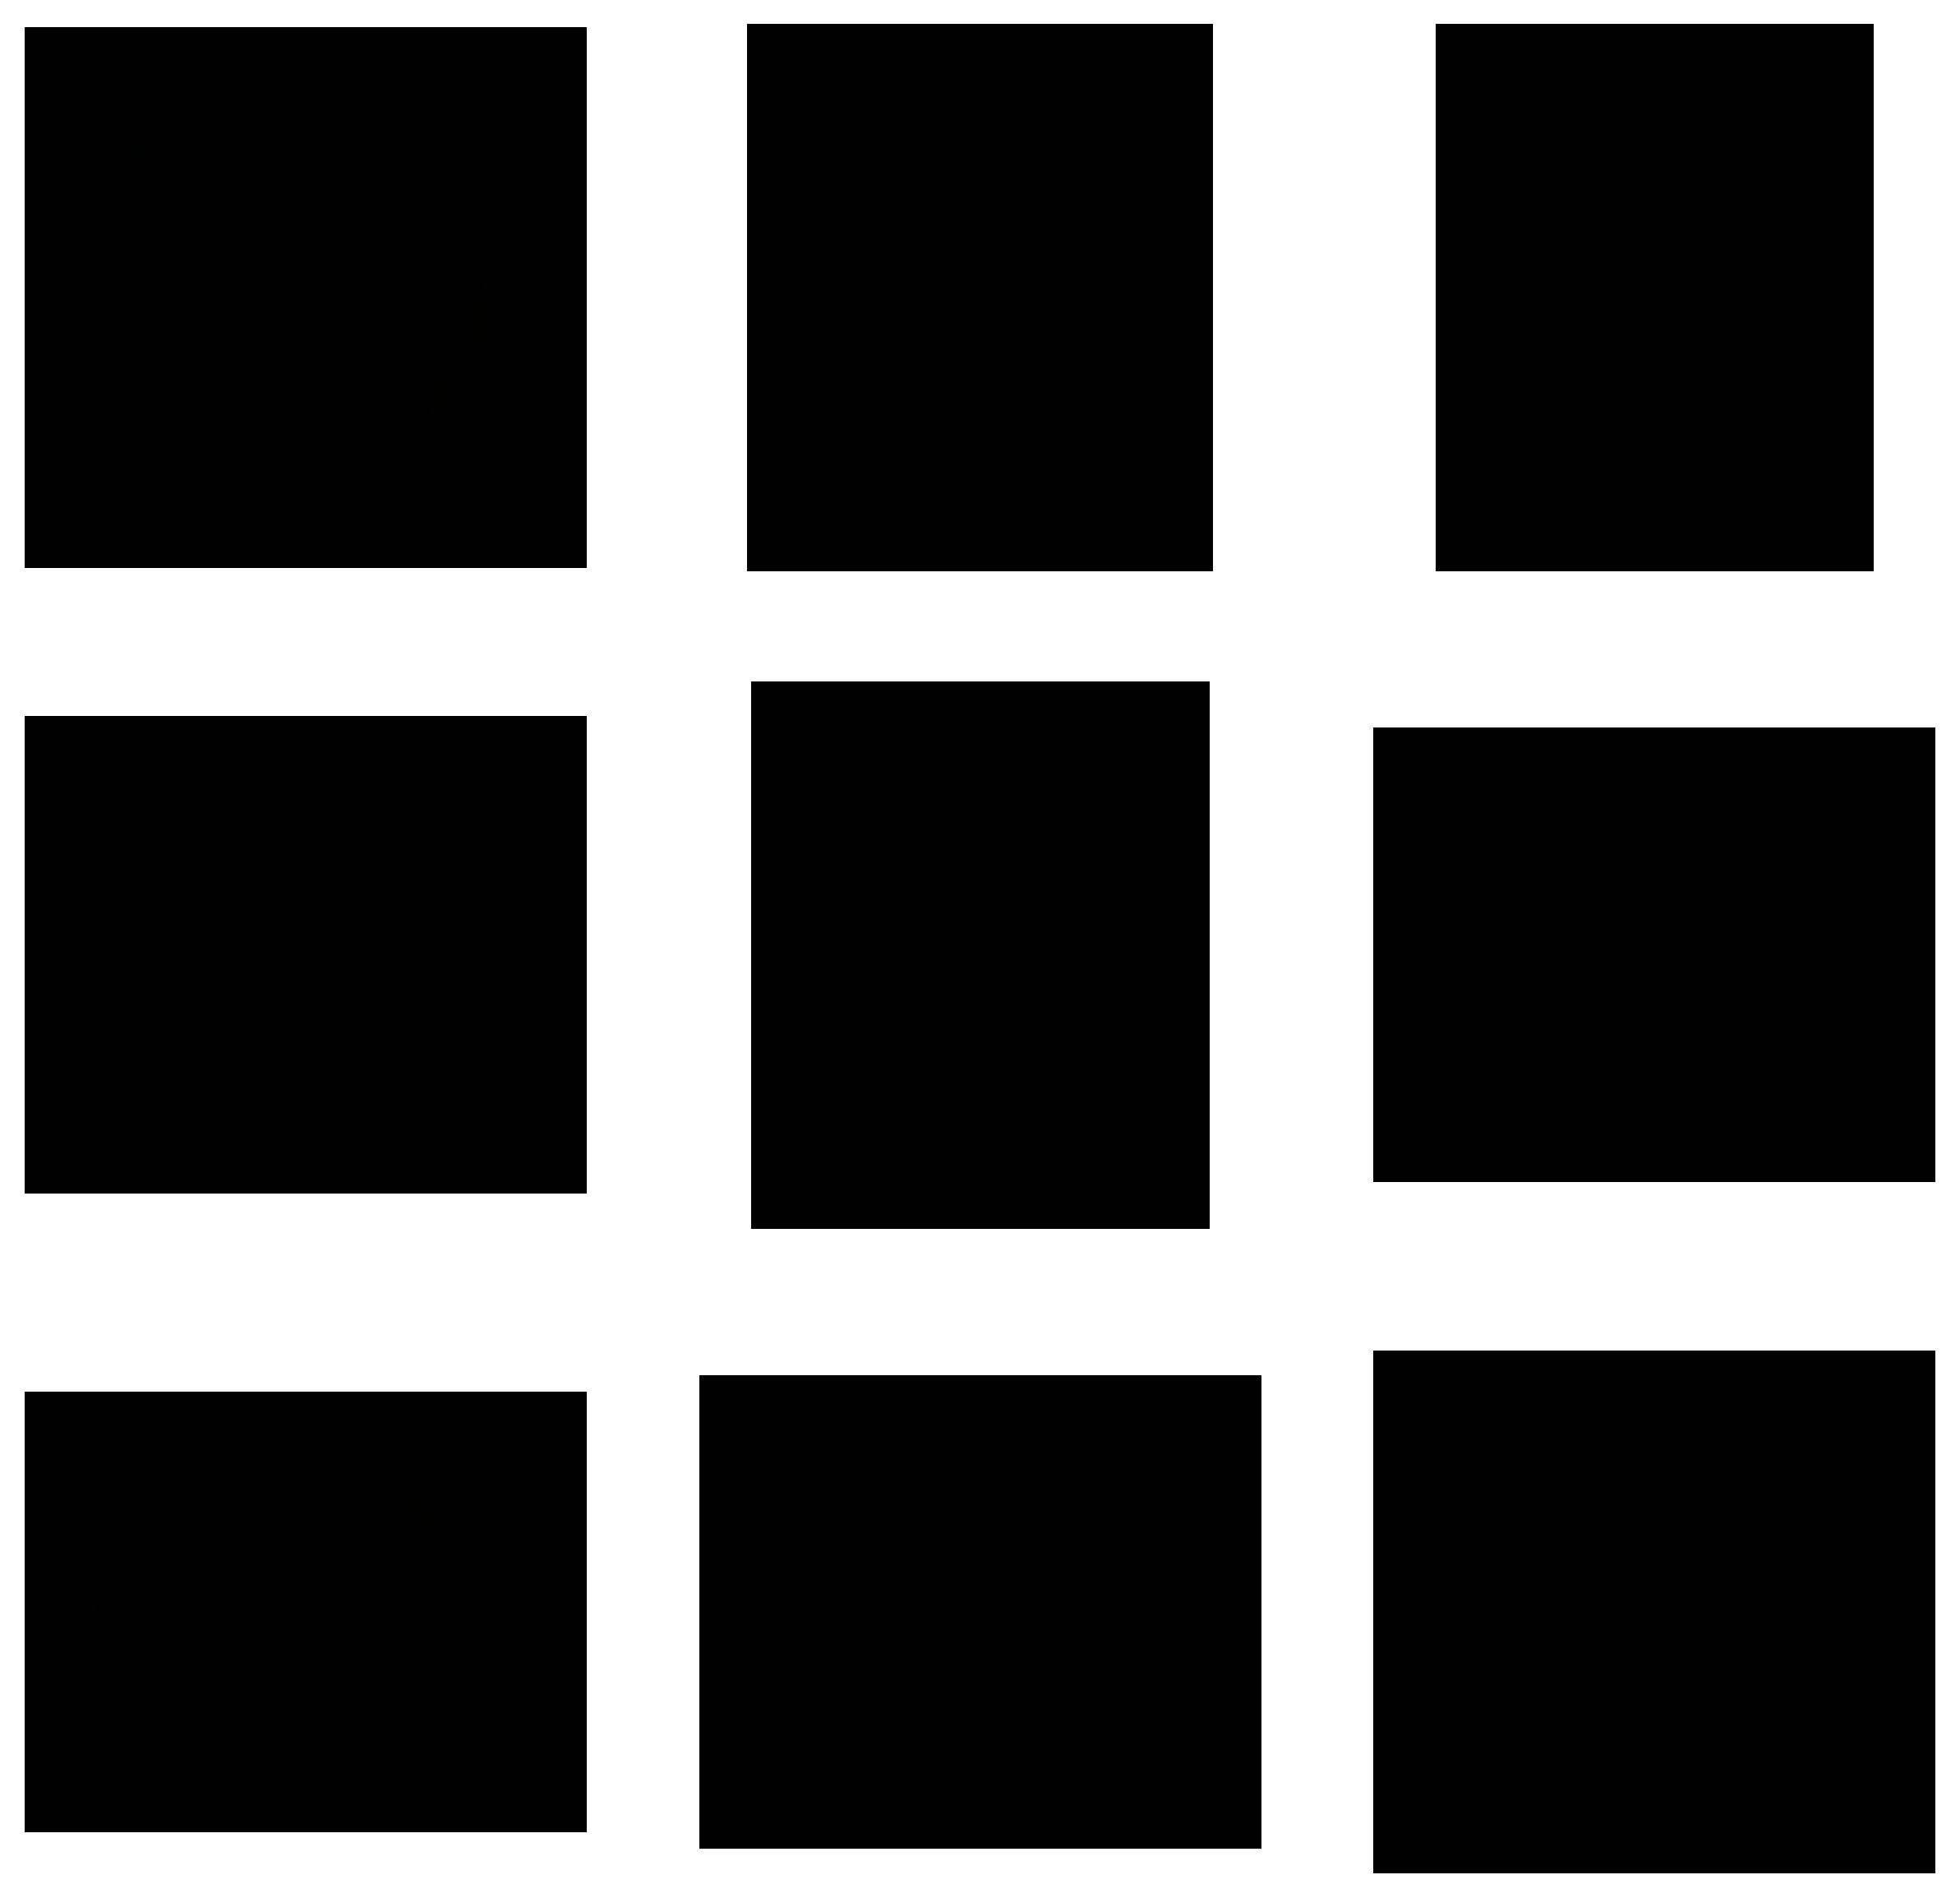

In [64]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Xception Model 14

In [65]:
# Setup input shape and base model, freezing the base model layers
input_shape = (299, 299, 3)
base_model = tf.keras.applications.Xception(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs #4
model_14 = keras.Model(inputs, outputs)

# Compile the model
model_14.compile(loss= tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_14 = model_14.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

83697664/83683744 [==============================] - 0s 0us/step
Epoch 1/20
19/19 [==============================] - 22s 961ms/step - loss: 0.6418 - accuracy: 0.6542 - val_loss: 0.5998 - val_accuracy: 0.6925
Epoch 2/20
19/19 [==============================] - 18s 873ms/step - loss: 0.5557 - accuracy: 0.7308 - val_loss: 0.5444 - val_accuracy: 0.7250
Epoch 3/20
19/19 [==============================] - 17s 851ms/step - loss: 0.5155 - accuracy: 0.7692 - val_loss: 0.5122 - val_accuracy: 0.7475
Epoch 4/20
19/19 [==============================] - 16s 764ms/step - loss: 0.4987 - accuracy: 0.7617 - val_loss: 0.5027 - val_accuracy: 0.7450
Epoch 5/20
19/19 [==============================] - 17s 846ms/step - loss: 0.4740 - accuracy: 0.7933 - val_loss: 0.5009 - val_accuracy: 0.7525
Epoch 6/20
19/19 [==============================] - 16s 776ms/step - loss: 0.4641 - accuracy: 0.7933 - val_loss: 0.5071 - val_accuracy: 0.7475
Epoch 7/20
19/19 [==============================] - 16s 797ms/step - loss: 0.

In [66]:
# Evaluate on the test data
model_14.evaluate(test_dataset)

7/7 [==============================] - 3s 243ms/step - loss: 0.4306 - accuracy: 0.7925


[0.4306492507457733, 0.7925000190734863]

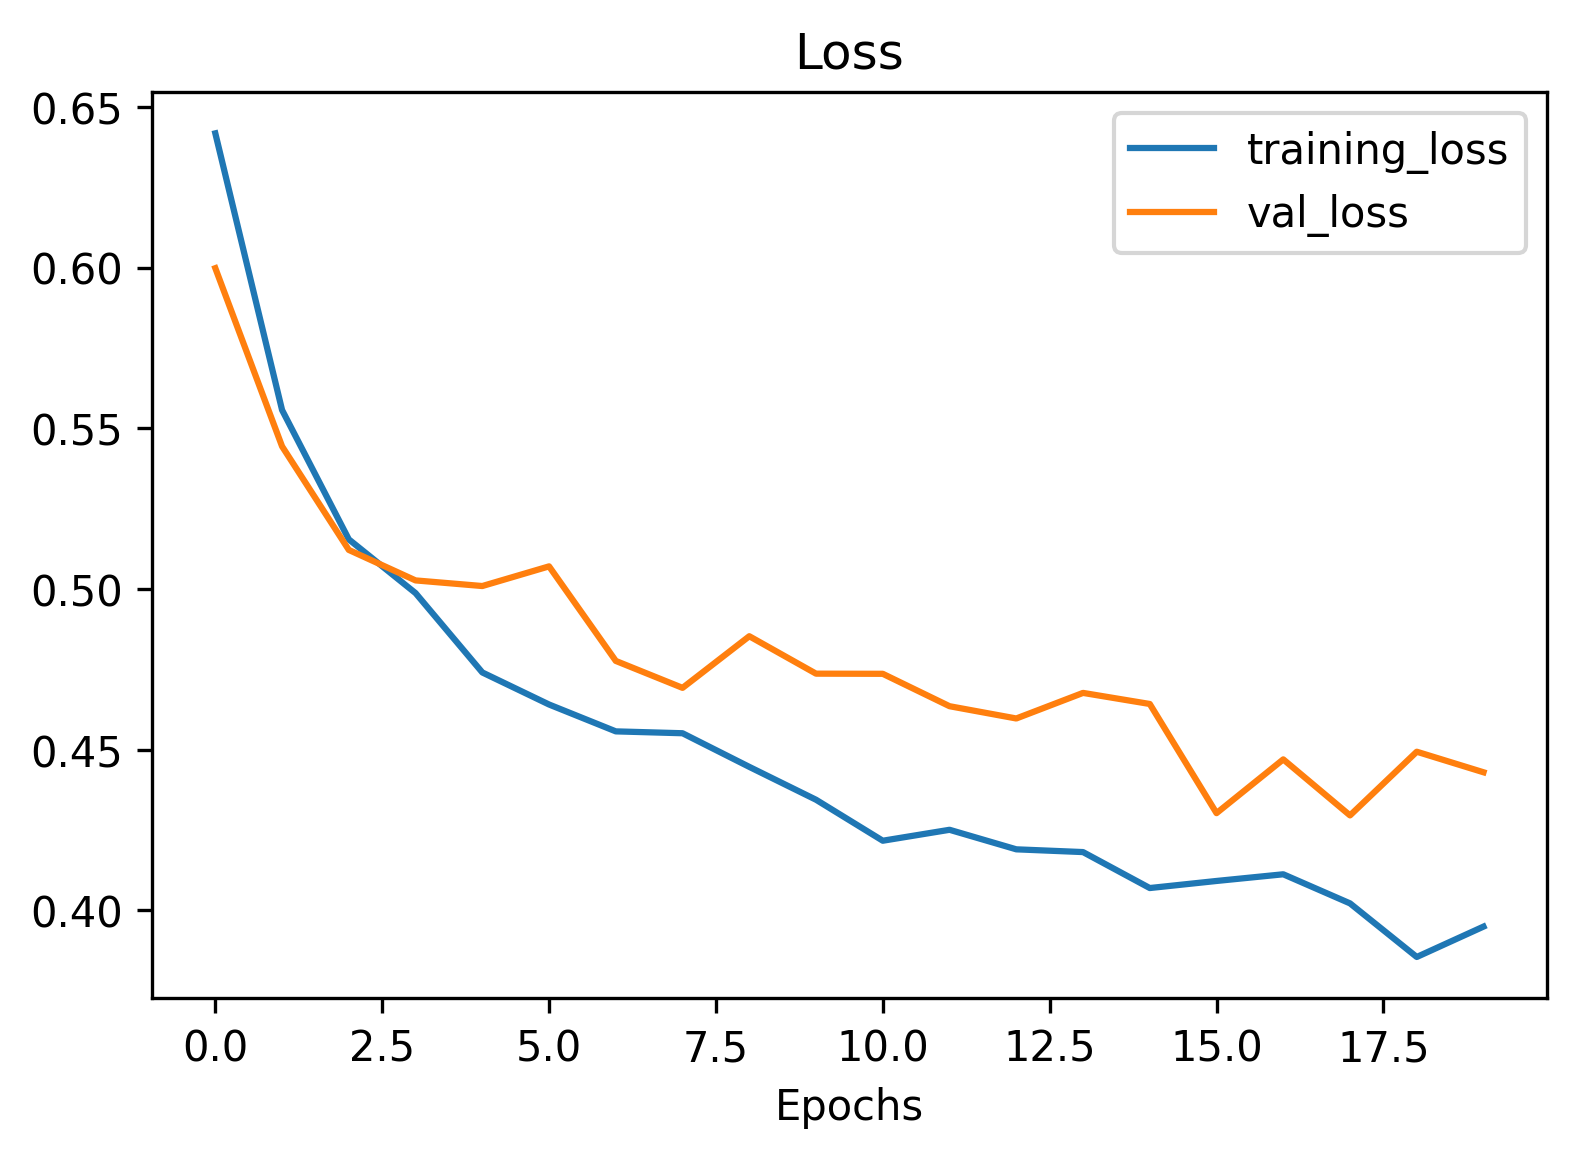

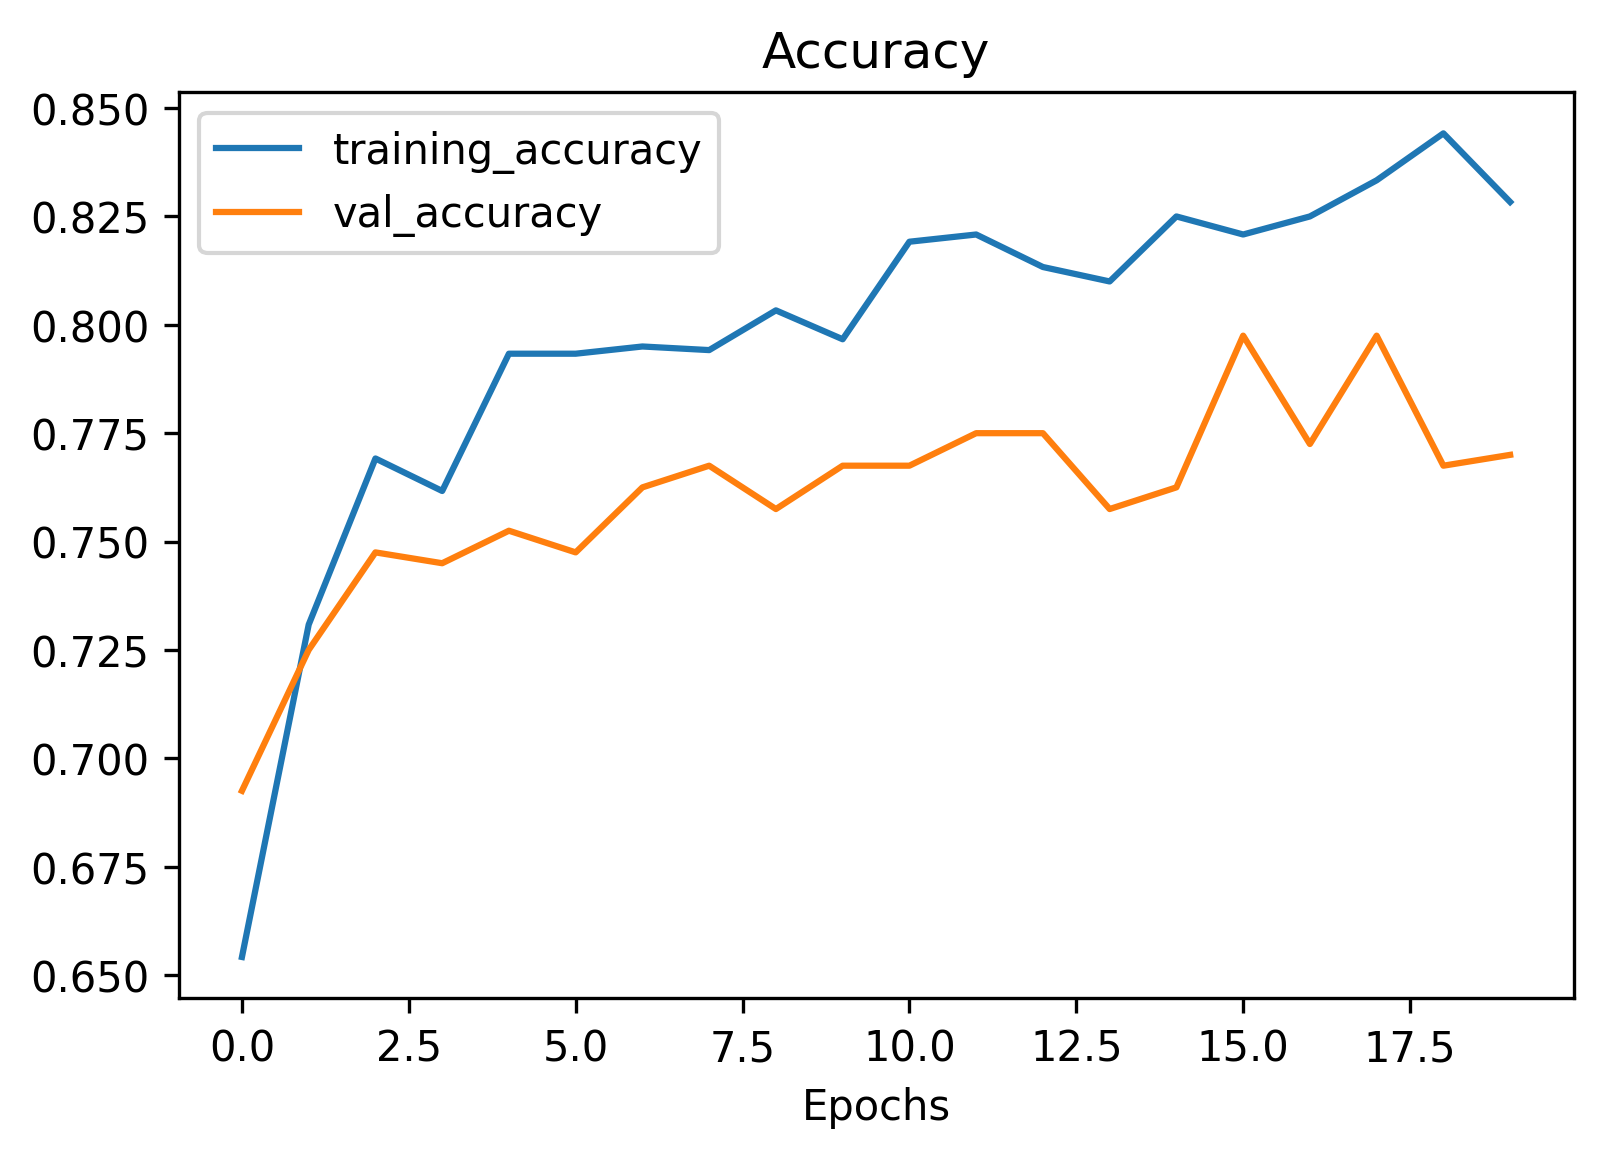

In [67]:
plot_loss_curves(history_14)

### Evaluation

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [68]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_14.predict(image_batch)
   # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [69]:
acc = accuracy_score(y_pred=predicted_labels, y_true=correct_labels)
acc

0.7925

In [70]:
model_14.evaluate(test_dataset)

7/7 [==============================] - 3s 244ms/step - loss: 0.4306 - accuracy: 0.7925


[0.4306493401527405, 0.7925000190734863]

In [71]:
confusion_matrix(y_pred=predicted_labels, y_true=correct_labels)

array([[181,  19],
       [ 64, 136]])

In [72]:
test_dataset.class_names

['dyed-lifted-polyps', 'dyed-resection-margins']

In [73]:
cm_14 = confusion_matrix(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])
print(cm_14)

[[136  64]
 [ 19 181]]


In [74]:
print(classification_report(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.88      0.68      0.77       200
           0       0.74      0.91      0.81       200

    accuracy                           0.79       400
   macro avg       0.81      0.79      0.79       400
weighted avg       0.81      0.79      0.79       400



In [75]:
recall_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.68

In [76]:
precision_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.8774193548387097

In [77]:
f1_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.7661971830985915

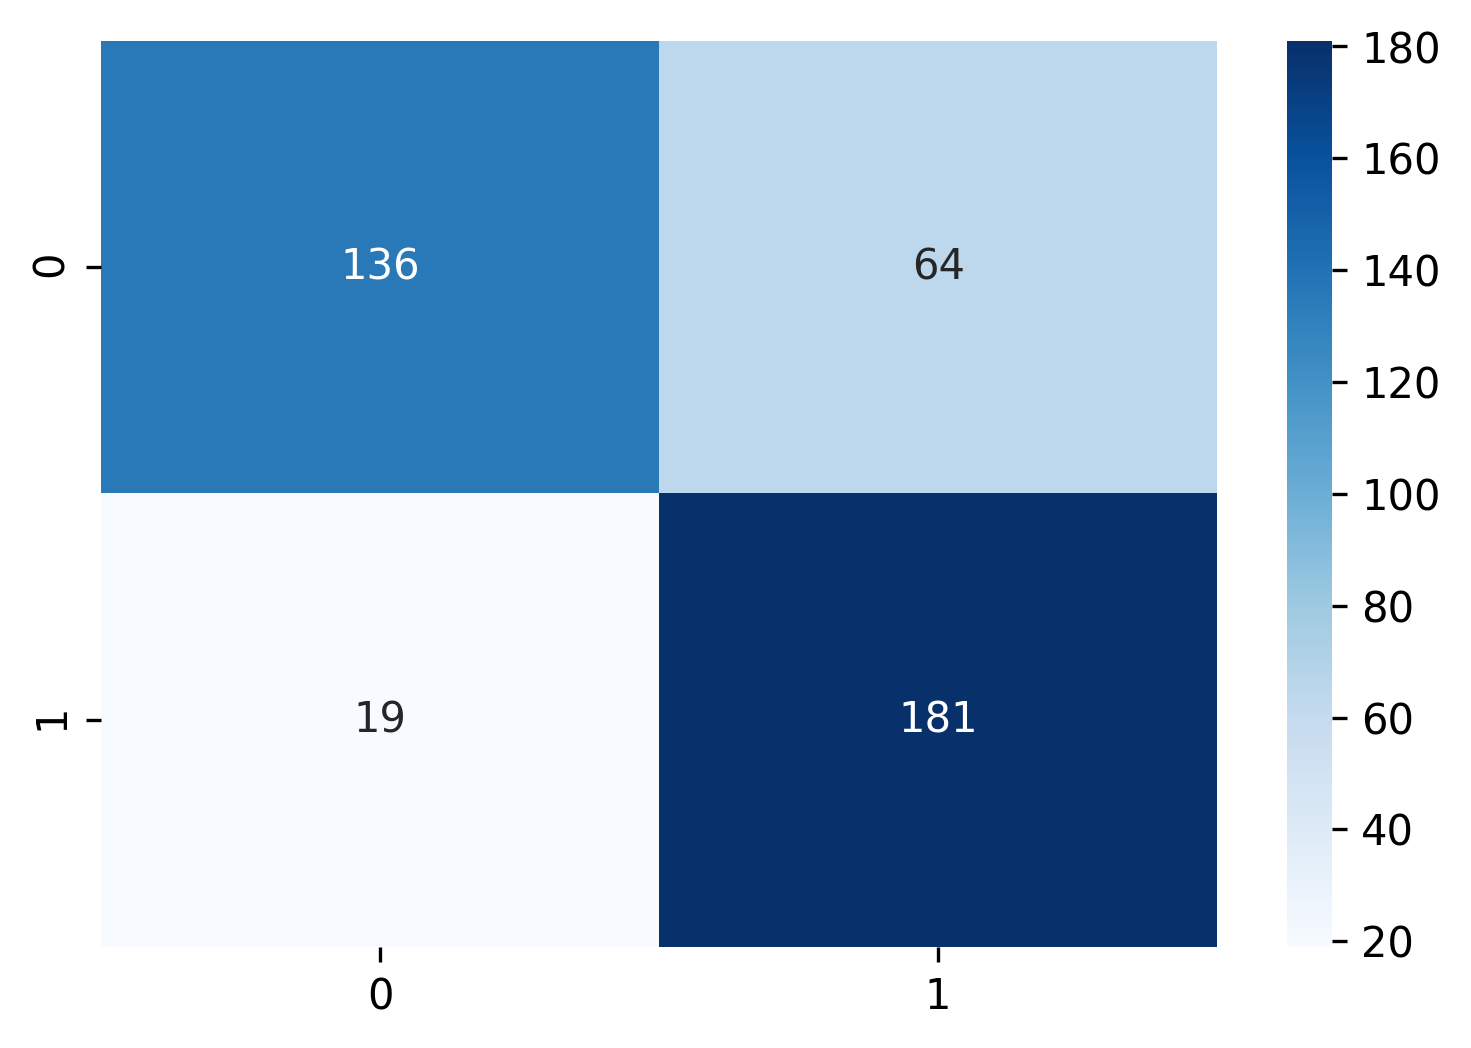

In [78]:
import seaborn as sns
sns.heatmap(cm_14, annot=True,  fmt='', cmap='Blues', )

# InceptionV3 Model 15

In [79]:
# Setup input shape and base model, freezing the base model layers
input_shape = (299, 299, 3)
base_model = tf.keras.applications.InceptionV3(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs #4
model_15 = keras.Model(inputs, outputs)

# Compile the model
model_15.compile(loss= tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_15 = model_15.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

87924736/87910968 [==============================] - 0s 0us/step
Epoch 1/20
19/19 [==============================] - 25s 1s/step - loss: 0.7117 - accuracy: 0.5508 - val_loss: 0.6329 - val_accuracy: 0.6300
Epoch 2/20
19/19 [==============================] - 17s 817ms/step - loss: 0.6225 - accuracy: 0.6417 - val_loss: 0.5967 - val_accuracy: 0.6900
Epoch 3/20
19/19 [==============================] - 16s 766ms/step - loss: 0.5502 - accuracy: 0.7342 - val_loss: 0.5393 - val_accuracy: 0.7425
Epoch 4/20
19/19 [==============================] - 17s 844ms/step - loss: 0.5276 - accuracy: 0.7525 - val_loss: 0.5179 - val_accuracy: 0.7500
Epoch 5/20
19/19 [==============================] - 15s 747ms/step - loss: 0.5064 - accuracy: 0.7733 - val_loss: 0.5222 - val_accuracy: 0.7250
Epoch 6/20
19/19 [==============================] - 15s 722ms/step - loss: 0.4822 - accuracy: 0.7742 - val_loss: 0.4977 - val_accuracy: 0.7550
Epoch 7/20
19/19 [==============================] - 14s 672ms/step - loss: 0.487

In [80]:
# Evaluate on the test data
model_15.evaluate(test_dataset)

7/7 [==============================] - 2s 135ms/step - loss: 0.4214 - accuracy: 0.8000


[0.4213736057281494, 0.800000011920929]

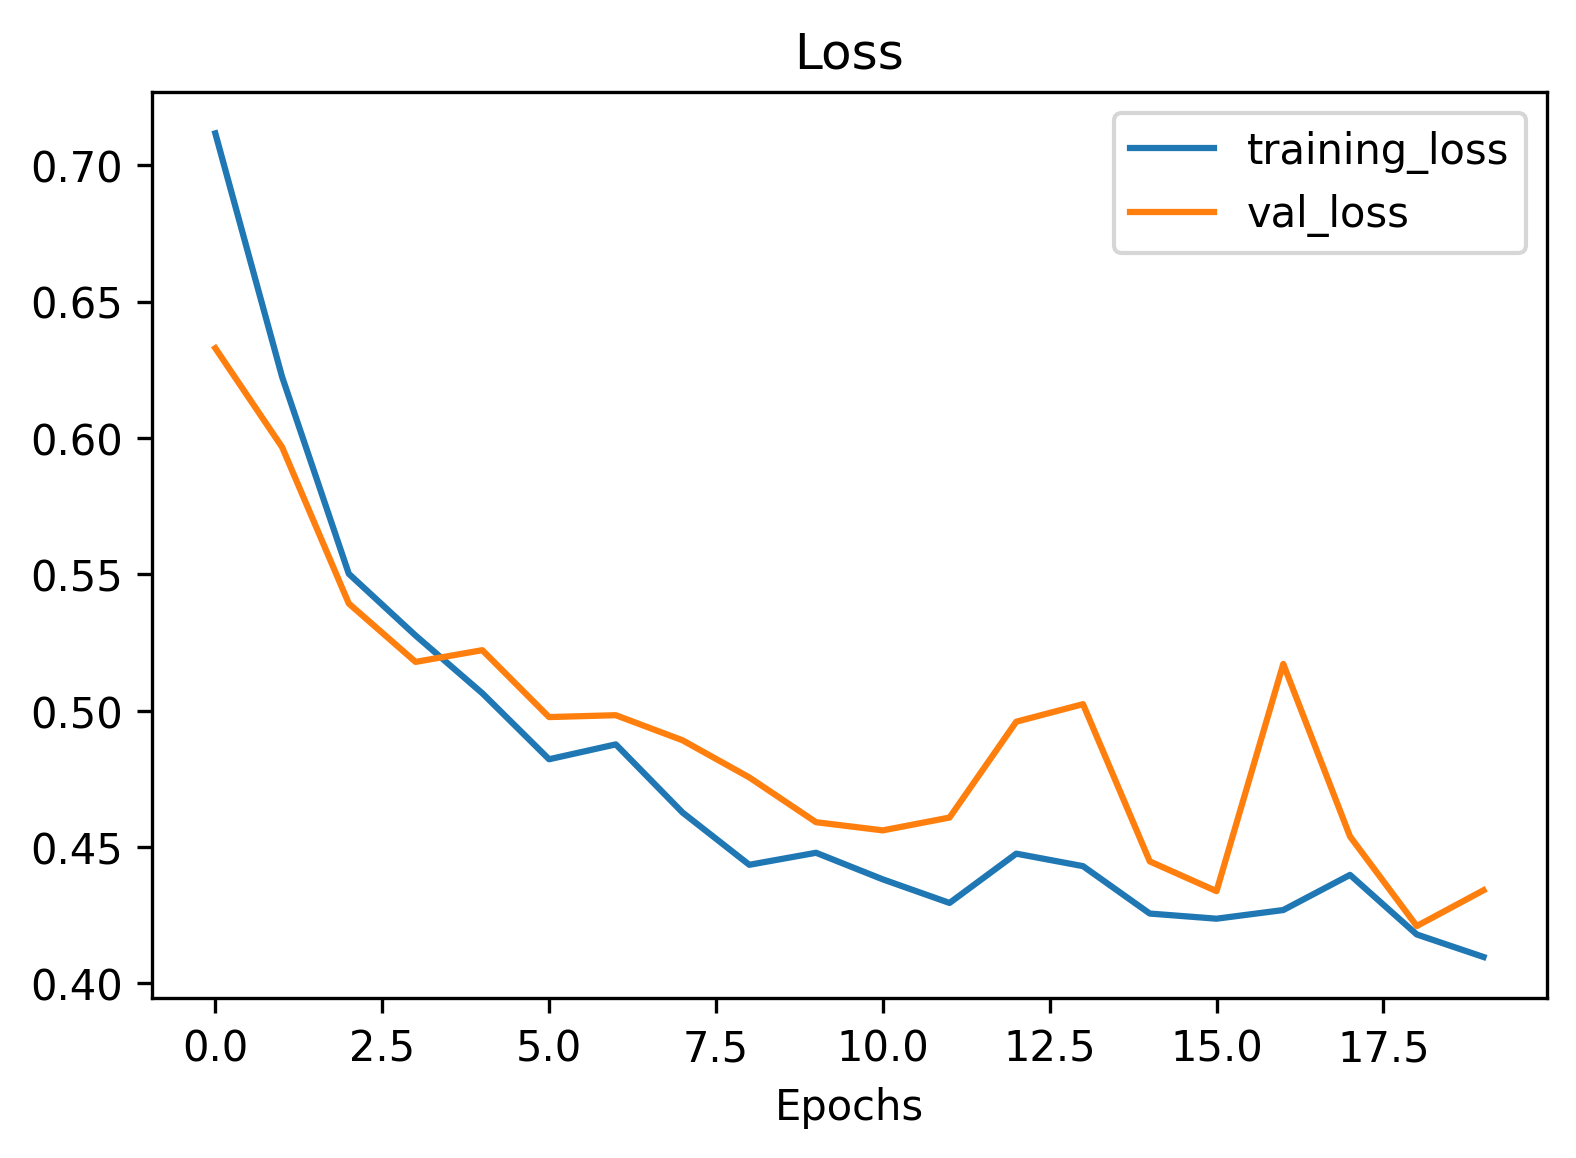

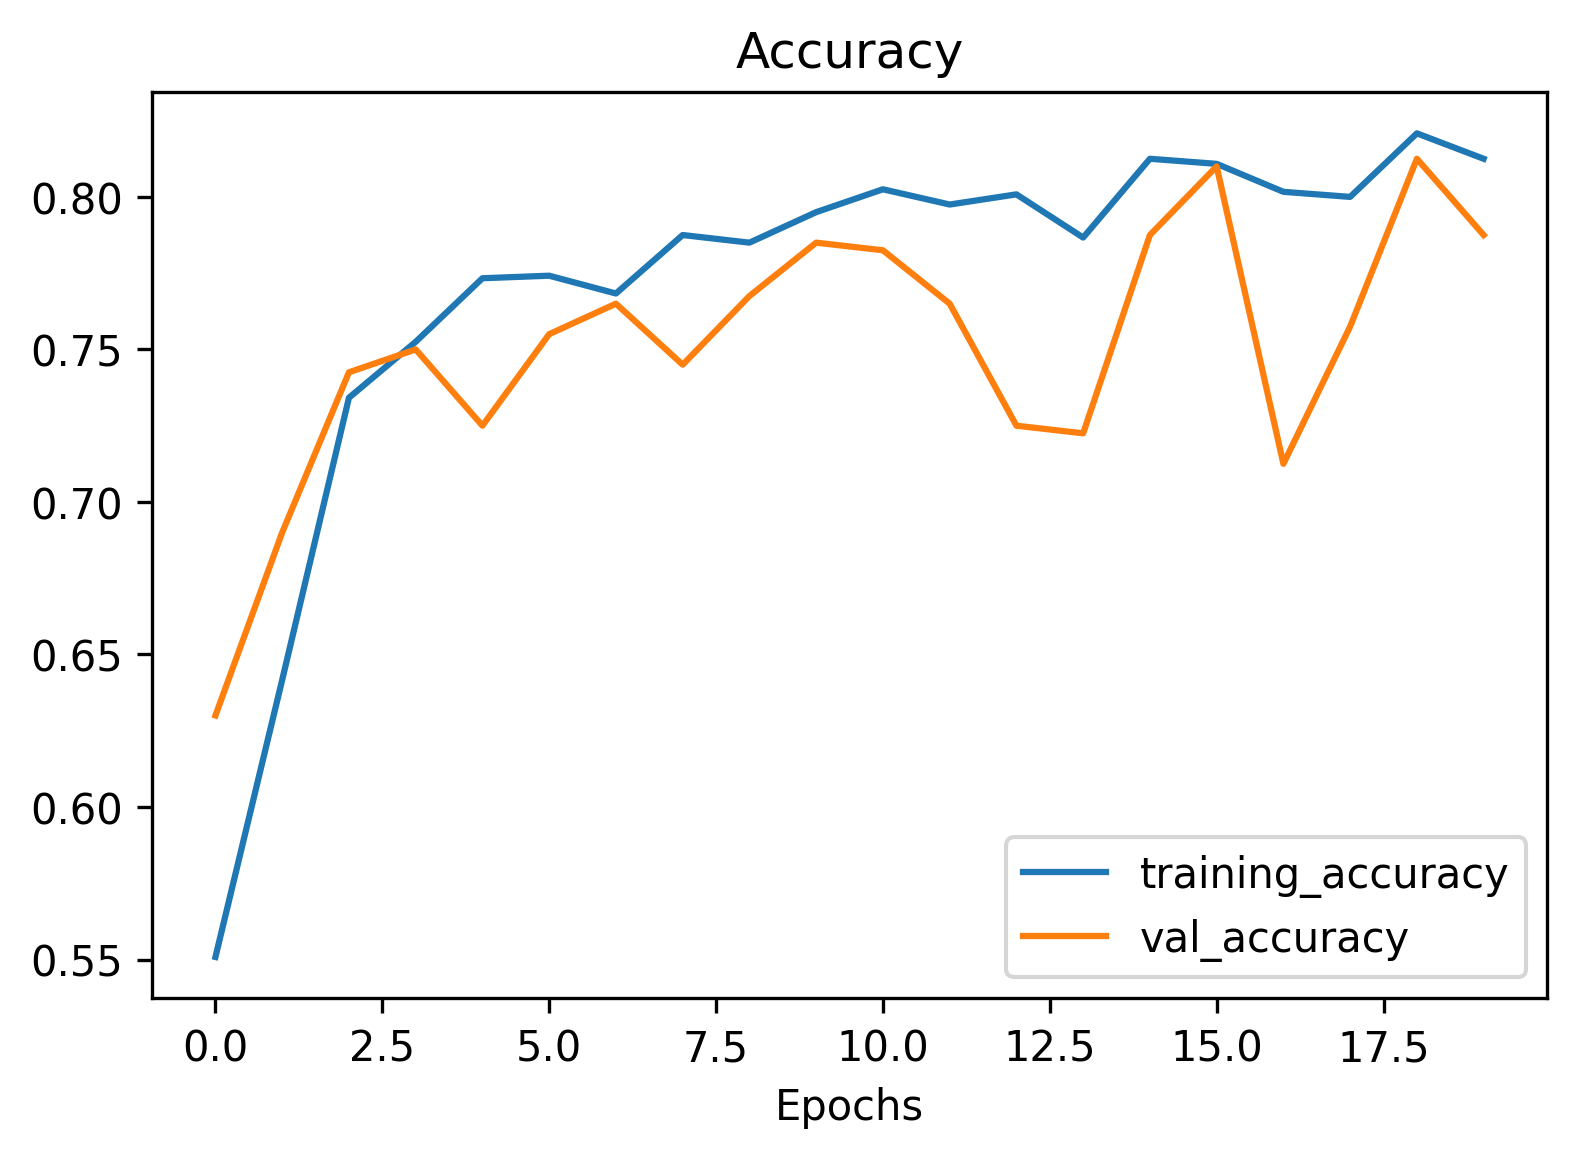

In [81]:
plot_loss_curves(history_15)

### Evaluation

In [82]:
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [83]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_15.predict(image_batch)
   # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [84]:
acc = accuracy_score(y_pred=predicted_labels, y_true=correct_labels)
acc

0.8

In [85]:
model_15.evaluate(test_dataset)

7/7 [==============================] - 2s 136ms/step - loss: 0.4214 - accuracy: 0.8000


[0.4213736355304718, 0.800000011920929]

In [86]:
confusion_matrix(y_pred=predicted_labels, y_true=correct_labels)

array([[180,  20],
       [ 60, 140]])

In [87]:
test_dataset.class_names

['dyed-lifted-polyps', 'dyed-resection-margins']

In [88]:
cm_15 = confusion_matrix(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])
print(cm_15)

[[140  60]
 [ 20 180]]


In [89]:
print(classification_report(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.88      0.70      0.78       200
           0       0.75      0.90      0.82       200

    accuracy                           0.80       400
   macro avg       0.81      0.80      0.80       400
weighted avg       0.81      0.80      0.80       400



In [90]:
recall_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.7

In [91]:
precision_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.875

In [92]:
f1_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.7777777777777777

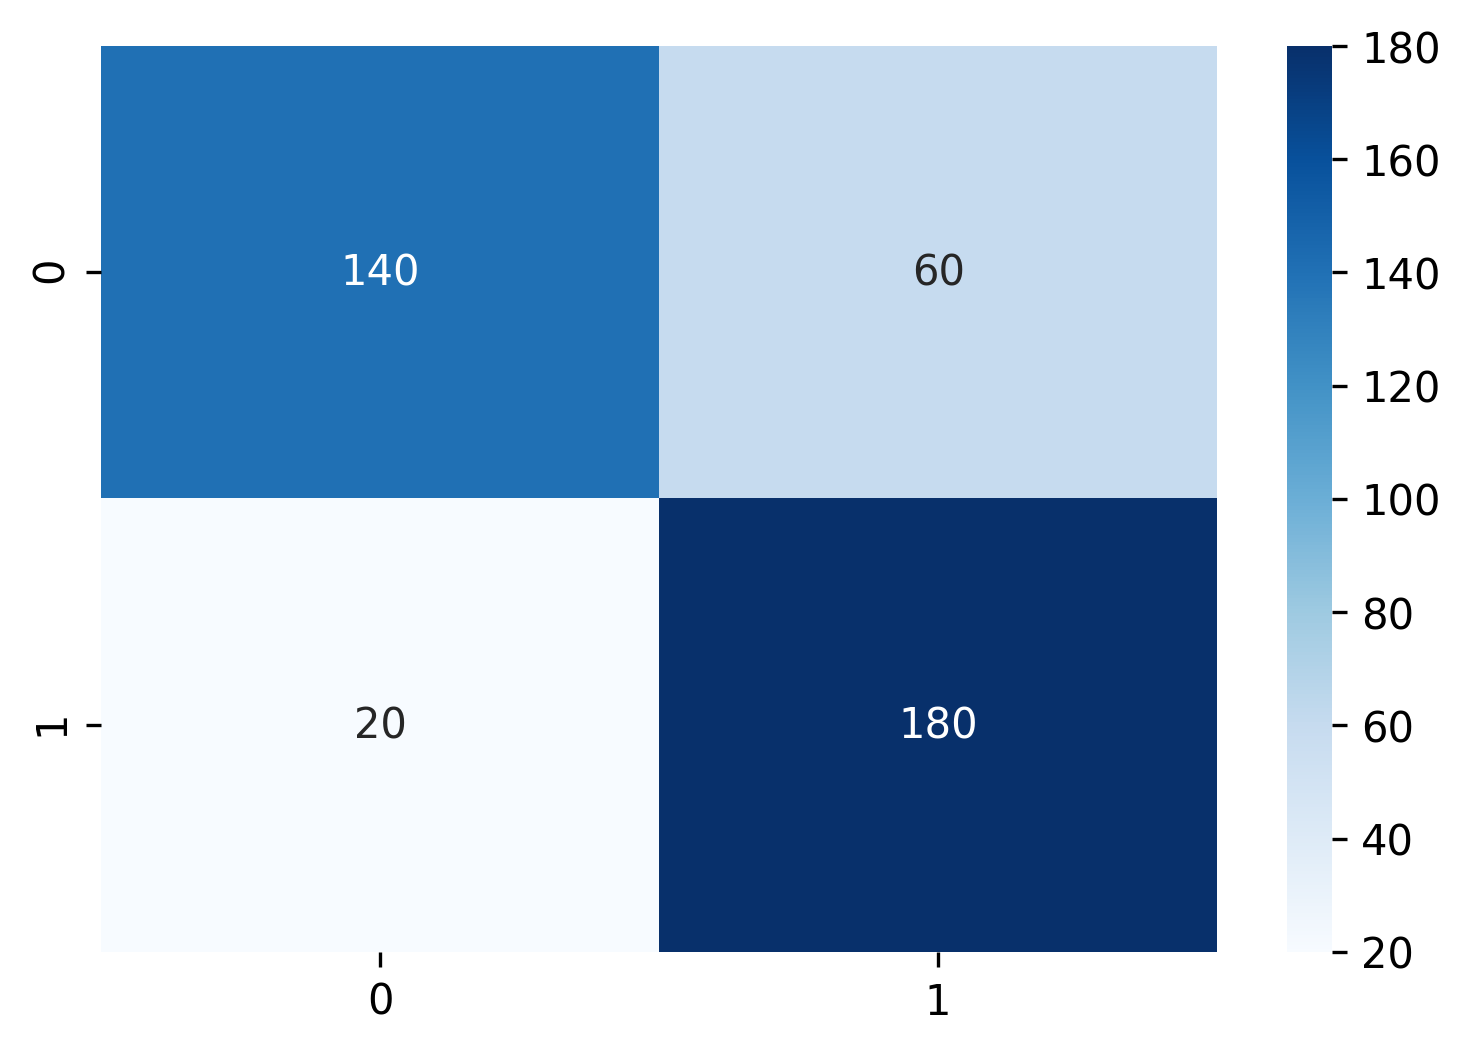

In [93]:
import seaborn as sns
sns.heatmap(cm_15, annot=True,  fmt='', cmap='Blues', )

# InceptionResNetV2 Model 16

In [94]:
# Setup input shape and base model, freezing the base model layers
input_shape = (299, 299, 3)
base_model = tf.keras.applications.InceptionResNetV2(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs #4
model_16 = keras.Model(inputs, outputs)

# Compile the model
model_16.compile(loss= tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_16 = model_16.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    )

219070464/219055592 [==============================] - 1s 0us/step
Epoch 1/20
19/19 [==============================] - 35s 1s/step - loss: 0.6881 - accuracy: 0.5708 - val_loss: 0.6180 - val_accuracy: 0.6700
Epoch 2/20
19/19 [==============================] - 24s 1s/step - loss: 0.5855 - accuracy: 0.6925 - val_loss: 0.5539 - val_accuracy: 0.7375
Epoch 3/20
19/19 [==============================] - 22s 1s/step - loss: 0.5426 - accuracy: 0.7367 - val_loss: 0.5230 - val_accuracy: 0.7650
Epoch 4/20
19/19 [==============================] - 20s 973ms/step - loss: 0.5055 - accuracy: 0.7625 - val_loss: 0.4984 - val_accuracy: 0.7550
Epoch 5/20
19/19 [==============================] - 19s 923ms/step - loss: 0.4856 - accuracy: 0.7800 - val_loss: 0.4863 - val_accuracy: 0.7675
Epoch 6/20
19/19 [==============================] - 19s 952ms/step - loss: 0.4725 - accuracy: 0.7792 - val_loss: 0.4724 - val_accuracy: 0.7775
Epoch 7/20
19/19 [==============================] - 21s 1s/step - loss: 0.4647 - acc

In [95]:
# Evaluate on the test data
model_16.evaluate(test_dataset)

7/7 [==============================] - 3s 300ms/step - loss: 0.3758 - accuracy: 0.8225


[0.37577149271965027, 0.8224999904632568]

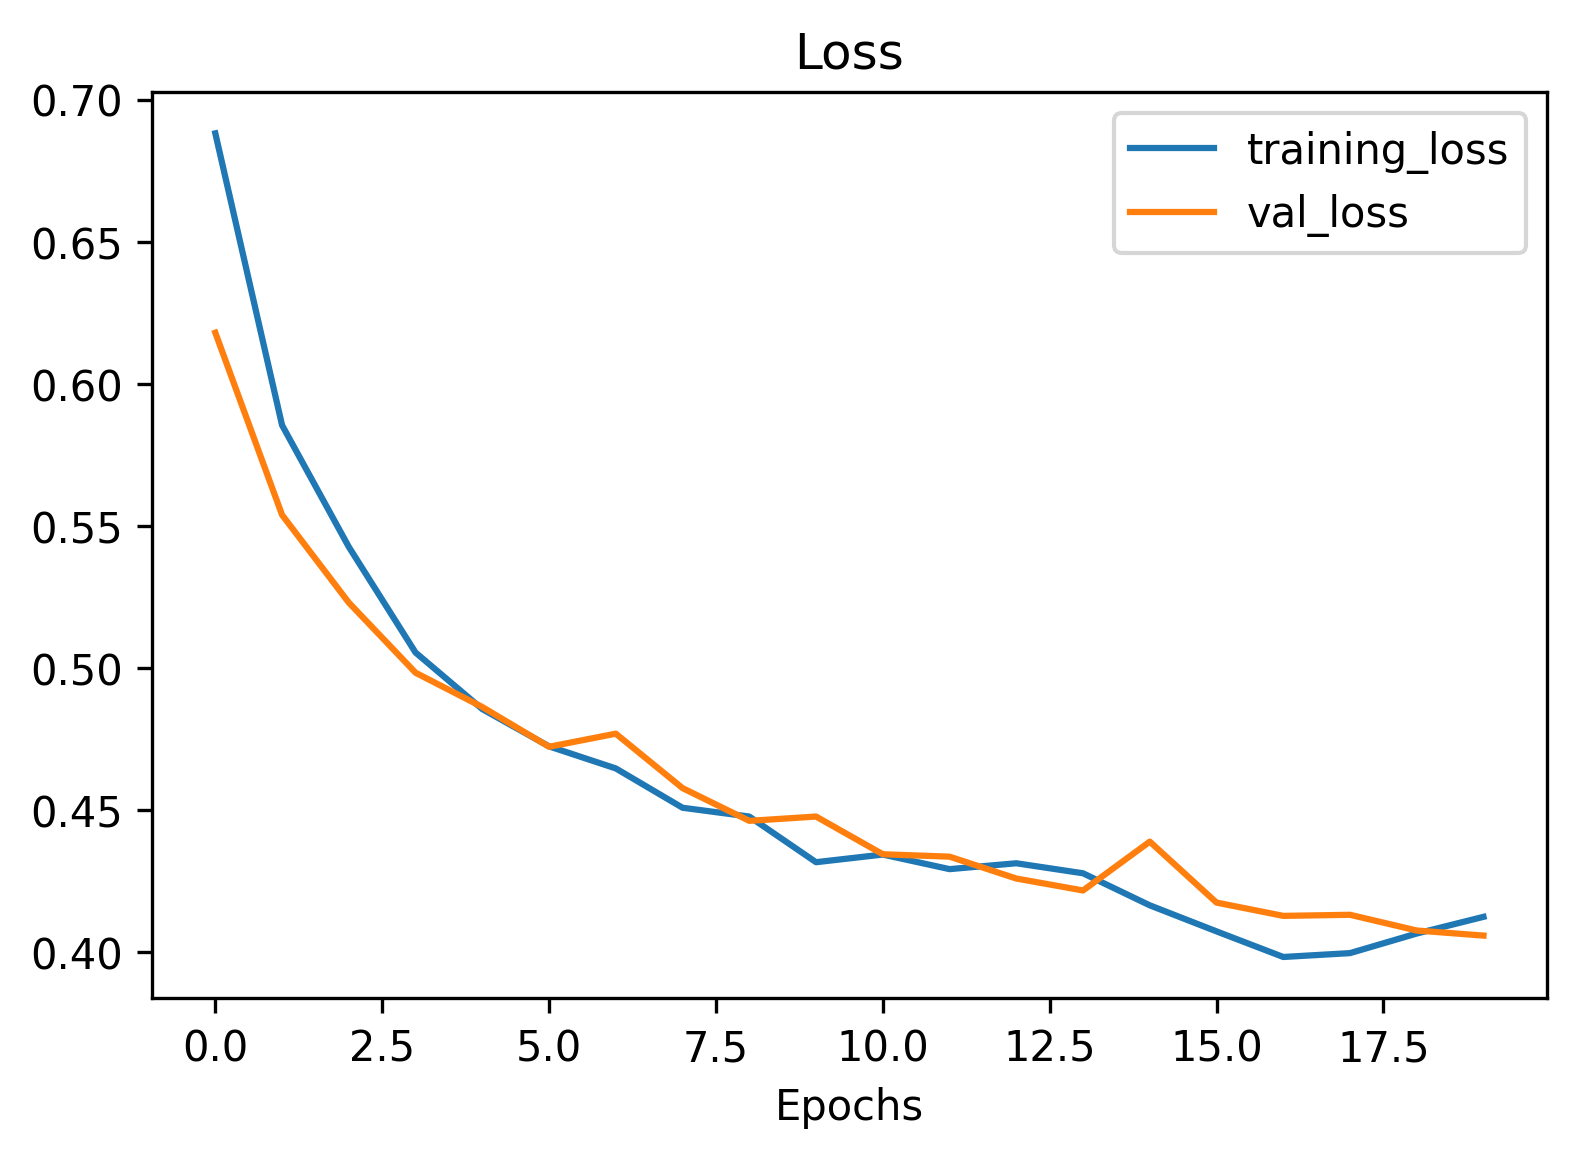

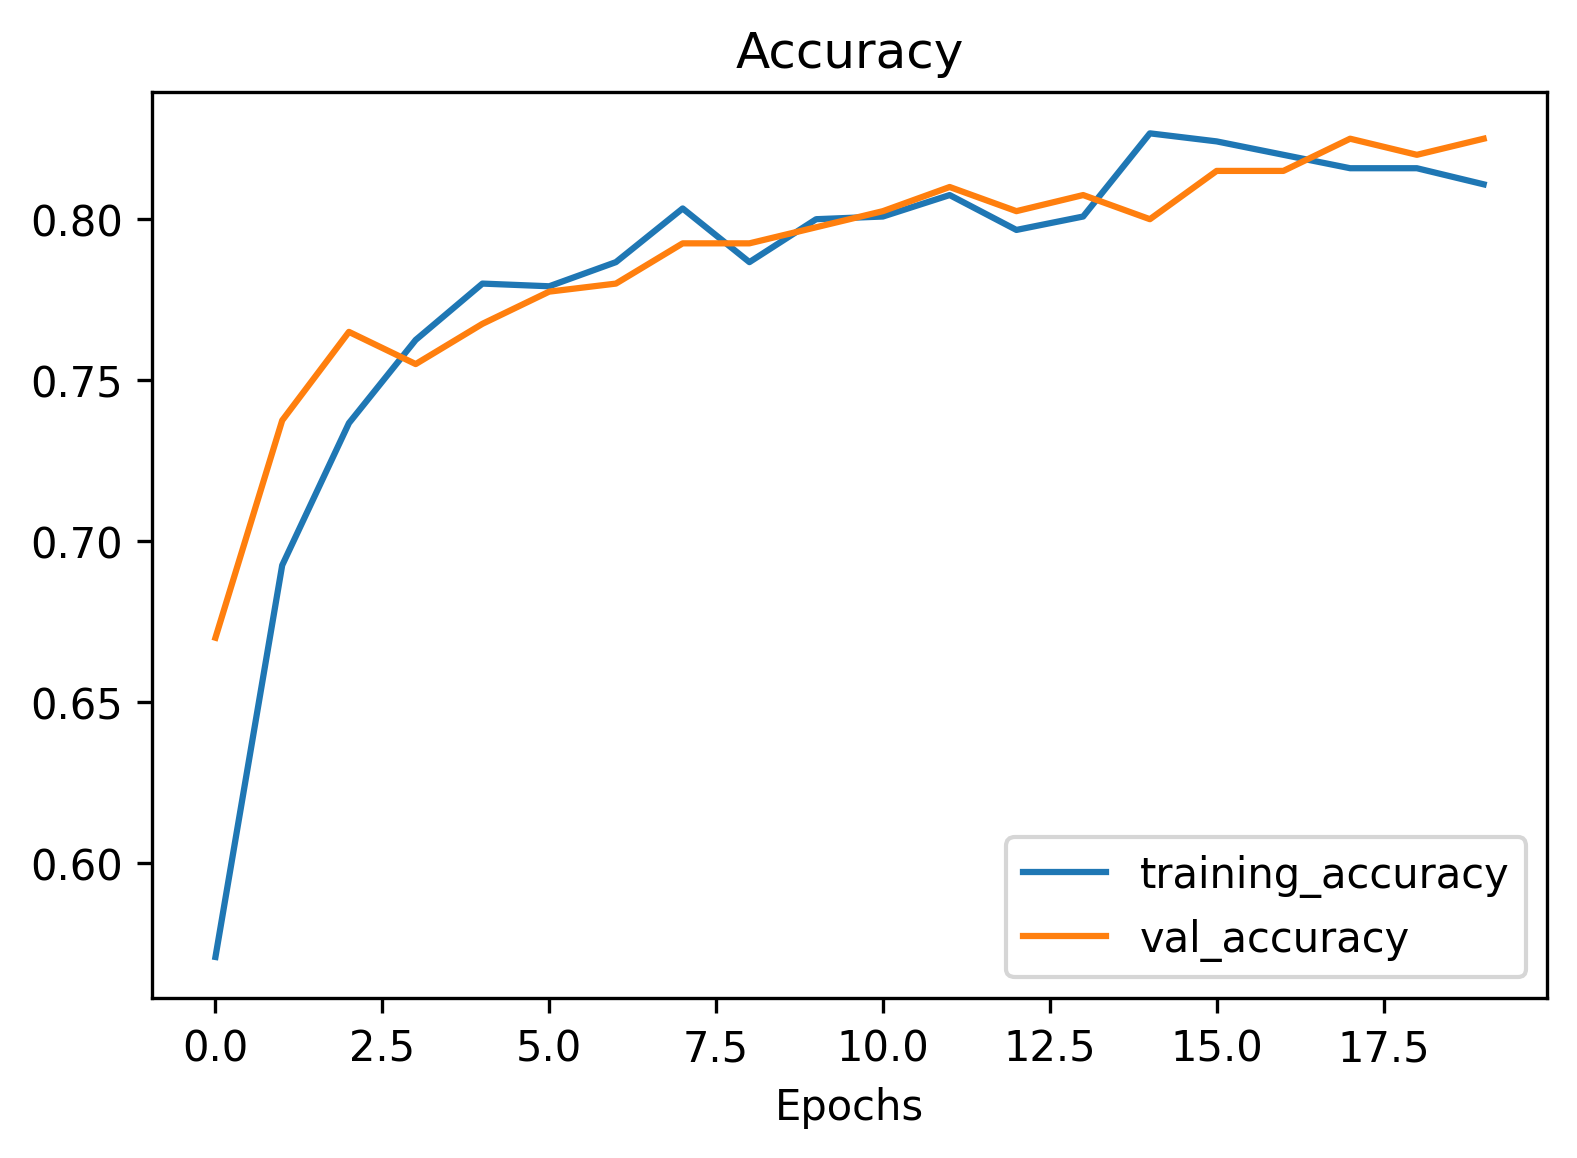

In [96]:
plot_loss_curves(history_16)

### Evaluation

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [97]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_16.predict(image_batch)
   # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))
   y_pred.append(preds.round())

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [98]:
acc = accuracy_score(y_pred=predicted_labels, y_true=correct_labels)
acc

0.8225

In [99]:
model_16.evaluate(test_dataset)

7/7 [==============================] - 3s 300ms/step - loss: 0.3758 - accuracy: 0.8225


[0.37577149271965027, 0.8224999904632568]

In [100]:
confusion_matrix(y_pred=predicted_labels, y_true=correct_labels)

array([[171,  29],
       [ 42, 158]])

In [101]:
test_dataset.class_names

['dyed-lifted-polyps', 'dyed-resection-margins']

In [102]:
cm_16 = confusion_matrix(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])
print(cm_16)

[[158  42]
 [ 29 171]]


In [103]:
print(classification_report(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.84      0.79      0.82       200
           0       0.80      0.85      0.83       200

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



In [104]:
recall_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.79

In [105]:
precision_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.8449197860962567

In [106]:
f1_score(y_pred=predicted_labels, y_true=correct_labels, labels=[1,0])

0.8165374677002585

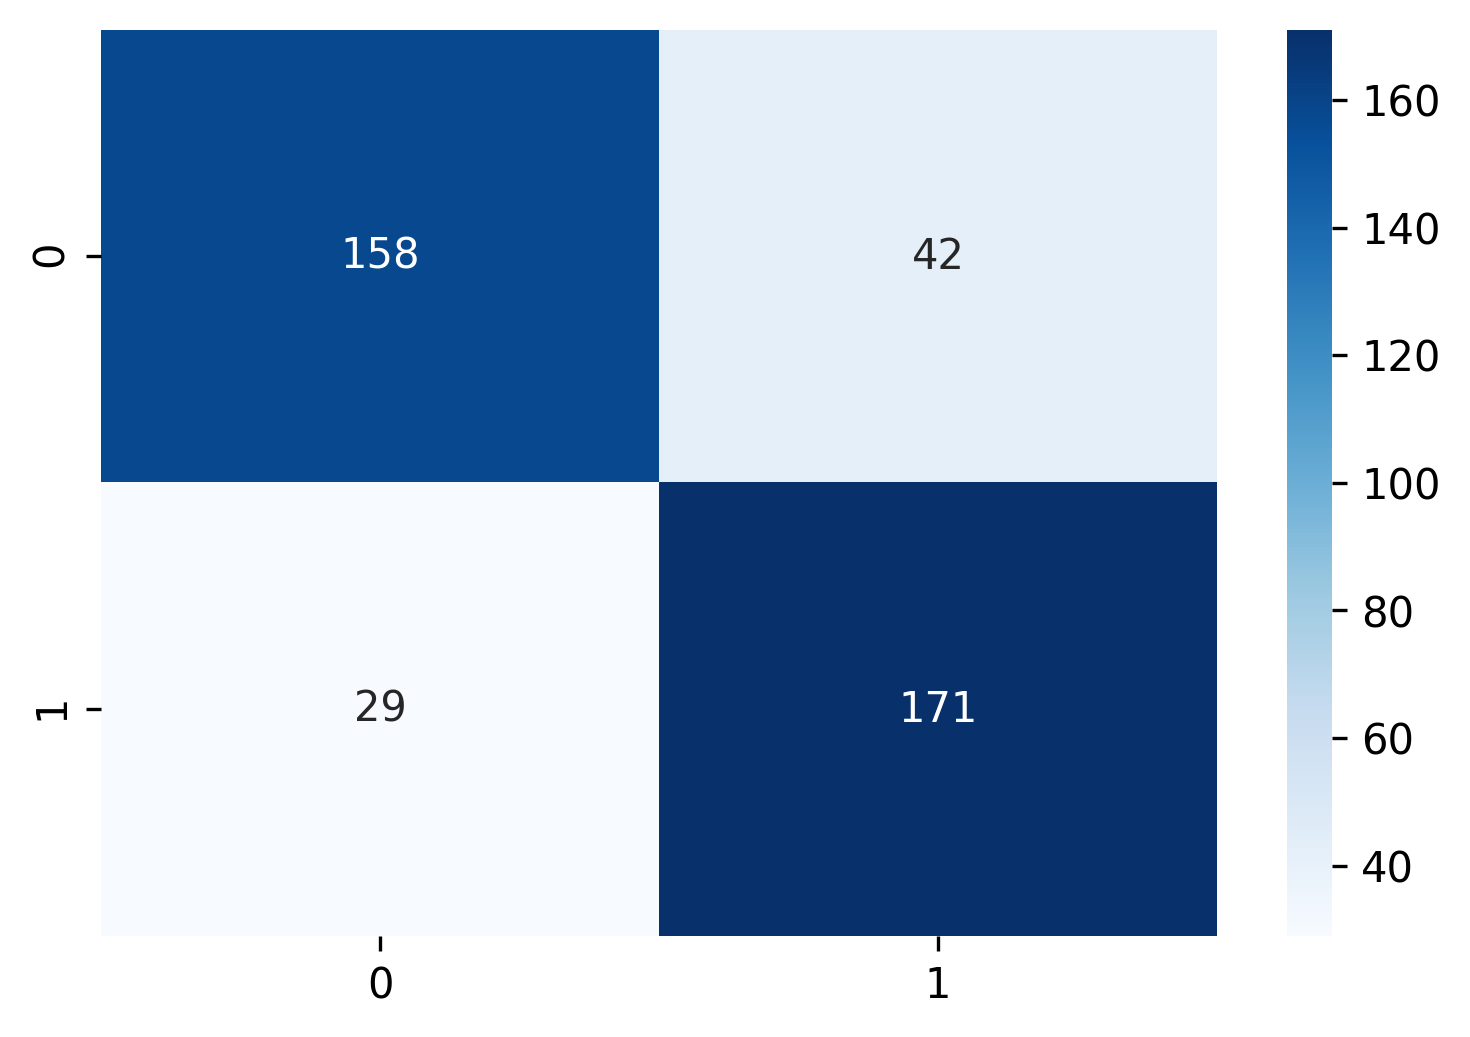

In [107]:
import seaborn as sns
sns.heatmap(cm_16, annot=True,  fmt='', cmap='Blues', )